Experimentation on the CIFAR simmulated annotators
* batch = 128
* delta convergence = $3\cdot 10^{-2}$
* Optimizer = ADAM

* Our proposed: Pre-train base model with hard-MV (5 epochs?) as Rodrigues: https://github.com/fmpr/CrowdLayer/blob/master/demo-conll-ner-mturk.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2 #tolerance for relative variation of parameters
#o 2?

### Load Data and preprocess

In [3]:
from keras.datasets import cifar10
(X_train, Z_train), (X_test, Z_test) = cifar10.load_data()
print("Input shape:",X_train.shape)

Input shape: (50000, 32, 32, 3)


In [4]:
Xstd_train = X_train.astype(DTYPE_OP)/255
Xstd_test = X_test.astype(DTYPE_OP)/255
Z_train = Z_train[:,0]
Z_test = Z_test[:,0]
Xstd_train.shape

(50000, 32, 32, 3)

### Load annotations

In [5]:
#opt = "CIFAR_normal"
#opt = "CIFAR_normal_badMV"
opt = "CIFAR_normal_soft" 
#opt = "CIFAR_manyAnnot_v1" #npy
#opt = "CIFAR_manyAnnot_v2" #npy
#opt = "CIFAR_manyAnnot_v1_badMV" #npy

In [6]:
y_obs = np.loadtxt("../syntetic/CIFAR/annotations_"+opt+".csv" ,delimiter=',',dtype='int')
#y_obs = np.load("../syntetic/CIFAR/annotations_"+opt+".npy" )

groups_annot = np.loadtxt("../syntetic/CIFAR/annotgroups_"+opt+".csv",delimiter=',')
#groups_annot = np.load("../syntetic/CIFAR/annotgroups_"+opt+".npy")

load_matrix = np.loadtxt('../syntetic/CIFAR/matrix_CIFAR_normal.csv',delimiter=',')
#load_matrix = np.loadtxt('../syntetic/CIFAR/matrix_CIFAR_badMV.csv',delimiter=',')

rows,Kl = load_matrix.shape
real_conf_matrix = np.asarray([load_matrix[j-Kl:j] for j in np.arange(Kl,rows+1,Kl)])
if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
    print("Done")
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

Shape (data,annotators):  (50000, 100)
Classes:  10


In [5]:
scenario = 7
path = "."

In [9]:
from code.generate_data import SinteticData

GenerateData = SinteticData()

#CONFUSION MATRIX CHOOSE
if scenario == 1 or scenario == 3 or scenario == 4 or scenario == 5 or scenario == 6:
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/CIFAR/matrix_CIFAR_normal.csv',file_groups =path+'/synthetic/CIFAR/groups_CIFAR_normal.csv')

elif scenario == 2 or scenario == 7: #bad MV
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/CIFAR/matrix_CIFAR_badMV.csv',file_groups =path+'/synthetic/CIFAR/groups_CIFAR_badMV.csv')

real_conf_matrix = GenerateData.conf_matrix.copy()

#ANNOTATOR DENSITY CHOOSE
if scenario == 1 or scenario ==2 or scenario == 3:
    Tmax = 100
    T_data = 10 
elif scenario == 4 or scenario == 7:
    Tmax = 2000
    T_data = 20 
elif scenario == 5:
    Tmax = 5000
    T_data = 25
elif scenario == 6:
    Tmax = 10000
    T_data = 40
    
print("New Synthetic data is being generated...",flush=True,end='')
if scenario == 3: #soft
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=False)
else:
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
print("Done! ")

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

print("Accuracy of MV on train: ",np.mean(majority_voting(y_obs,repeats=False,onehot=False) == Z_train))

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.77248
Shape (data,annotators):  (50000, 2000)
Classes:  10


In [30]:
GenerateData.prob_groups

array([0.2 , 0.45, 0.1 , 0.25])

#### Delta Convergence criteria

In [6]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [10]:
Z_train_onehot = keras.utils.to_categorical(Z_train)

model_UB = default_CNN(Xstd_train.shape[1:],Z_train_onehot.shape[1])

model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])

In [8]:
from code.representation import *
from code.utils import *

### Infer Labels (without predictive model)

In [10]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')
#label_I = LabelInference(y_obs_categorical,TOL, type_inf = 'all')

mv_probas = label_I.mv_labels('probas')
mv_onehot = label_I.mv_labels('onehot')

ds_labels,ds_conf = label_I.DS_labels()

Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -757074.3072654587
2 	 -747955.7423568431 	0.1672	0.262116	0.012044
3 	 -746885.2579339432 	0.0408	0.083011	0.001431
4 	 -746695.4284392287 	0.0260	0.040855	0.000254
5 	 -746639.3976689416 	0.0171	0.025316	0.000075
Class marginals
[0.1  0.1  0.08 0.08 0.11 0.12 0.11 0.1  0.1  0.1 ]


In [11]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.74872
ACC D&S on train: 0.80782


In [12]:
model_mvsoft = default_CNN(Xstd_train.shape[1:],mv_probas.shape[1])
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV")

Trained model over soft-MV


In [13]:
model_mvhard = default_CNN(Xstd_train.shape[1:],mv_onehot.shape[1])
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV")

Trained model over hard-MV


In [14]:
model_ds = default_CNN(Xstd_train.shape[1:],ds_labels.shape[1])
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S")

Trained model over D&S


In [10]:
#y_obs_categorical = label_I.y_obs_categ
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar & MV

### Raykar Model (joint predict model)

from baseline import RaykarMC

raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("default cnn")

raykarMC.define_priors(np.ones((T,K))) #cada observador dijo al menos un dato
logL_hist = raykarMC.train(Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,iterations=EPOCHS_BASE,tolerance=TOL
                           ,relative=True,val=False)

In [11]:
from code.baseline import RaykarMC

raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("default cnn")

logL_hists,i = raykarMC.multiples_run(10,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Initializing new EM...
Betas shape:  (2000, 10, 10)
Q estimate shape:  (50000, 10)
Iter 1/50 
M step: done,  E step: done //  (in 27.22 sec)	logL: -796788.438	
Iter 2/50 
M step: done,  E step: done //  (in 22.79 sec)	logL: -795997.438	Tol1: 0.00099	Tol2: 0.29153	
Iter 3/50 
M step: done,  E step: done //  (in 22.66 sec)	logL: -795761.125	Tol1: 0.00030	Tol2: 0.09114	
Iter 4/50 
M step: done,  E step: done //  (in 22.47 sec)	logL: -795668.125	Tol1: 0.00012	Tol2: 0.04502	
Iter 5/50 
M step: done,  E step: done //  (in 22.59 sec)	logL: -795602.625	Tol1: 0.00008	Tol2: 0.02981	
Finished training!
Initializing new EM...
Betas shape:  (2000, 10, 10)
Q estimate shape:  (50000, 10)
Iter 1/50 
M step: done,  E step: done //  (in 26.98 sec)	logL: -796793.312	
Iter 2/50 
M step: done,  E step: done //  (in 23.04 sec)	logL: -796013.812	Tol1: 0.00098	Tol2: 0.28985	
Iter 3/50 
M step: done,  E step: done //  (in 22.81 sec)	logL: -795702.000	Tol1: 0.00039	Tol2: 0.09784	
Iter 4/50 
M step: done,  E ste

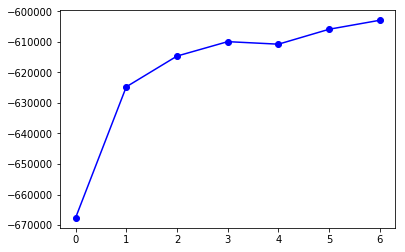

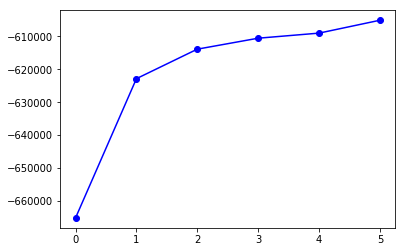

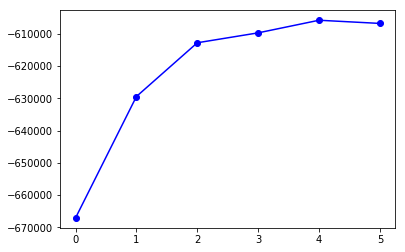

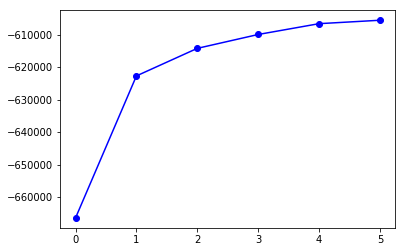

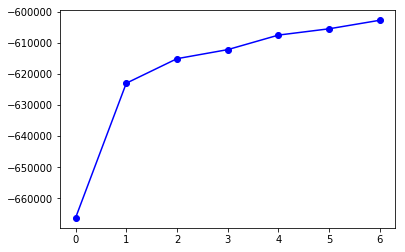

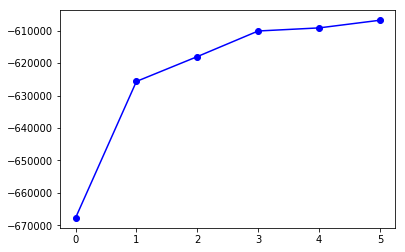

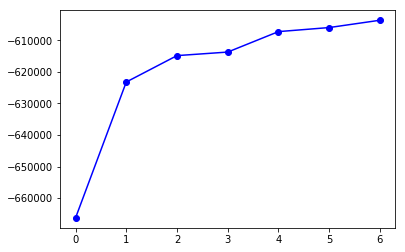

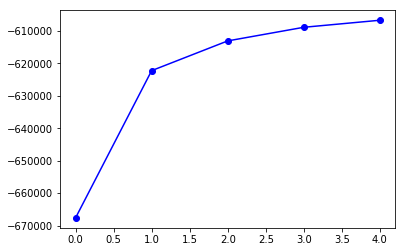

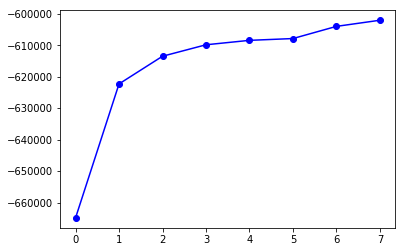

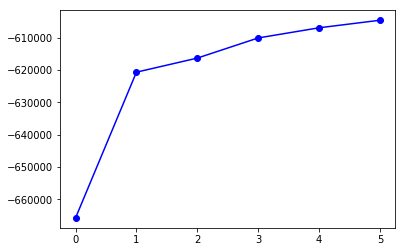

In [20]:
for value in logL_hists:
    plt.plot(range(len(value)),value,'bo-')
    plt.show()

### Our Proposed

In [12]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
r_obs = set_representation(y_obs_categorical,"repeat")
#r_obs = set_representation(y_obs,"repeat")
print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[ 0  1  2 ...  2  0  0]
 [ 0  8  1 ...  1  0  5]
 [ 0  3  1 ...  3  2  7]
 ...
 [ 1  1  1 ...  1  1  5]
 [ 0 12  1 ...  0  1  7]
 [ 1  6  1 ...  0  1  5]]
shape: (50000, 10)


In [13]:
%%time

#pre analysis
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
if y_obs_categorical.shape[1] > 3000:
    annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,printed=False,mode_project="tpca")[0]
else:
    annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,printed=False,mode_project="pca")[0]
print("Annotators PCA of annotations shape: ",annotators_pca.shape)

#mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
#aux = []
#for example in mv_soft:
#    aux.append(entropy(example)/np.log(K))
#print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

Annotators PCA of annotations shape:  (2000, 4)
CPU times: user 37.1 s, sys: 21.5 s, total: 58.6 s
Wall time: 44.2 s


In [14]:
M_seted = 4

In [15]:
gMixture1 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture1.define_model("default cnn")
gMixture1.lambda_random = False #lambda=1     
logL_hists,i = gMixture1.multiples_run(10,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Clustering Done!
Get init alphas in 0.180383 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1. 1.]
Alphas:  (4,)
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (50000, 10, 4, 10)
Iter 1/50
M step: done,  E step: done //  (in 26.40 sec)	logL: -2151537.891	
Iter 2/50
M step: done,  E step: done //  (in 17.34 sec)	logL: -2112877.307	Tol1: 0.01797	Tol2: 0.15108	Tol3: 0.00779	
Iter 3/50
M step: done,  E step: done //  (in 17.15 sec)	logL: -2090958.396	Tol1: 0.01037	Tol2: 0.14332	Tol3: 0.00503	
Iter 4/50
M step: done,  E step: done //  (in 17.30 sec)	logL: -2078924.365	Tol1: 0.00576	Tol2: 0.12423	Tol3: 0.00406	
Iter 5/50
M step: done,  E step: done //  (in 17.53 sec)	logL: -2053857.284	Tol1: 0.01206	Tol2: 0.09834	Tol3: 0.00499	
Iter 6/50
M step: done,  E step: done //  (in 17.47 sec)	logL: -2036155.225	Tol1: 0.00862	Tol2: 0.08051	Tol3: 0.00297	
Iter 7/50
M step: done,  E step: done //  (in 17.38 sec)	logL: -2031571.968	Tol1: 0.00225	Tol2: 

M step: done,  E step: done //  (in 17.35 sec)	logL: -1993317.125	Tol1: 0.00501	Tol2: 0.07533	Tol3: 0.00109	
Iter 12/50
M step: done,  E step: done //  (in 17.61 sec)	logL: -1989557.967	Tol1: 0.00189	Tol2: 0.07611	Tol3: 0.00158	
Iter 13/50
M step: done,  E step: done //  (in 17.41 sec)	logL: -1990680.159	Tol1: 0.00056	Tol2: 0.06760	Tol3: 0.00115	
Iter 14/50
M step: done,  E step: done //  (in 17.64 sec)	logL: -1977547.839	Tol1: 0.00660	Tol2: 0.06711	Tol3: 0.00325	
Iter 15/50
M step: done,  E step: done //  (in 17.40 sec)	logL: -1982161.855	Tol1: 0.00233	Tol2: 0.06310	Tol3: 0.00167	
Iter 16/50
M step: done,  E step: done //  (in 17.44 sec)	logL: -1981987.856	Tol1: 0.00009	Tol2: 0.06354	Tol3: 0.00133	
Iter 17/50
M step: done,  E step: done //  (in 17.41 sec)	logL: -1970166.975	Tol1: 0.00596	Tol2: 0.06374	Tol3: 0.00140	
Iter 18/50
M step: done,  E step: done //  (in 17.54 sec)	logL: -1958408.007	Tol1: 0.00597	Tol2: 0.05605	Tol3: 0.00227	
Iter 19/50
M step: done,  E step: done //  (in 17.5

M step: done,  E step: done //  (in 17.94 sec)	logL: -2094339.619	Tol1: 0.01050	Tol2: 0.14039	Tol3: 0.00799	
Iter 4/50
M step: done,  E step: done //  (in 18.03 sec)	logL: -2065078.823	Tol1: 0.01397	Tol2: 0.12525	Tol3: 0.00644	
Iter 5/50
M step: done,  E step: done //  (in 18.05 sec)	logL: -2049560.386	Tol1: 0.00751	Tol2: 0.10656	Tol3: 0.00241	
Iter 6/50
M step: done,  E step: done //  (in 17.88 sec)	logL: -2036288.359	Tol1: 0.00648	Tol2: 0.07474	Tol3: 0.00390	
Iter 7/50
M step: done,  E step: done //  (in 18.01 sec)	logL: -2020795.620	Tol1: 0.00761	Tol2: 0.06742	Tol3: 0.00137	
Iter 8/50
M step: done,  E step: done //  (in 18.07 sec)	logL: -2010063.784	Tol1: 0.00531	Tol2: 0.06291	Tol3: 0.00109	
Iter 9/50
M step: done,  E step: done //  (in 17.74 sec)	logL: -2003151.176	Tol1: 0.00344	Tol2: 0.05762	Tol3: 0.00074	
Iter 10/50
M step: done,  E step: done //  (in 18.05 sec)	logL: -2006095.439	Tol1: 0.00147	Tol2: 0.05359	Tol3: 0.00134	
Iter 11/50
M step: done,  E step: done //  (in 18.06 sec)

In [16]:
gMixture2 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture2.define_model("default cnn")
gMixture2.lambda_random = True #lambda random
logL_hists,i = gMixture2.multiples_run(10,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Clustering Done!
Get init alphas in 0.172200 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.40299946 0.12263902 0.701242   0.8247606 ]
Alphas:  (4,)
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (50000, 10, 4, 10)
Iter 1/50
M step: done,  E step: done //  (in 25.26 sec)	logL: -2097684.727	
Iter 2/50
M step: done,  E step: done //  (in 18.04 sec)	logL: -2074380.664	Tol1: 0.01111	Tol2: 0.11931	Tol3: 0.01513	
Iter 3/50
M step: done,  E step: done //  (in 18.13 sec)	logL: -2038685.008	Tol1: 0.01721	Tol2: 0.12335	Tol3: 0.00228	
Iter 4/50
M step: done,  E step: done //  (in 18.20 sec)	logL: -2011585.085	Tol1: 0.01329	Tol2: 0.08470	Tol3: 0.00449	
Iter 5/50
M step: done,  E step: done //  (in 18.27 sec)	logL: -1999069.526	Tol1: 0.00622	Tol2: 0.05509	Tol3: 0.00377	
Iter 6/50
M step: done,  E step: done //  (in 18.18 sec)	logL: -1988086.950	Tol1: 0.00549	Tol2: 0.08792	Tol3: 0.00365	
Iter 7/50
M step: done,  E step: done //  (in 18.21 sec)	logL: -

M step: done,  E step: done //  (in 25.46 sec)	logL: -2137801.182	
Iter 2/50
M step: done,  E step: done //  (in 18.10 sec)	logL: -2086342.253	Tol1: 0.02407	Tol2: 0.15455	Tol3: 0.01569	
Iter 3/50
M step: done,  E step: done //  (in 18.20 sec)	logL: -2070744.512	Tol1: 0.00748	Tol2: 0.12401	Tol3: 0.00942	
Iter 4/50
M step: done,  E step: done //  (in 18.15 sec)	logL: -2045792.530	Tol1: 0.01205	Tol2: 0.12753	Tol3: 0.00907	
Iter 5/50
M step: done,  E step: done //  (in 18.07 sec)	logL: -2042529.605	Tol1: 0.00159	Tol2: 0.11759	Tol3: 0.00567	
Iter 6/50
M step: done,  E step: done //  (in 18.11 sec)	logL: -2013667.578	Tol1: 0.01413	Tol2: 0.11615	Tol3: 0.00421	
Iter 7/50
M step: done,  E step: done //  (in 17.96 sec)	logL: -2002582.076	Tol1: 0.00551	Tol2: 0.08231	Tol3: 0.00233	
Iter 8/50
M step: done,  E step: done //  (in 18.18 sec)	logL: -1986237.654	Tol1: 0.00816	Tol2: 0.07163	Tol3: 0.00104	
Iter 9/50
M step: done,  E step: done //  (in 18.07 sec)	logL: -1982655.471	Tol1: 0.00180	Tol2: 0.05

M step: done,  E step: done //  (in 18.33 sec)	logL: -1951508.702	Tol1: 0.00340	Tol2: 0.07208	Tol3: 0.00660	
Iter 14/50
M step: done,  E step: done //  (in 18.48 sec)	logL: -1951318.873	Tol1: 0.00010	Tol2: 0.03815	Tol3: 0.00541	
Iter 15/50
M step: done,  E step: done //  (in 18.18 sec)	logL: -1946487.967	Tol1: 0.00248	Tol2: 0.06355	Tol3: 0.00477	
Iter 16/50
M step: done,  E step: done //  (in 18.47 sec)	logL: -1954821.975	Tol1: 0.00428	Tol2: 0.07606	Tol3: 0.00225	
Iter 17/50
M step: done,  E step: done //  (in 18.32 sec)	logL: -1948853.026	Tol1: 0.00305	Tol2: 0.08940	Tol3: 0.00562	
Iter 18/50
M step: done,  E step: done //  (in 18.22 sec)	logL: -1940849.056	Tol1: 0.00411	Tol2: 0.06420	Tol3: 0.00950	
Iter 19/50
M step: done,  E step: done //  (in 18.35 sec)	logL: -1935811.426	Tol1: 0.00260	Tol2: 0.07750	Tol3: 0.00268	
Iter 20/50
M step: done,  E step: done //  (in 18.35 sec)	logL: -1937312.944	Tol1: 0.00078	Tol2: 0.02747	Tol3: 0.00088	
Finished training!
Initializing new EM...
Pre-train

In [17]:
gMixture3 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture3.define_model("default cnn")
gMixture3.lambda_random = True #with lambda random --necessary
logL_hists,i = gMixture3.multiples_run(10,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)

Clustering Done!
Get init alphas in 6.678322 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.88220453 0.02606426 0.4839338  0.06814855]
Alphas:  (4,)
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (50000, 10, 4, 10)
Iter 1/50
M step: done,  E step: done //  (in 28.85 sec)	logL: -2066166.906	
Iter 2/50
M step: done,  E step: done //  (in 19.03 sec)	logL: -2038951.926	Tol1: 0.01317	Tol2: 0.13742	Tol3: 0.02179	
Iter 3/50
M step: done,  E step: done //  (in 18.97 sec)	logL: -2026692.810	Tol1: 0.00601	Tol2: 0.11456	Tol3: 0.00583	
Iter 4/50
M step: done,  E step: done //  (in 19.00 sec)	logL: -2019767.965	Tol1: 0.00342	Tol2: 0.09249	Tol3: 0.00766	
Iter 5/50
M step: done,  E step: done //  (in 19.16 sec)	logL: -1996925.846	Tol1: 0.01131	Tol2: 0.07321	Tol3: 0.01034	
Iter 6/50
M step: done,  E step: done //  (in 19.02 sec)	logL: -1992849.553	Tol1: 0.00204	Tol2: 0.07677	Tol3: 0.00736	
Iter 7/50
M step: done,  E step: done //  (in 18.94 sec)	logL: -

M step: done,  E step: done //  (in 18.98 sec)	logL: -1947645.797	Tol1: 0.00205	Tol2: 0.04405	Tol3: 0.00738	
Iter 19/50
M step: done,  E step: done //  (in 19.16 sec)	logL: -1946573.556	Tol1: 0.00055	Tol2: 0.03902	Tol3: 0.00798	
Iter 20/50
M step: done,  E step: done //  (in 19.29 sec)	logL: -1943240.150	Tol1: 0.00171	Tol2: 0.04482	Tol3: 0.01014	
Iter 21/50
M step: done,  E step: done //  (in 19.20 sec)	logL: -1941978.910	Tol1: 0.00065	Tol2: 0.04694	Tol3: 0.00947	
Iter 22/50
M step: done,  E step: done //  (in 18.95 sec)	logL: -1940085.319	Tol1: 0.00098	Tol2: 0.04056	Tol3: 0.00429	
Iter 23/50
M step: done,  E step: done //  (in 19.29 sec)	logL: -1936663.060	Tol1: 0.00176	Tol2: 0.02727	Tol3: 0.00289	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.36216724 0.509011   0.41141015 0.5945373 ]
Alphas:  (4,)
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (50000, 10, 4, 10)
Iter 1/50
M step: done,  E step: done //  (in 30.90 sec)	l

M step: done,  E step: done //  (in 19.64 sec)	logL: -2031509.900	Tol1: 0.00442	Tol2: 0.07569	Tol3: 0.00443	
Iter 5/50
M step: done,  E step: done //  (in 19.73 sec)	logL: -2024873.302	Tol1: 0.00327	Tol2: 0.06875	Tol3: 0.00853	
Iter 6/50
M step: done,  E step: done //  (in 19.60 sec)	logL: -2012881.167	Tol1: 0.00592	Tol2: 0.08587	Tol3: 0.01033	
Iter 7/50
M step: done,  E step: done //  (in 19.41 sec)	logL: -2017876.006	Tol1: 0.00248	Tol2: 0.07032	Tol3: 0.00832	
Iter 8/50
M step: done,  E step: done //  (in 19.81 sec)	logL: -1992925.991	Tol1: 0.01236	Tol2: 0.19980	Tol3: 0.02694	
Iter 9/50
M step: done,  E step: done //  (in 19.67 sec)	logL: -1994652.091	Tol1: 0.00087	Tol2: 0.07610	Tol3: 0.00578	
Iter 10/50
M step: done,  E step: done //  (in 19.79 sec)	logL: -1977457.924	Tol1: 0.00862	Tol2: 0.07071	Tol3: 0.01297	
Iter 11/50
M step: done,  E step: done //  (in 19.57 sec)	logL: -1973184.503	Tol1: 0.00216	Tol2: 0.05324	Tol3: 0.00579	
Iter 12/50
M step: done,  E step: done //  (in 19.69 sec

### Compare trained models

In [18]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [27]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound -- Ideal (Train with GT) ***")

print("Train")
Z_train_pred = model_UB.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = model_UB.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound -- Ideal (Train with GT) ***
Train
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.98012       0.98012
====  ======  ==========  ============
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.8428        0.8428
====  ======  ==========  ============


#### 1st configuration: Normal ($T$ = 100, $T_{max}$ = 10 )

In [24]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.80502


*** Soft-Majority (Train with softMV) ***
Train


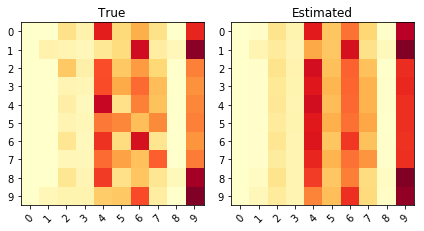

KL divergence: 0.0337	Pearson Correlation between diagonals: 0.9897


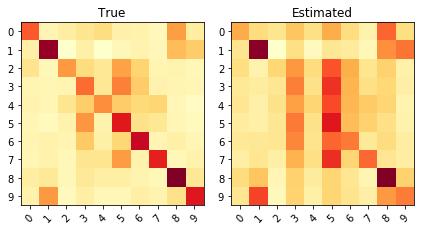

KL divergence: 0.1448	Pearson Correlation between diagonals: 0.9125


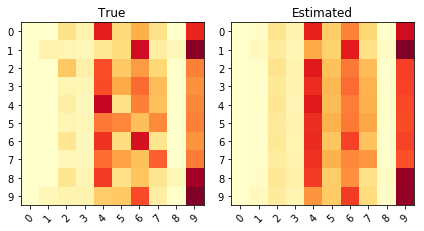

KL divergence: 0.0339	Pearson Correlation between diagonals: 0.9902


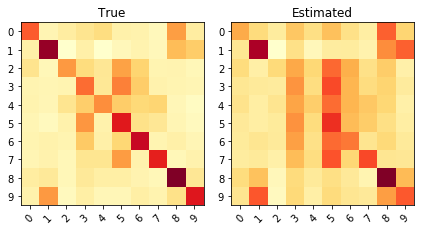

KL divergence: 0.1404	Pearson Correlation between diagonals: 0.9465


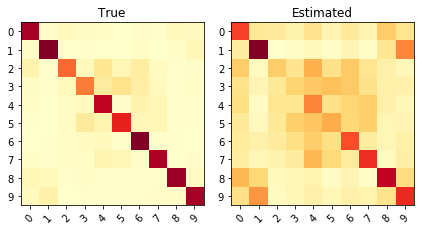

KL divergence: 0.5742	Pearson Correlation between diagonals: 0.8865


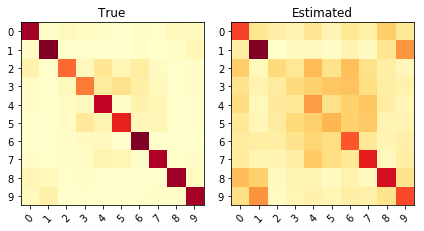

KL divergence: 0.5965	Pearson Correlation between diagonals: 0.8789


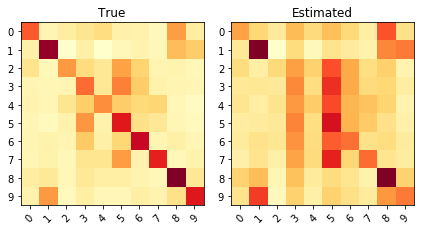

KL divergence: 0.1436	Pearson Correlation between diagonals: 0.9151


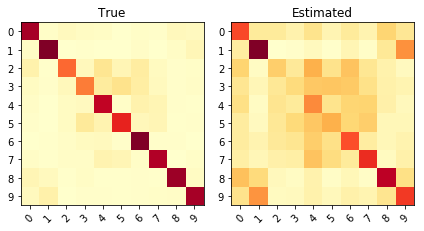

KL divergence: 0.5766	Pearson Correlation between diagonals: 0.8843


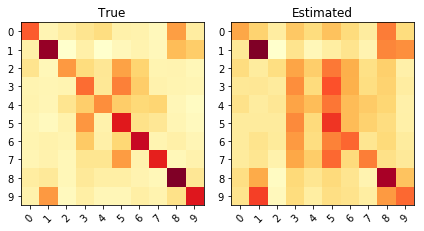

KL divergence: 0.1409	Pearson Correlation between diagonals: 0.9335


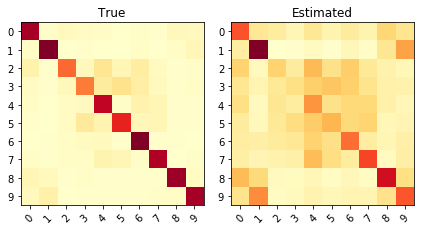

KL divergence: 0.5835	Pearson Correlation between diagonals: 0.8601


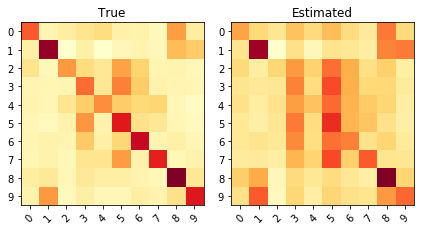

KL divergence: 0.1455	Pearson Correlation between diagonals: 0.9242


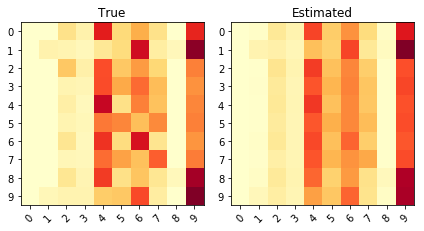

KL divergence: 0.0336	Pearson Correlation between diagonals: 0.9857


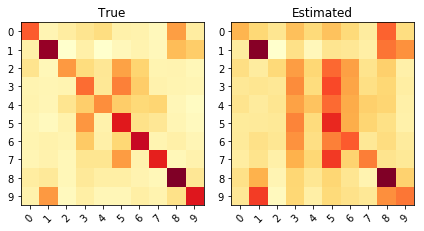

KL divergence: 0.1426	Pearson Correlation between diagonals: 0.9372


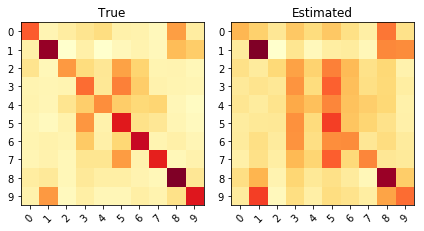

KL divergence: 0.1422	Pearson Correlation between diagonals: 0.9118


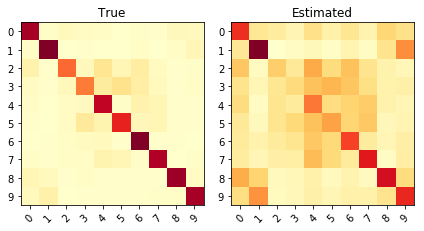

KL divergence: 0.5813	Pearson Correlation between diagonals: 0.9213
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.58618       0.58618   0.254549  0.0635741             0.93283
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.5773        0.5773
====  ======  ==========  ============


In [25]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


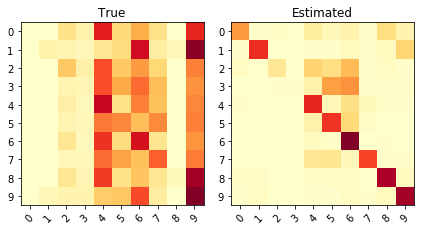

KL divergence: 0.6352	Pearson Correlation between diagonals: 0.5312


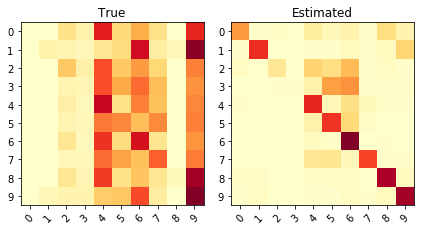

KL divergence: 0.6352	Pearson Correlation between diagonals: 0.5312


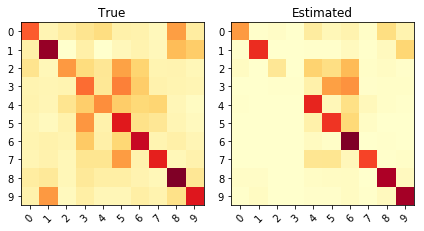

KL divergence: 0.6333	Pearson Correlation between diagonals: 0.6871


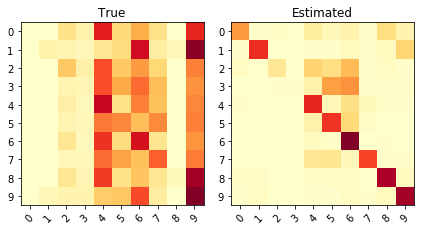

KL divergence: 0.6352	Pearson Correlation between diagonals: 0.5312


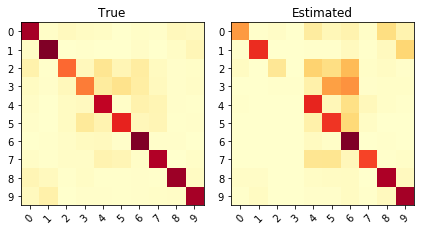

KL divergence: 1.3368	Pearson Correlation between diagonals: 0.8533


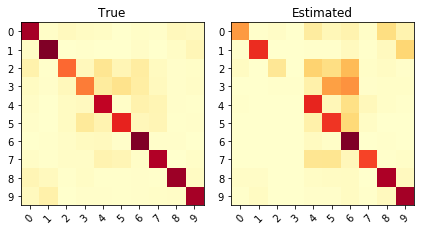

KL divergence: 1.3368	Pearson Correlation between diagonals: 0.8533


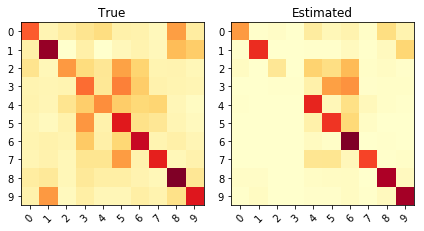

KL divergence: 0.6333	Pearson Correlation between diagonals: 0.6871


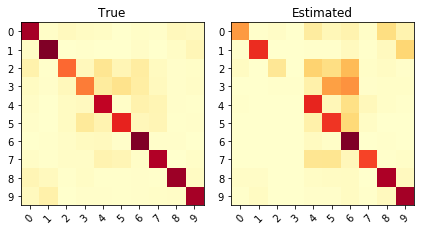

KL divergence: 1.3368	Pearson Correlation between diagonals: 0.8533


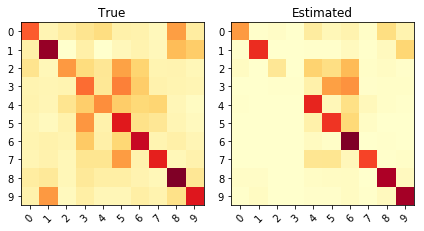

KL divergence: 0.6333	Pearson Correlation between diagonals: 0.6871


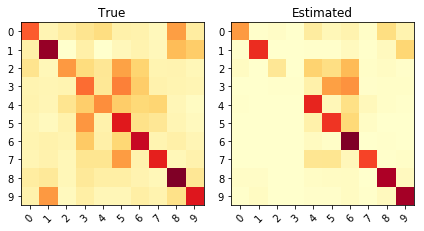

KL divergence: 0.6333	Pearson Correlation between diagonals: 0.6871


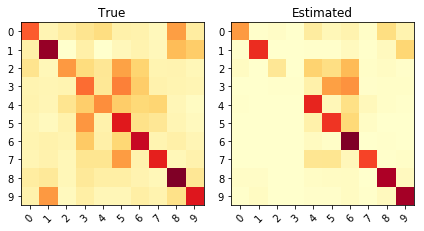

KL divergence: 0.6333	Pearson Correlation between diagonals: 0.6871


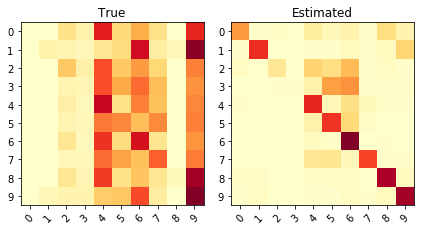

KL divergence: 0.6352	Pearson Correlation between diagonals: 0.5312


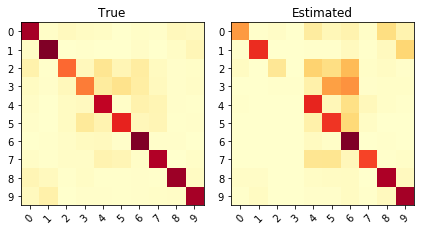

KL divergence: 1.3368	Pearson Correlation between diagonals: 0.8533


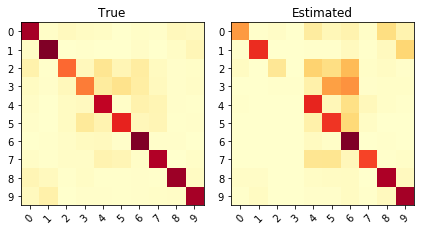

KL divergence: 1.3368	Pearson Correlation between diagonals: 0.8533


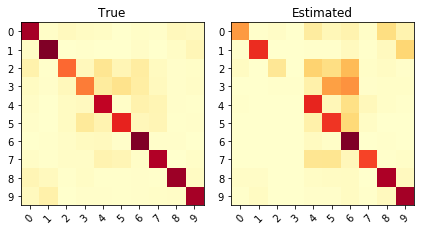

KL divergence: 1.3368	Pearson Correlation between diagonals: 0.8533
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.58618       0.58618   0.840835   0.286516            0.692642
====  ======  ==========  ============  =========  =========  ==================


In [26]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


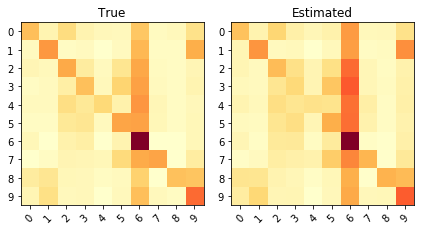

KL divergence: 0.0348	Pearson Correlation between diagonals: 0.9844


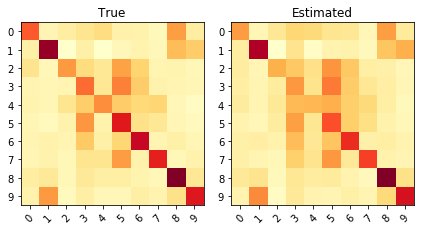

KL divergence: 0.0316	Pearson Correlation between diagonals: 0.9722


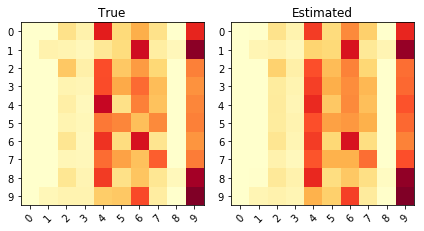

KL divergence: 0.0118	Pearson Correlation between diagonals: 0.9935


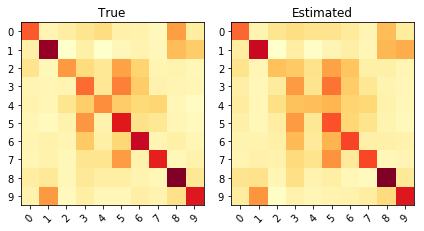

KL divergence: 0.0344	Pearson Correlation between diagonals: 0.9528


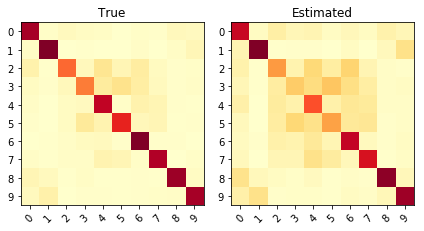

KL divergence: 0.1567	Pearson Correlation between diagonals: 0.9276


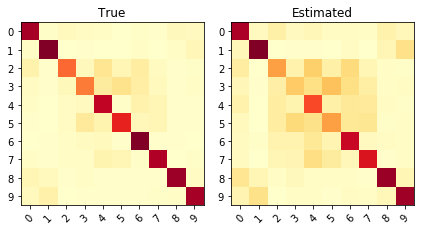

KL divergence: 0.1489	Pearson Correlation between diagonals: 0.9326


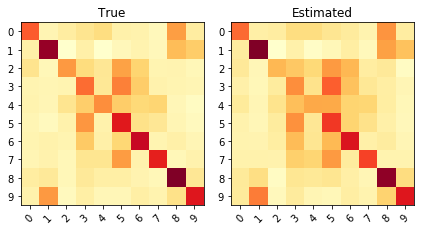

KL divergence: 0.0303	Pearson Correlation between diagonals: 0.9864


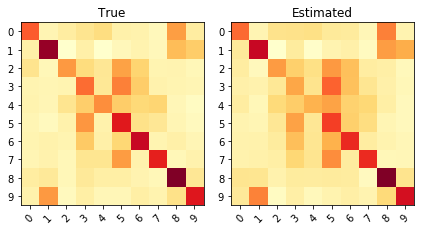

KL divergence: 0.0341	Pearson Correlation between diagonals: 0.9470


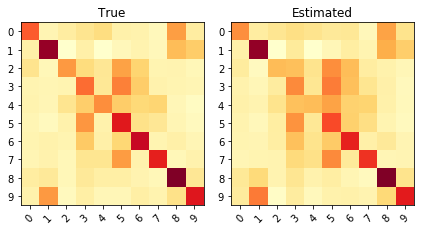

KL divergence: 0.0289	Pearson Correlation between diagonals: 0.9849


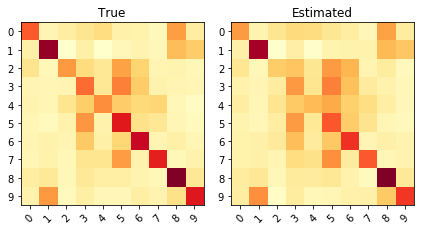

KL divergence: 0.0338	Pearson Correlation between diagonals: 0.9882


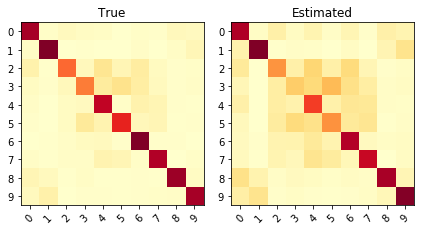

KL divergence: 0.1470	Pearson Correlation between diagonals: 0.9433


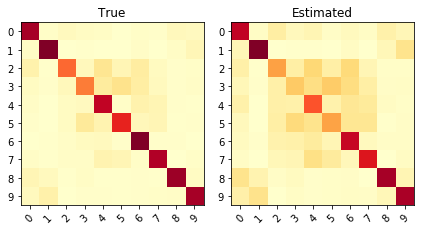

KL divergence: 0.1497	Pearson Correlation between diagonals: 0.9343


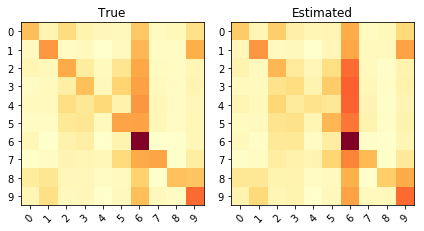

KL divergence: 0.0339	Pearson Correlation between diagonals: 0.9923


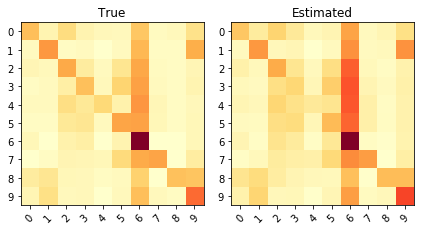

KL divergence: 0.0385	Pearson Correlation between diagonals: 0.9795


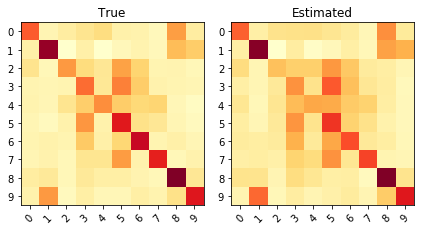

KL divergence: 0.0389	Pearson Correlation between diagonals: 0.9523
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global      0.7782        0.7782  0.0655332  0.0172189            0.962909
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.7425        0.7425
====  ======  ==========  ============


In [27]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


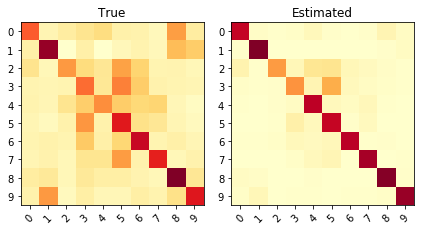

KL divergence: 0.4299	Pearson Correlation between diagonals: 0.7279


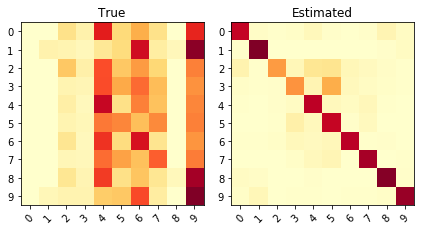

KL divergence: 0.5892	Pearson Correlation between diagonals: 0.2567


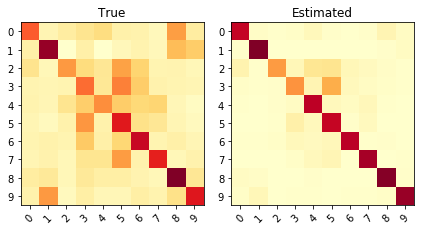

KL divergence: 0.4299	Pearson Correlation between diagonals: 0.7279


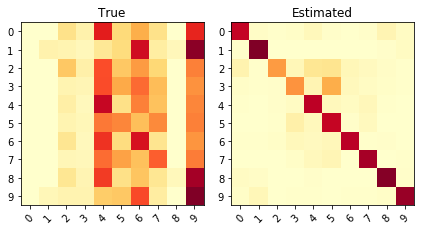

KL divergence: 0.5892	Pearson Correlation between diagonals: 0.2567


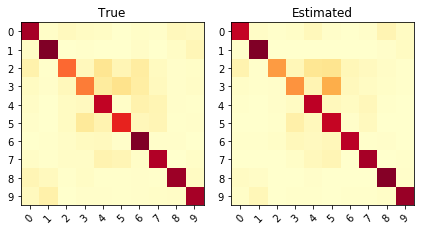

KL divergence: 1.3257	Pearson Correlation between diagonals: 0.9248


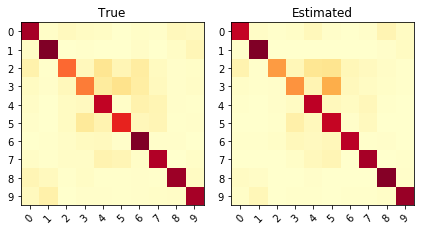

KL divergence: 1.3257	Pearson Correlation between diagonals: 0.9248


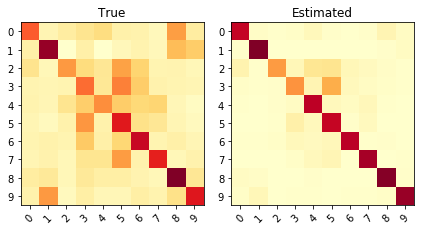

KL divergence: 0.4299	Pearson Correlation between diagonals: 0.7279


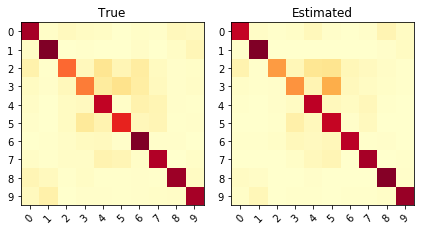

KL divergence: 1.3257	Pearson Correlation between diagonals: 0.9248


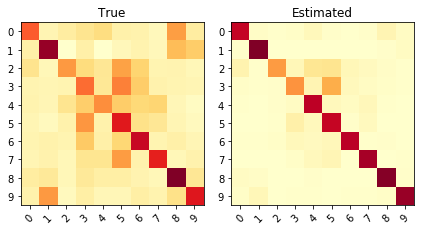

KL divergence: 0.4299	Pearson Correlation between diagonals: 0.7279


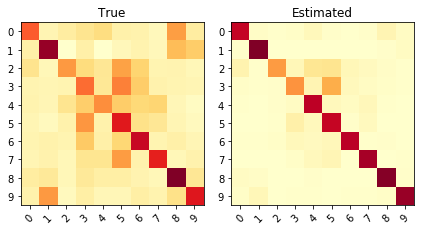

KL divergence: 0.4299	Pearson Correlation between diagonals: 0.7279


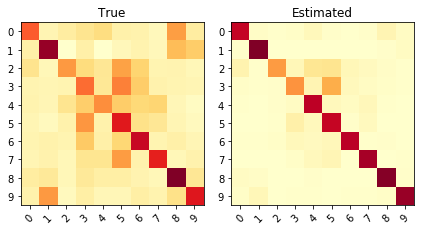

KL divergence: 0.4299	Pearson Correlation between diagonals: 0.7279


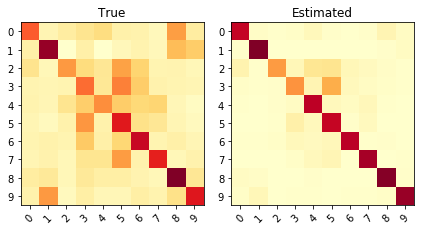

KL divergence: 0.4299	Pearson Correlation between diagonals: 0.7279


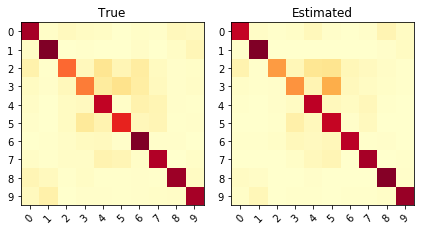

KL divergence: 1.3257	Pearson Correlation between diagonals: 0.9248


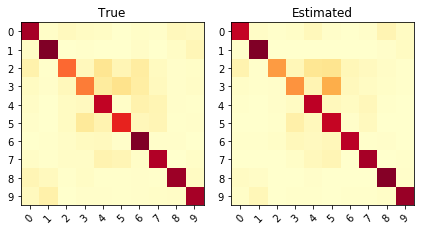

KL divergence: 1.3257	Pearson Correlation between diagonals: 0.9248


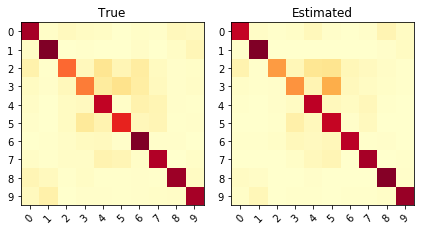

KL divergence: 1.3257	Pearson Correlation between diagonals: 0.9248
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global      0.7782        0.7782   0.725262   0.283009            0.664226
====  ======  ==========  ============  =========  =========  ==================


In [28]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


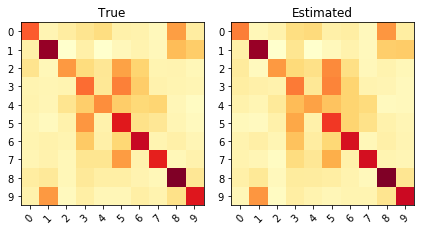

KL divergence: 0.0118	Pearson Correlation between diagonals: 0.9706


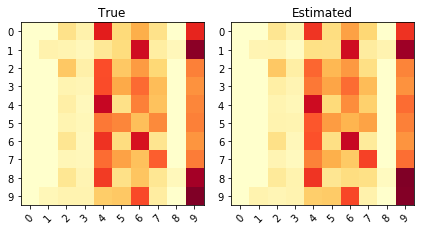

KL divergence: 0.0069	Pearson Correlation between diagonals: 0.9955


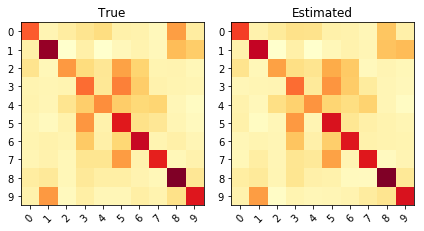

KL divergence: 0.0102	Pearson Correlation between diagonals: 0.9646


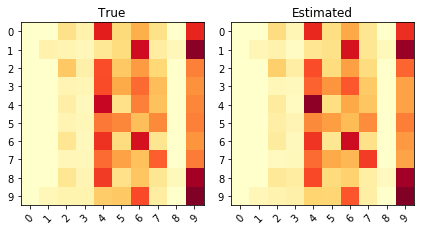

KL divergence: 0.0079	Pearson Correlation between diagonals: 0.9926


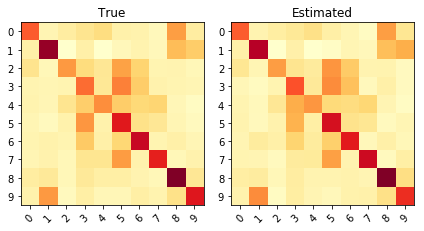

KL divergence: 0.0134	Pearson Correlation between diagonals: 0.9536


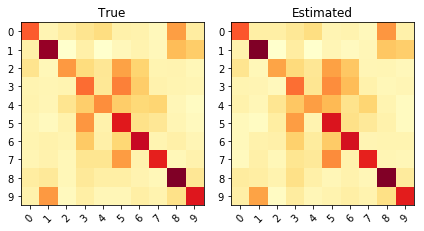

KL divergence: 0.0099	Pearson Correlation between diagonals: 0.9911


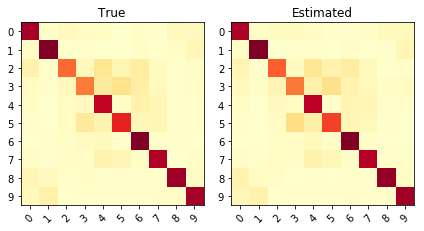

KL divergence: 0.0235	Pearson Correlation between diagonals: 0.9876


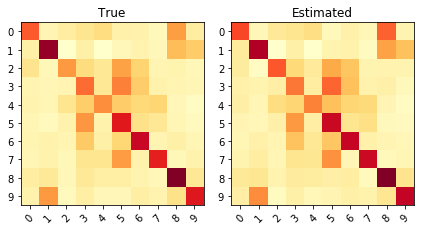

KL divergence: 0.0122	Pearson Correlation between diagonals: 0.9460


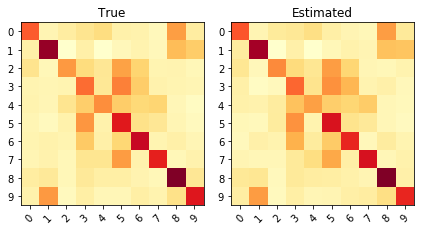

KL divergence: 0.0106	Pearson Correlation between diagonals: 0.9587


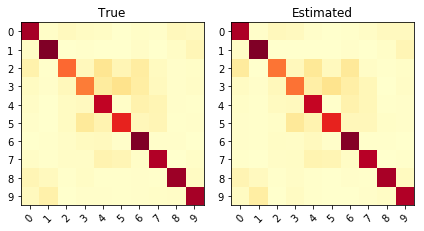

KL divergence: 0.0166	Pearson Correlation between diagonals: 0.9971


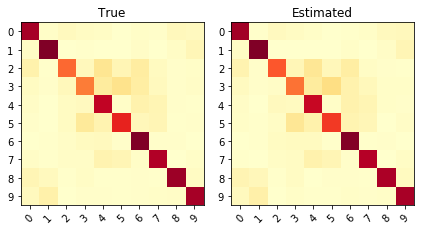

KL divergence: 0.0167	Pearson Correlation between diagonals: 0.9886


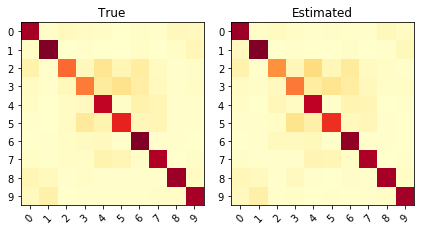

KL divergence: 0.0248	Pearson Correlation between diagonals: 0.9874


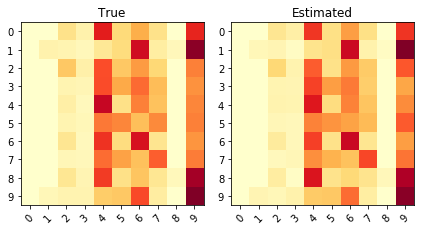

KL divergence: 0.0103	Pearson Correlation between diagonals: 0.9940


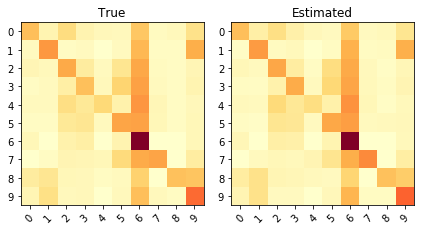

KL divergence: 0.0081	Pearson Correlation between diagonals: 0.9860


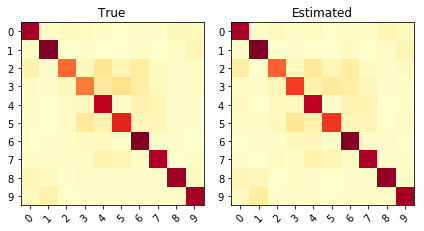

KL divergence: 0.0219	Pearson Correlation between diagonals: 0.9643
A result
 ====  ======  ==========  ============  =========  ==========  ==================
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  ==========  ==================
   0  Global     0.80854       0.80854  0.0137832  0.00272482            0.980567
====  ======  ==========  ============  =========  ==========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.7557        0.7557
====  ======  ==========  ============


In [29]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


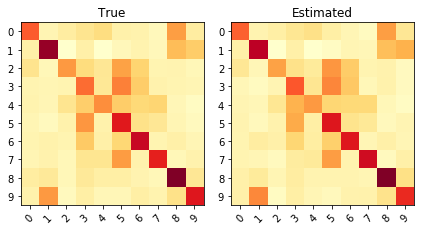

KL divergence: 0.0098	Pearson Correlation between diagonals: 0.9635


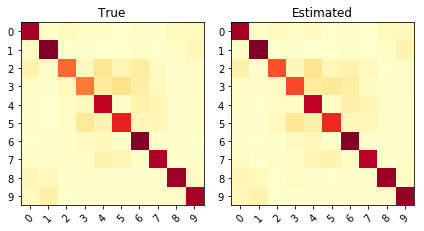

KL divergence: 0.0093	Pearson Correlation between diagonals: 0.9848


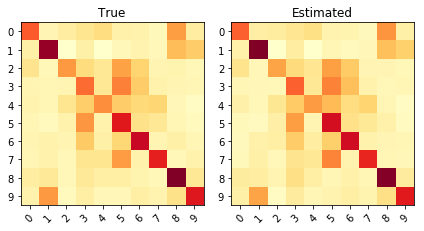

KL divergence: 0.0084	Pearson Correlation between diagonals: 0.9886


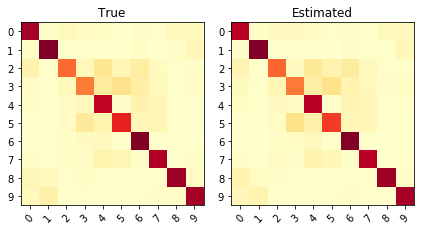

KL divergence: 0.0113	Pearson Correlation between diagonals: 0.9893


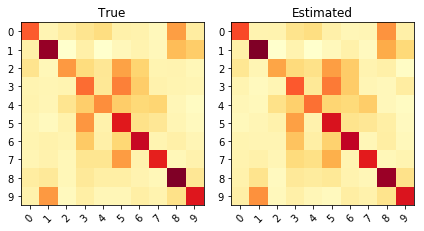

KL divergence: 0.0092	Pearson Correlation between diagonals: 0.9779


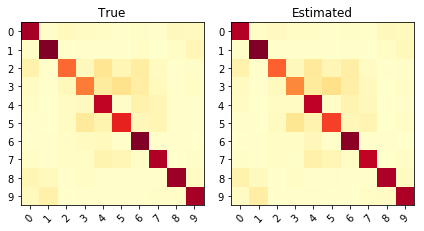

KL divergence: 0.0082	Pearson Correlation between diagonals: 0.9883


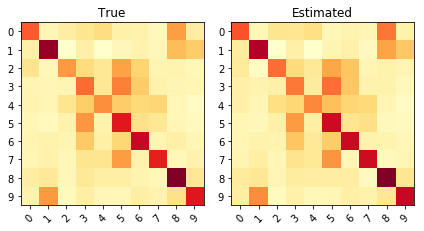

KL divergence: 0.0097	Pearson Correlation between diagonals: 0.9614


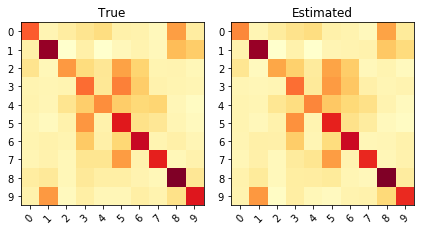

KL divergence: 0.0085	Pearson Correlation between diagonals: 0.9877


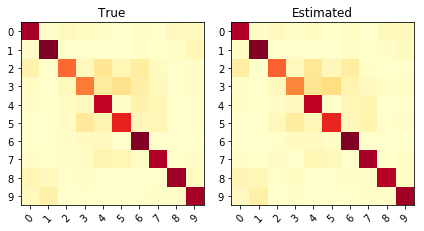

KL divergence: 0.0122	Pearson Correlation between diagonals: 0.9902


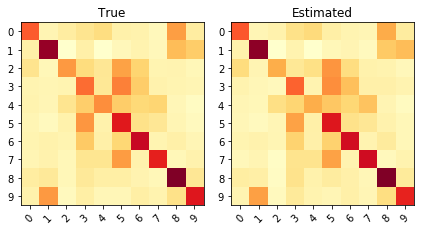

KL divergence: 0.0119	Pearson Correlation between diagonals: 0.9771


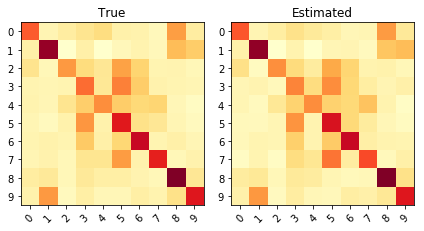

KL divergence: 0.0120	Pearson Correlation between diagonals: 0.9766


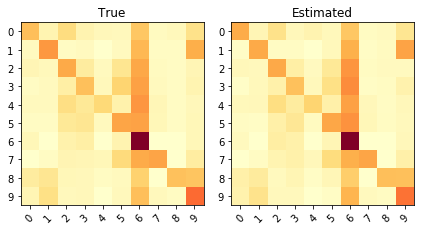

KL divergence: 0.0122	Pearson Correlation between diagonals: 0.9895


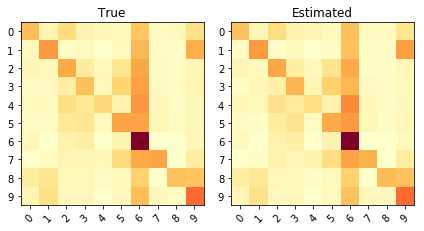

KL divergence: 0.0088	Pearson Correlation between diagonals: 0.9941


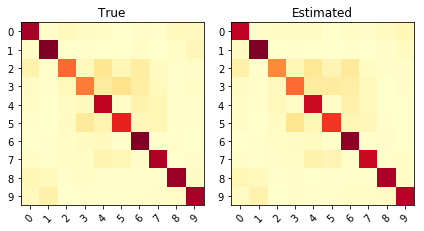

KL divergence: 0.0105	Pearson Correlation between diagonals: 0.9825


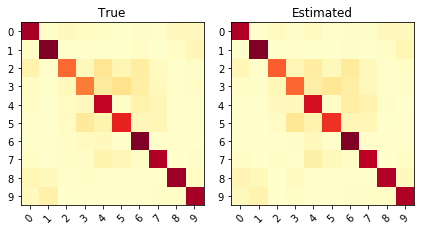

KL divergence: 0.0113	Pearson Correlation between diagonals: 0.9850
A result
 ====  ======  ==========  ============  ==========  ==========  ==================  ==============
  ..            Accuracy    F1 (micro)     Mean KL     Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  ==========  ==========  ==================  ==============
   0  Global     0.80704       0.80704  0.00996929  0.00260587            0.983005       0.0631678
====  ======  ==========  ============  ==========  ==========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.418503                 1.66684
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global   

In [30]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


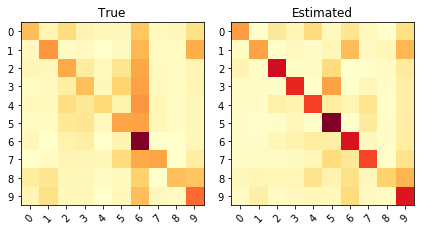

KL divergence: 0.6291	Pearson Correlation between diagonals: 0.2931


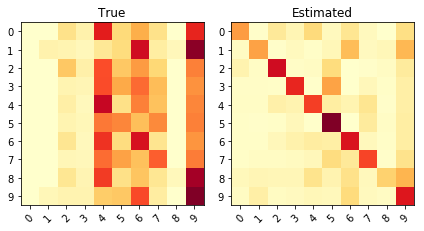

KL divergence: 0.7560	Pearson Correlation between diagonals: 0.5607


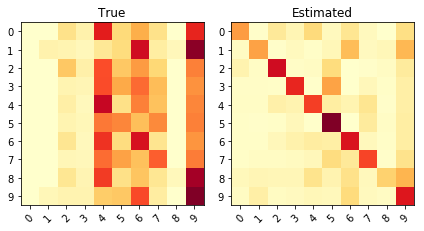

KL divergence: 0.7560	Pearson Correlation between diagonals: 0.5607


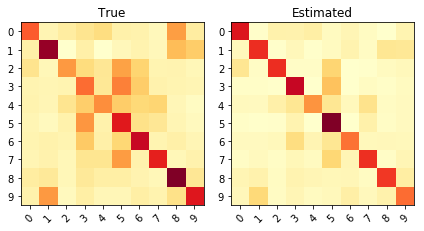

KL divergence: 0.3824	Pearson Correlation between diagonals: 0.0042


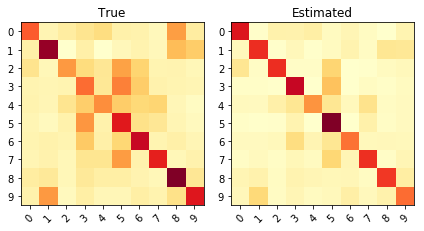

KL divergence: 0.3824	Pearson Correlation between diagonals: 0.0042


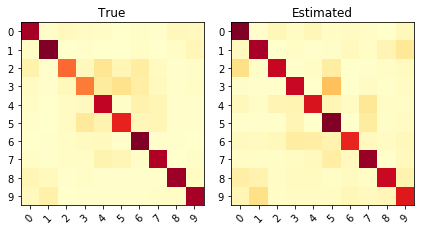

KL divergence: 0.2739	Pearson Correlation between diagonals: -0.0884


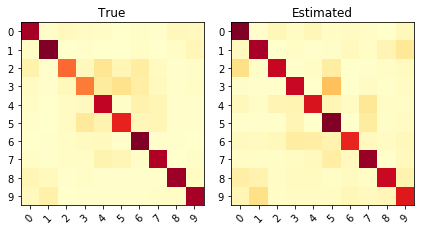

KL divergence: 0.2739	Pearson Correlation between diagonals: -0.0884


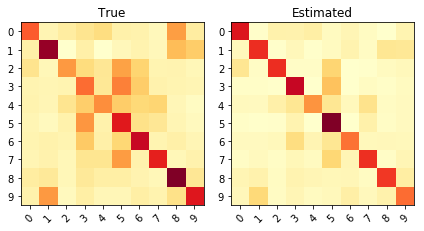

KL divergence: 0.3824	Pearson Correlation between diagonals: 0.0042


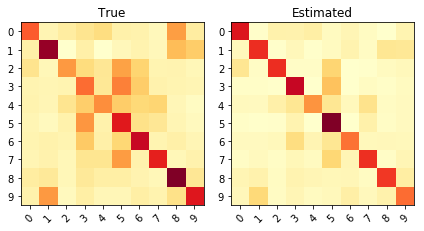

KL divergence: 0.3824	Pearson Correlation between diagonals: 0.0042


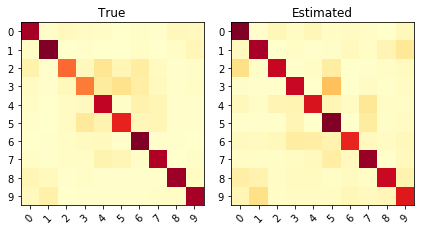

KL divergence: 0.2739	Pearson Correlation between diagonals: -0.0884


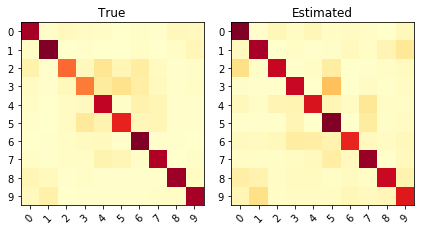

KL divergence: 0.2739	Pearson Correlation between diagonals: -0.0884


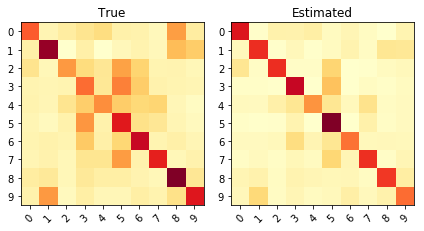

KL divergence: 0.3824	Pearson Correlation between diagonals: 0.0042


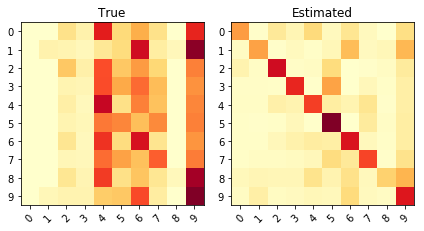

KL divergence: 0.7560	Pearson Correlation between diagonals: 0.5607


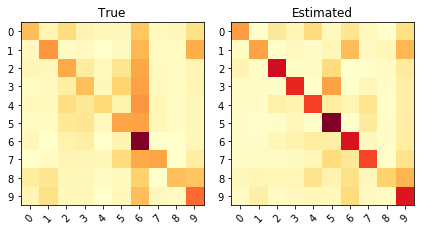

KL divergence: 0.6291	Pearson Correlation between diagonals: 0.2931


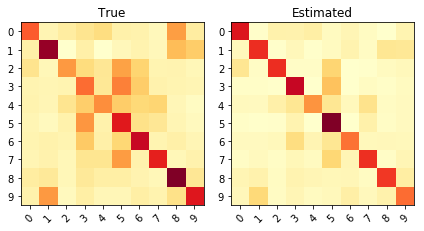

KL divergence: 0.3824	Pearson Correlation between diagonals: 0.0042
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.81508       0.81508   0.426638  0.0669812           0.0814631       0.0284352
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                  0.43138                 1.70306
====  =======================  ======================
Test


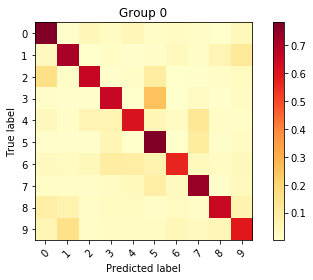

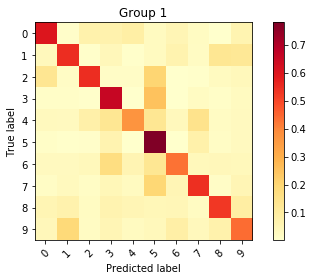

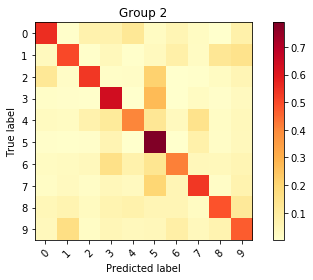

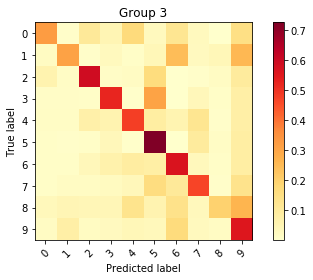

Inertia: 0.025814110830348607
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.300979      30    1.19376     0.675612   0.397962       0.813326   0.575612      0.785         0.785
   1         1  0.227161      22    1.49506     0.544456   0.628835       0.717767   0.444456      0.7849        0.7849
   2         2  0.292713      29    1.50925     0.533428   0.646549       0.710046   0.433428      0.7788        0.7788
   3         3  0.179148      17    1.57089     0.474265   0.805266       0.655534   0.374265      0.645         0.645
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A 

In [31]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


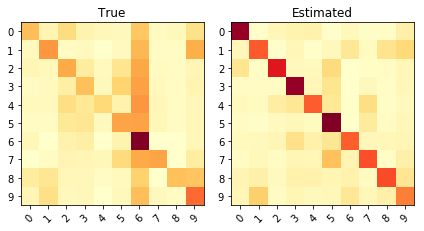

KL divergence: 0.7503	Pearson Correlation between diagonals: -0.3583


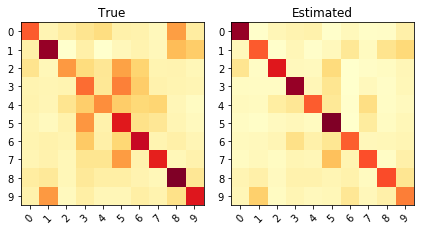

KL divergence: 0.3166	Pearson Correlation between diagonals: -0.3823


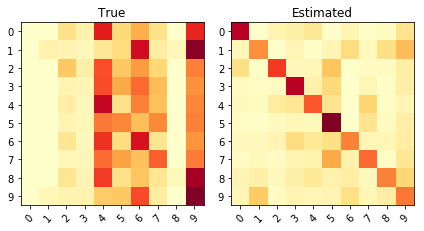

KL divergence: 0.8380	Pearson Correlation between diagonals: -0.3117


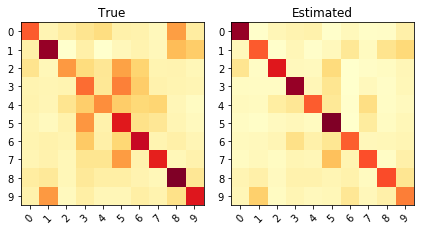

KL divergence: 0.3166	Pearson Correlation between diagonals: -0.3823


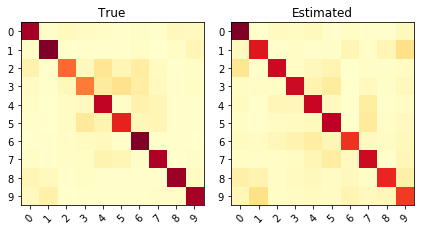

KL divergence: 0.2239	Pearson Correlation between diagonals: -0.3048


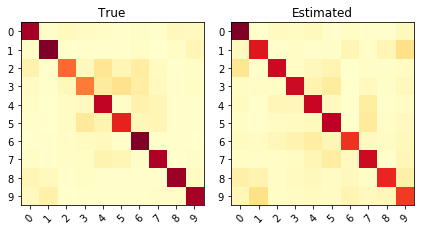

KL divergence: 0.2239	Pearson Correlation between diagonals: -0.3048


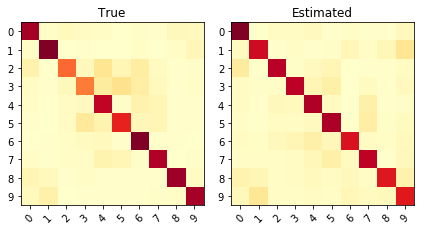

KL divergence: 0.2047	Pearson Correlation between diagonals: -0.3518


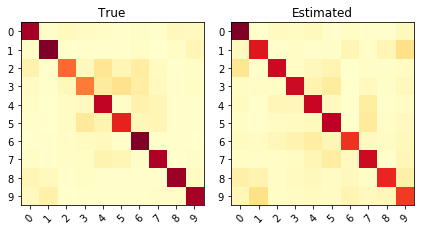

KL divergence: 0.2239	Pearson Correlation between diagonals: -0.3048


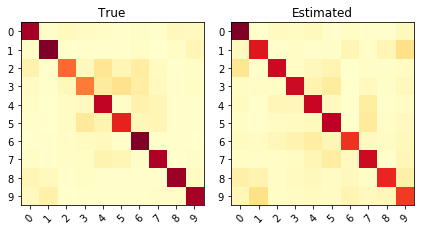

KL divergence: 0.2239	Pearson Correlation between diagonals: -0.3048


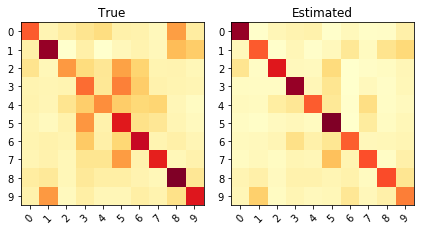

KL divergence: 0.3166	Pearson Correlation between diagonals: -0.3823


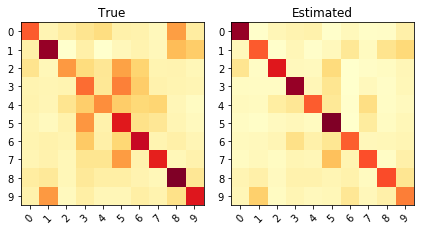

KL divergence: 0.3166	Pearson Correlation between diagonals: -0.3823


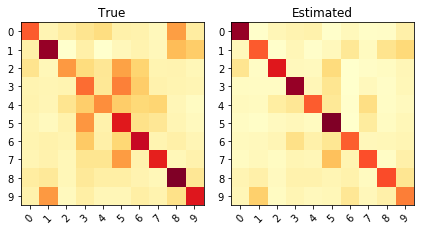

KL divergence: 0.3166	Pearson Correlation between diagonals: -0.3823


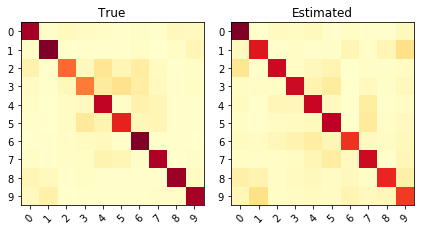

KL divergence: 0.2239	Pearson Correlation between diagonals: -0.3048


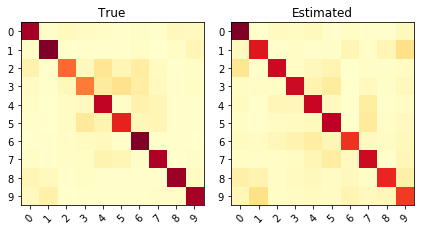

KL divergence: 0.2239	Pearson Correlation between diagonals: -0.3048


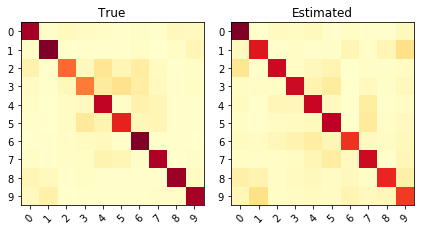

KL divergence: 0.2239	Pearson Correlation between diagonals: -0.3048
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.81666       0.81666   0.406988   0.072578           -0.349296       0.0211964
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.424882                 1.73912
====  =======================  ======================
Test


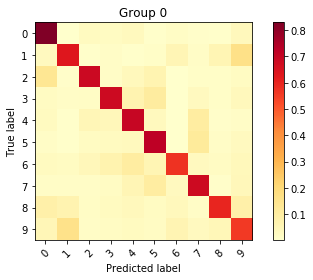

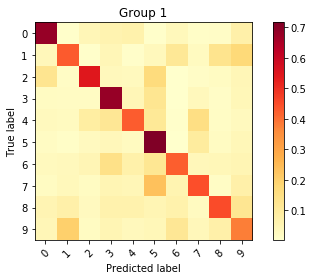

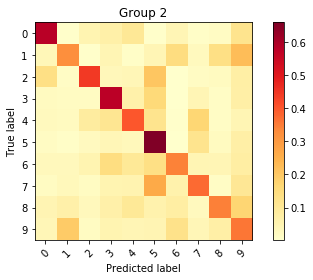

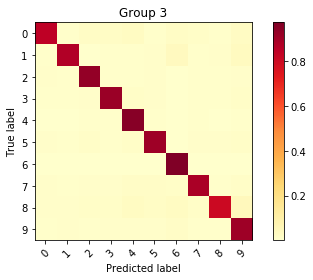

Inertia: 0.0627941859420389
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.27152       27   1.25199      0.666439   0.412113       0.807155   0.566439      0.78          0.78
   1         1  0.236346      23   1.58009      0.518576   0.682384       0.696873   0.418576      0.7778        0.7778
   2         2  0.317873      31   1.70526      0.441275   0.849152       0.633445   0.341275      0.7551        0.7551
   3         3  0.174262      17   0.519652     0.900076   0.106705       0.94766    0.800076      0.7396        0.7396
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A re

In [32]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


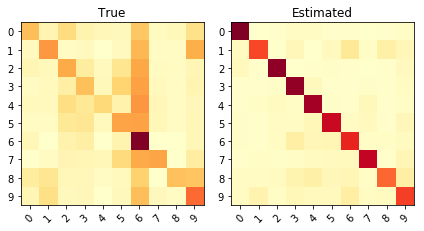

KL divergence: 0.9427	Pearson Correlation between diagonals: -0.3774


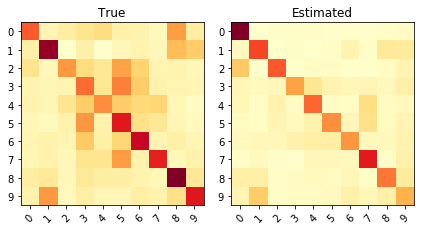

KL divergence: 0.3985	Pearson Correlation between diagonals: -0.1644


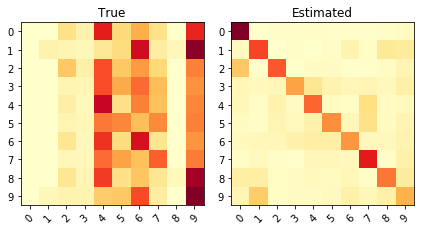

KL divergence: 1.0005	Pearson Correlation between diagonals: -0.4468


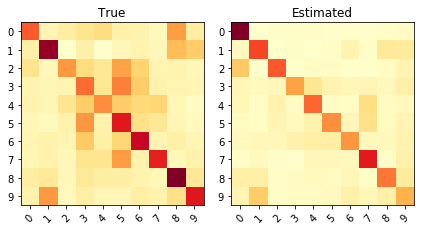

KL divergence: 0.3985	Pearson Correlation between diagonals: -0.1644


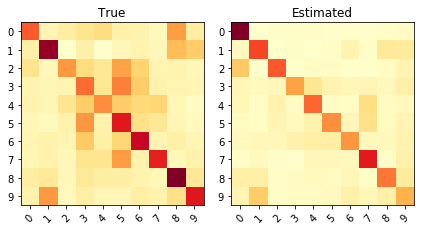

KL divergence: 0.3985	Pearson Correlation between diagonals: -0.1644


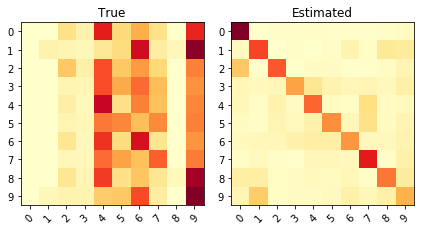

KL divergence: 1.0005	Pearson Correlation between diagonals: -0.4468


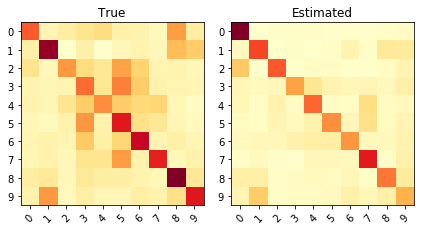

KL divergence: 0.3985	Pearson Correlation between diagonals: -0.1644


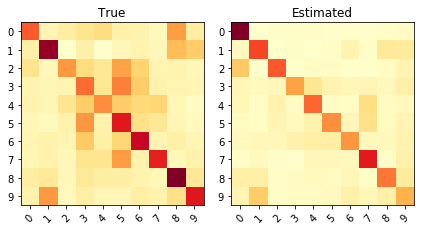

KL divergence: 0.3985	Pearson Correlation between diagonals: -0.1644


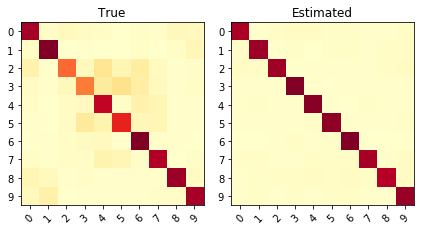

KL divergence: 0.2503	Pearson Correlation between diagonals: -0.3194


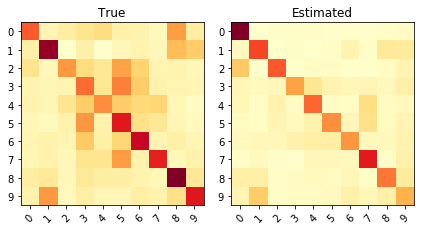

KL divergence: 0.3985	Pearson Correlation between diagonals: -0.1644


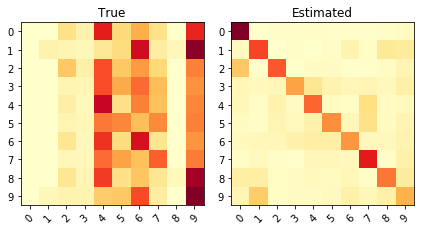

KL divergence: 1.0005	Pearson Correlation between diagonals: -0.4468


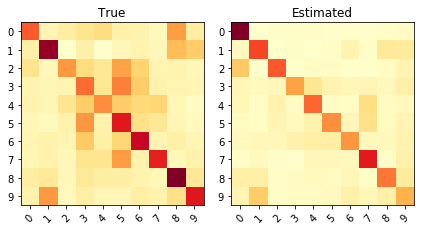

KL divergence: 0.3985	Pearson Correlation between diagonals: -0.1644


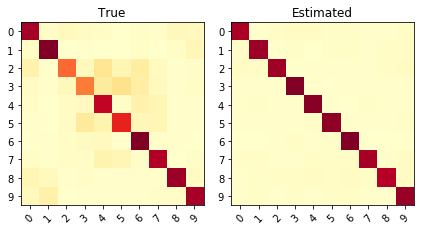

KL divergence: 0.2503	Pearson Correlation between diagonals: -0.3194


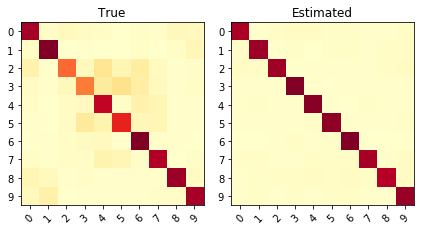

KL divergence: 0.2503	Pearson Correlation between diagonals: -0.3194


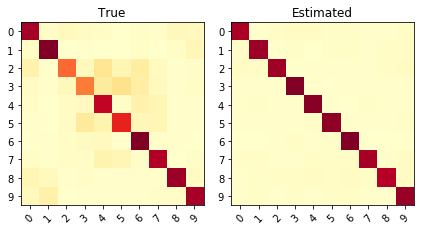

KL divergence: 0.2503	Pearson Correlation between diagonals: -0.3194
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.83848       0.83848    0.49368  0.0967421            -0.26951       0.0233846
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.423796                 1.77668
====  =======================  ======================
Test


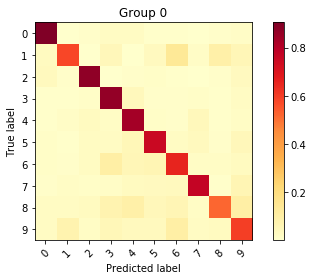

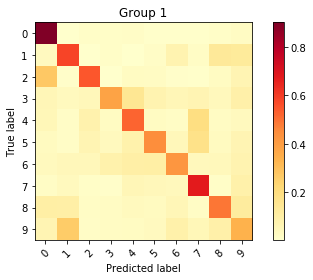

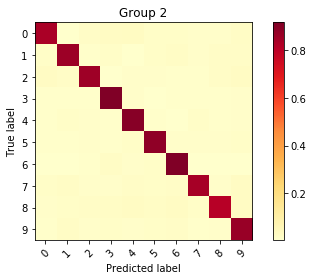

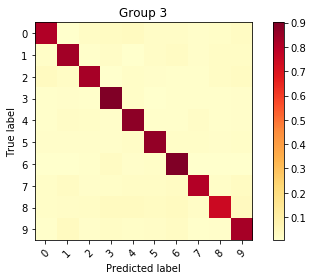

Inertia: 0.047504728000300624
A result
 ====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups       Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.469241       46   1.04658      0.737267   0.321633       0.849216   0.637267      0.7924        0.7924
   1         1  0.391989       39   1.52486      0.531226   0.67099        0.703227   0.431226      0.7739        0.7739
   2         2  0.0748972       7   0.66777      0.867942   0.142336       0.930369   0.767942      0.764         0.764
   3         3  0.0638727       6   0.776411     0.839134   0.176865       0.914005   0.739134      0.7636        0.7636
====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ======

In [33]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 2) configuration: very bad MV ($T$ = 100, $T_{max}$ = 10 )

In [28]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.64792


*** Soft-Majority (Train with softMV) ***
Train


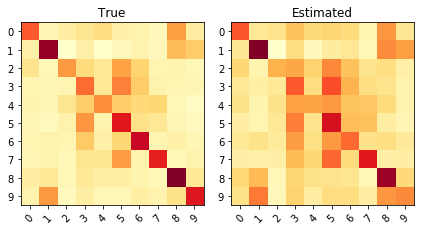

KL divergence: 0.1026	Pearson Correlation between diagonals: 0.8301


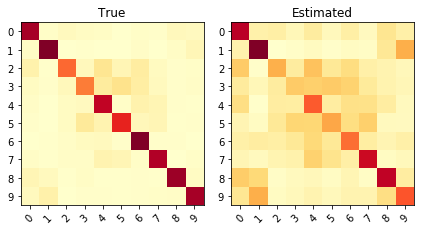

KL divergence: 0.4456	Pearson Correlation between diagonals: 0.8095


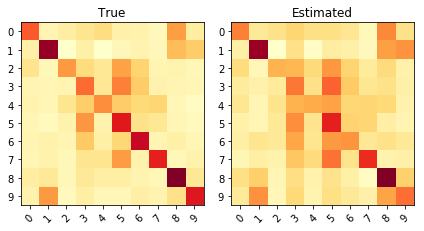

KL divergence: 0.1002	Pearson Correlation between diagonals: 0.8531


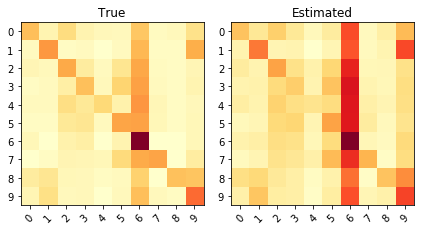

KL divergence: 0.0989	Pearson Correlation between diagonals: 0.9786


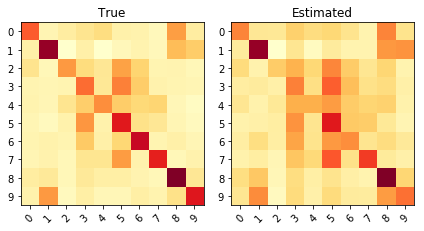

KL divergence: 0.1012	Pearson Correlation between diagonals: 0.8800


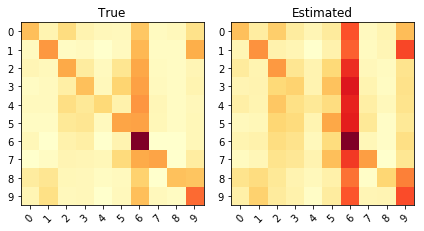

KL divergence: 0.0914	Pearson Correlation between diagonals: 0.9787


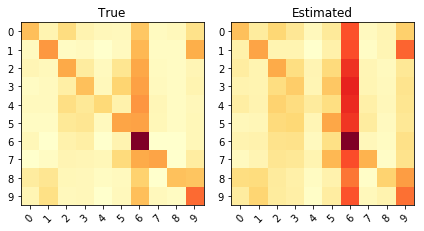

KL divergence: 0.0976	Pearson Correlation between diagonals: 0.9913


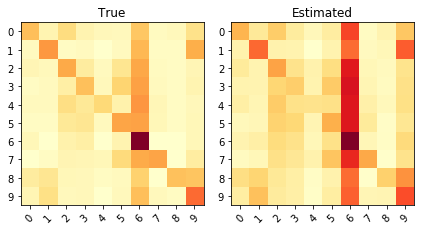

KL divergence: 0.0937	Pearson Correlation between diagonals: 0.9753


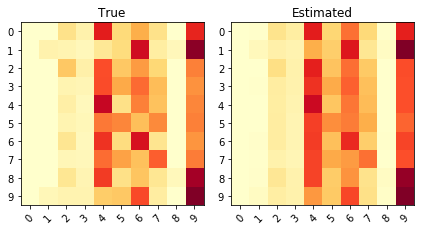

KL divergence: 0.0229	Pearson Correlation between diagonals: 0.9951


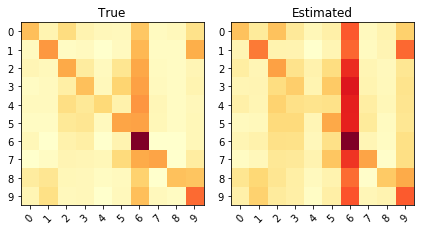

KL divergence: 0.0903	Pearson Correlation between diagonals: 0.9864


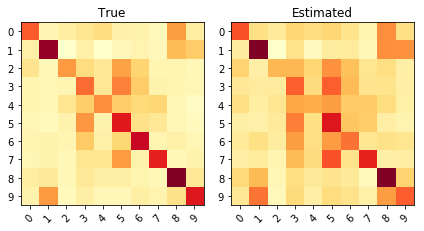

KL divergence: 0.1019	Pearson Correlation between diagonals: 0.8731


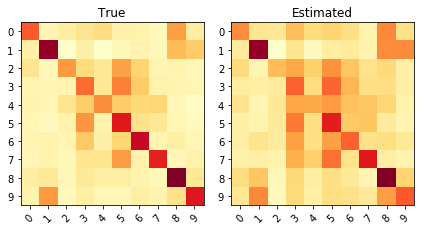

KL divergence: 0.1001	Pearson Correlation between diagonals: 0.9081


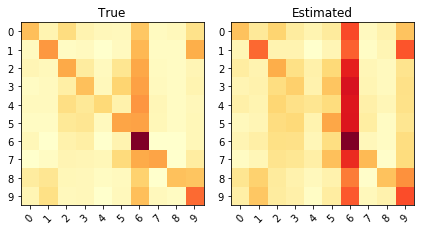

KL divergence: 0.0964	Pearson Correlation between diagonals: 0.9745


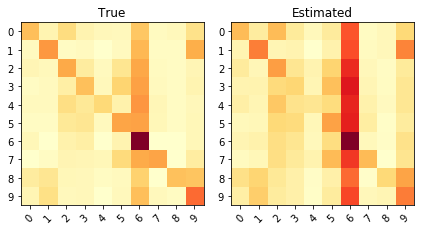

KL divergence: 0.0911	Pearson Correlation between diagonals: 0.9763


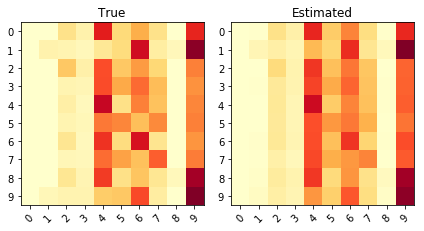

KL divergence: 0.0227	Pearson Correlation between diagonals: 0.9958
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global      0.7337        0.7337   0.115996  0.0302268              0.9273
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.6466        0.6466
====  ======  ==========  ============


In [29]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


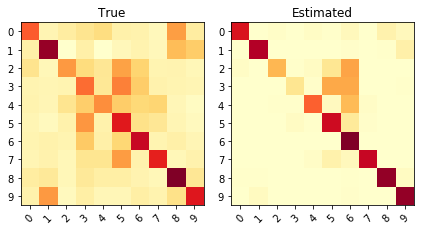

KL divergence: 1.2098	Pearson Correlation between diagonals: 0.7755


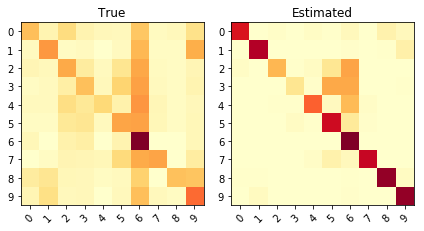

KL divergence: 0.9713	Pearson Correlation between diagonals: 0.4740


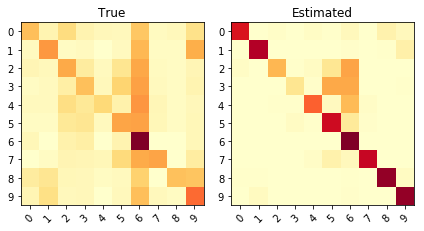

KL divergence: 0.9713	Pearson Correlation between diagonals: 0.4740


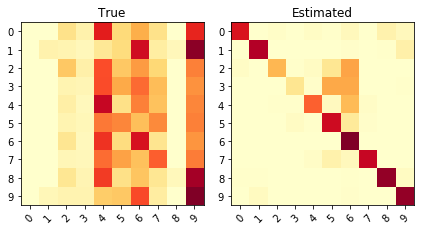

KL divergence: 1.7167	Pearson Correlation between diagonals: 0.3030


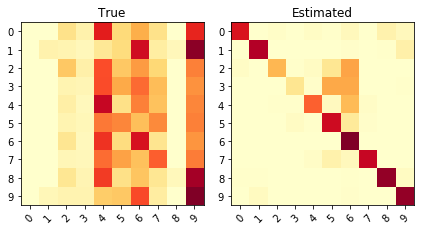

KL divergence: 1.7167	Pearson Correlation between diagonals: 0.3030


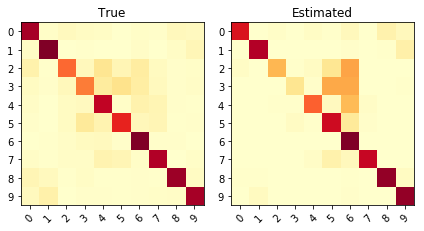

KL divergence: 1.2603	Pearson Correlation between diagonals: 0.8999


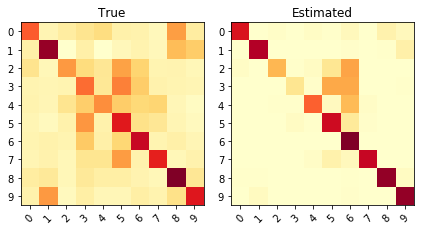

KL divergence: 1.2098	Pearson Correlation between diagonals: 0.7755


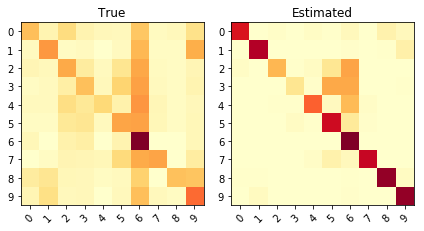

KL divergence: 0.9713	Pearson Correlation between diagonals: 0.4740


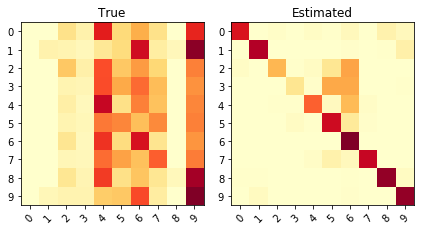

KL divergence: 1.7167	Pearson Correlation between diagonals: 0.3030


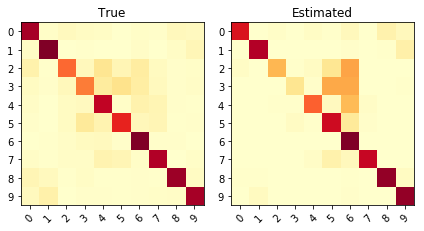

KL divergence: 1.2603	Pearson Correlation between diagonals: 0.8999


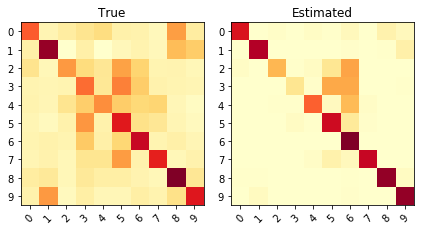

KL divergence: 1.2098	Pearson Correlation between diagonals: 0.7755


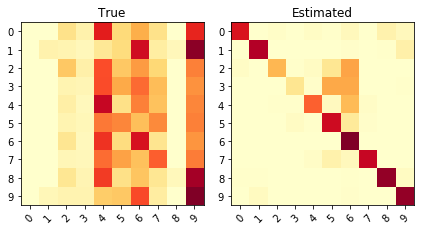

KL divergence: 1.7167	Pearson Correlation between diagonals: 0.3030


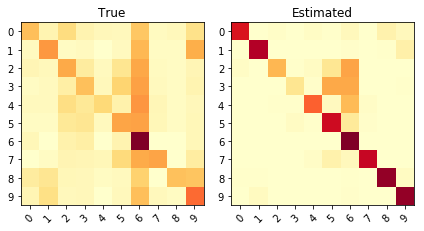

KL divergence: 0.9713	Pearson Correlation between diagonals: 0.4740


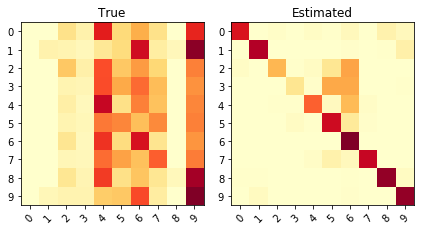

KL divergence: 1.7167	Pearson Correlation between diagonals: 0.3030


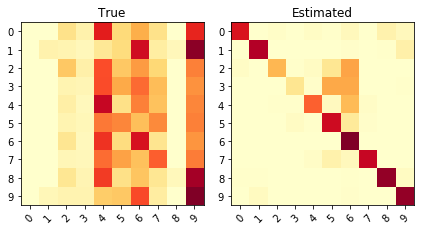

KL divergence: 1.7167	Pearson Correlation between diagonals: 0.3030
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global      0.7337        0.7337    1.20611   0.218534            0.619802
====  ======  ==========  ============  =========  =========  ==================


In [30]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


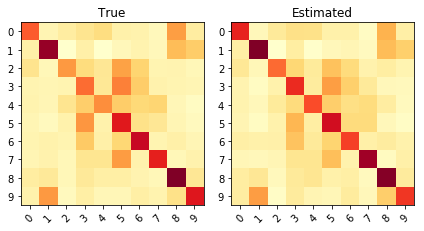

KL divergence: 0.0223	Pearson Correlation between diagonals: 0.7796


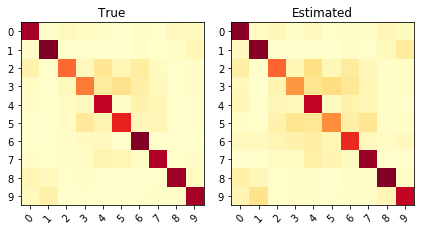

KL divergence: 0.0662	Pearson Correlation between diagonals: 0.8142


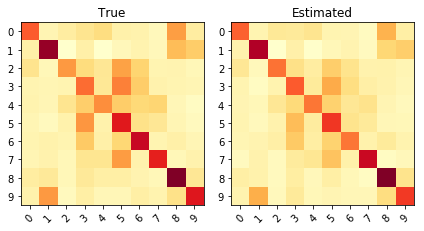

KL divergence: 0.0215	Pearson Correlation between diagonals: 0.7884


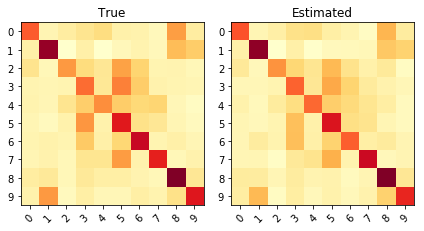

KL divergence: 0.0204	Pearson Correlation between diagonals: 0.8693


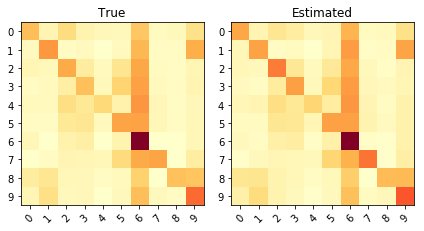

KL divergence: 0.0224	Pearson Correlation between diagonals: 0.9609


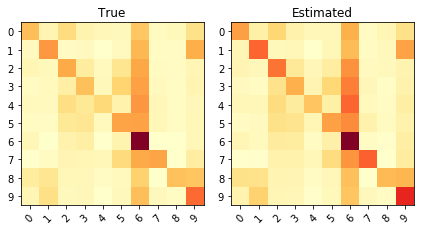

KL divergence: 0.0225	Pearson Correlation between diagonals: 0.9574


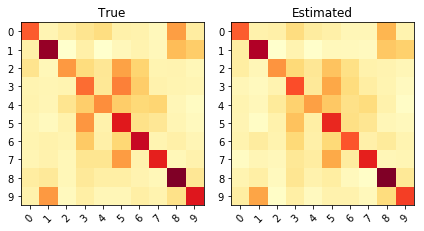

KL divergence: 0.0197	Pearson Correlation between diagonals: 0.9031


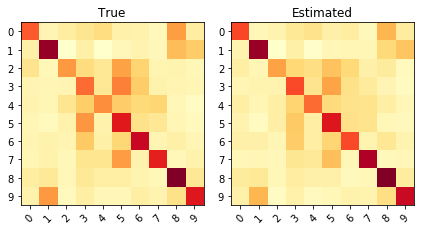

KL divergence: 0.0237	Pearson Correlation between diagonals: 0.8659


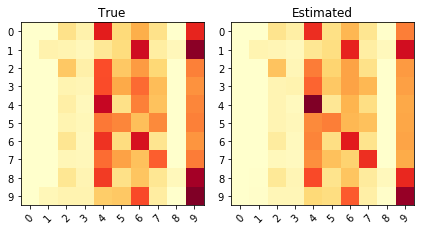

KL divergence: 0.0137	Pearson Correlation between diagonals: 0.9871


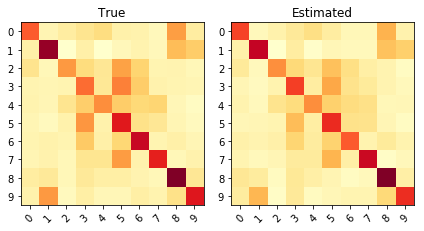

KL divergence: 0.0222	Pearson Correlation between diagonals: 0.8387


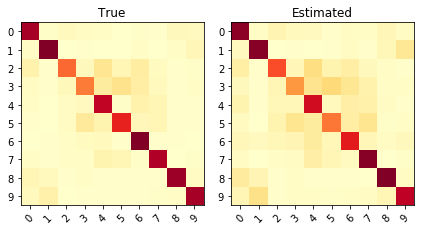

KL divergence: 0.0680	Pearson Correlation between diagonals: 0.8278


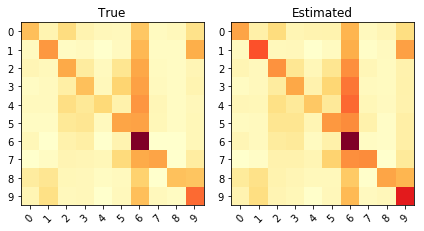

KL divergence: 0.0198	Pearson Correlation between diagonals: 0.9711


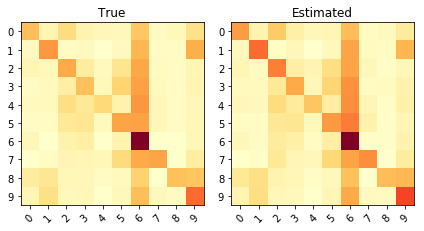

KL divergence: 0.0194	Pearson Correlation between diagonals: 0.9818


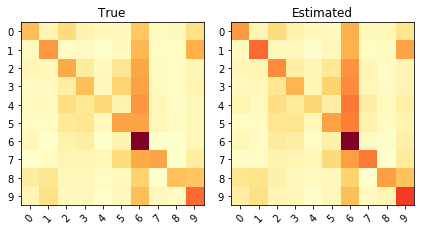

KL divergence: 0.0205	Pearson Correlation between diagonals: 0.9708


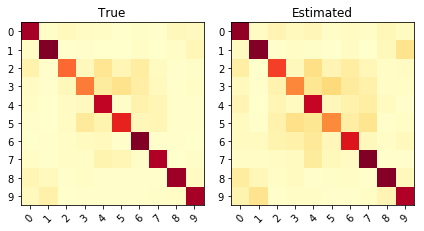

KL divergence: 0.0736	Pearson Correlation between diagonals: 0.8028
A result
 ====  ======  ==========  ============  =========  ==========  ==================
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  ==========  ==================
   0  Global     0.69506       0.69506  0.0236947  0.00643257            0.916895
====  ======  ==========  ============  =========  ==========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.6615        0.6615
====  ======  ==========  ============


In [31]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


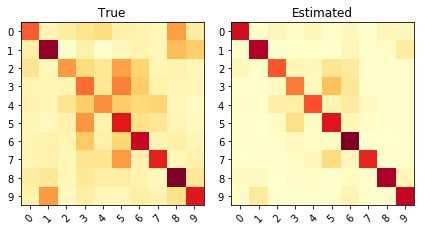

KL divergence: 0.4299	Pearson Correlation between diagonals: 0.8150


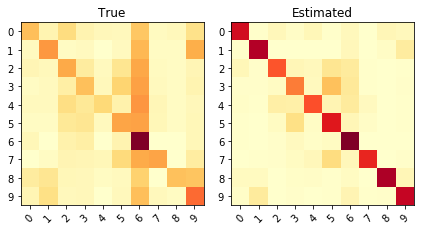

KL divergence: 0.5650	Pearson Correlation between diagonals: 0.6514


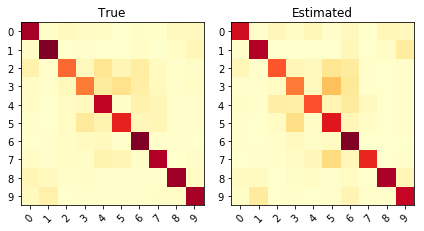

KL divergence: 1.3257	Pearson Correlation between diagonals: 0.8402


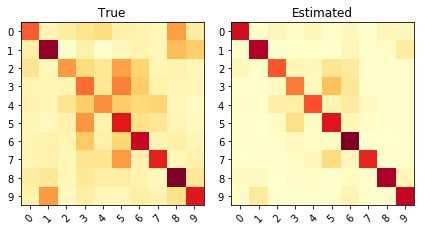

KL divergence: 0.4299	Pearson Correlation between diagonals: 0.8150


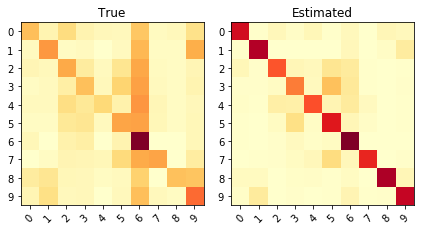

KL divergence: 0.5650	Pearson Correlation between diagonals: 0.6514


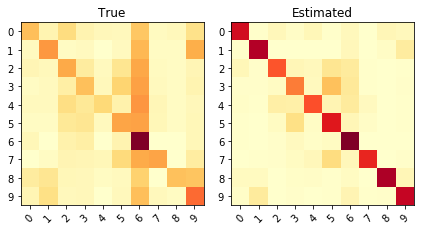

KL divergence: 0.5650	Pearson Correlation between diagonals: 0.6514


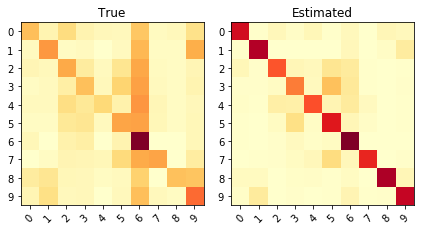

KL divergence: 0.5650	Pearson Correlation between diagonals: 0.6514


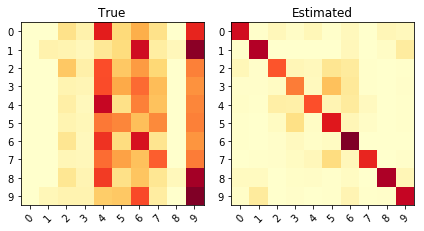

KL divergence: 0.5892	Pearson Correlation between diagonals: 0.1132


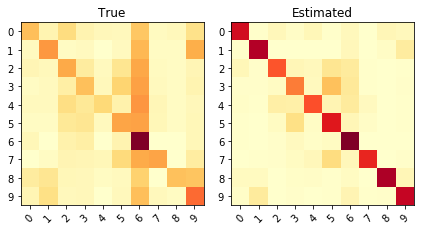

KL divergence: 0.5650	Pearson Correlation between diagonals: 0.6514


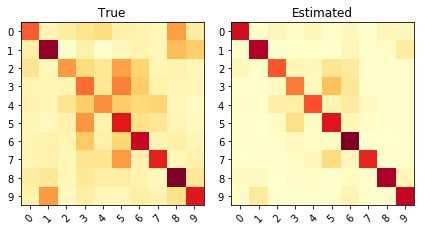

KL divergence: 0.4299	Pearson Correlation between diagonals: 0.8150


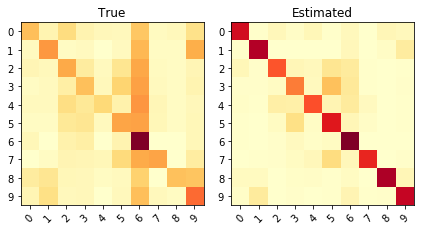

KL divergence: 0.5650	Pearson Correlation between diagonals: 0.6514


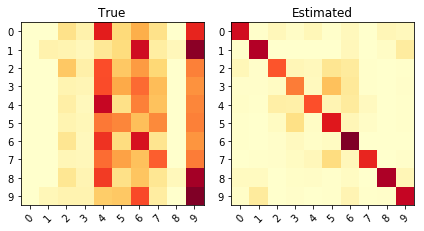

KL divergence: 0.5892	Pearson Correlation between diagonals: 0.1132


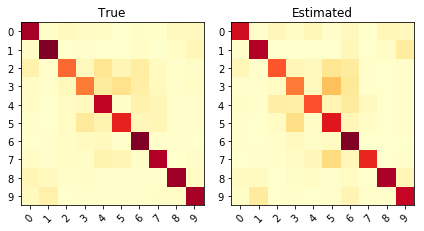

KL divergence: 1.3257	Pearson Correlation between diagonals: 0.8402


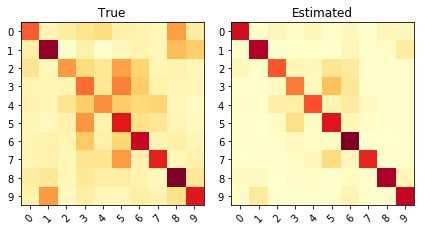

KL divergence: 0.4299	Pearson Correlation between diagonals: 0.8150


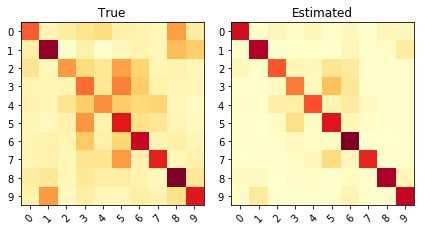

KL divergence: 0.4299	Pearson Correlation between diagonals: 0.8150
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.69506       0.69506   0.568468   0.227886            0.664782
====  ======  ==========  ============  =========  =========  ==================


In [32]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


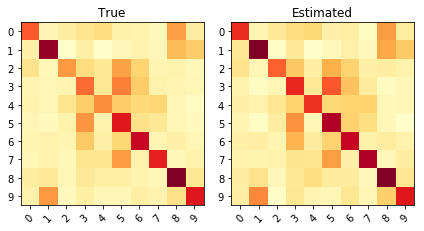

KL divergence: 0.0189	Pearson Correlation between diagonals: 0.9310


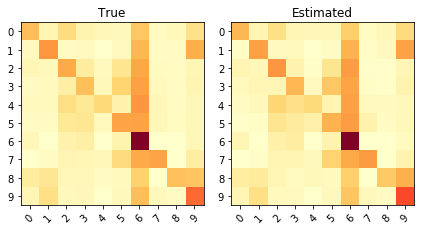

KL divergence: 0.0194	Pearson Correlation between diagonals: 0.9836


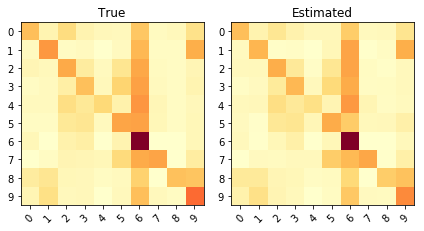

KL divergence: 0.0184	Pearson Correlation between diagonals: 0.9852


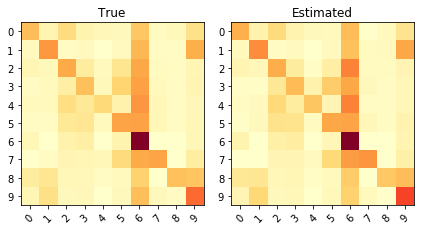

KL divergence: 0.0212	Pearson Correlation between diagonals: 0.9855


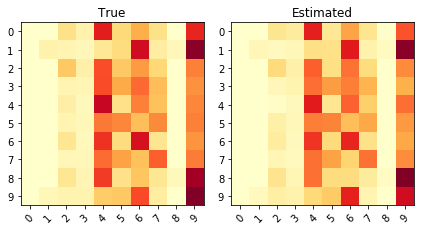

KL divergence: 0.0137	Pearson Correlation between diagonals: 0.9933


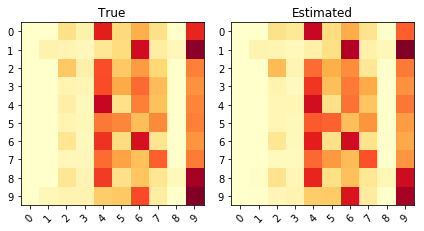

KL divergence: 0.0113	Pearson Correlation between diagonals: 0.9938


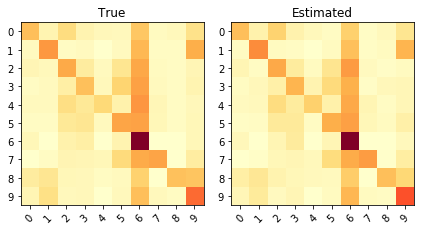

KL divergence: 0.0137	Pearson Correlation between diagonals: 0.9935


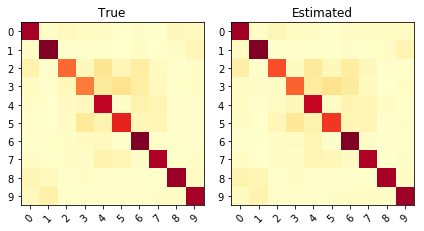

KL divergence: 0.0165	Pearson Correlation between diagonals: 0.9846


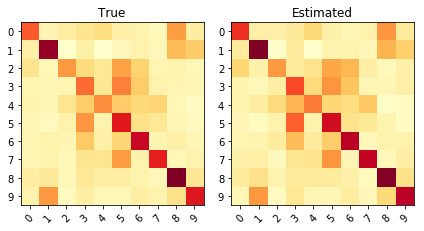

KL divergence: 0.0171	Pearson Correlation between diagonals: 0.9732


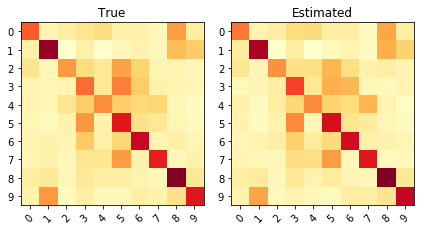

KL divergence: 0.0134	Pearson Correlation between diagonals: 0.9649


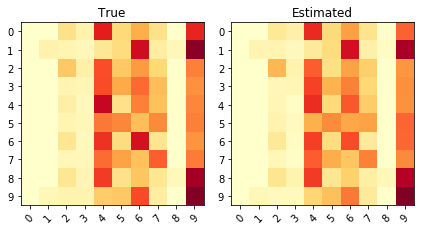

KL divergence: 0.0114	Pearson Correlation between diagonals: 0.9868


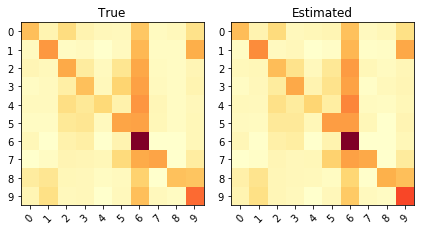

KL divergence: 0.0161	Pearson Correlation between diagonals: 0.9804


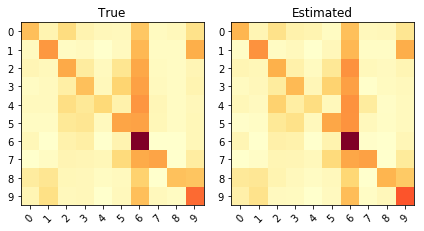

KL divergence: 0.0181	Pearson Correlation between diagonals: 0.9933


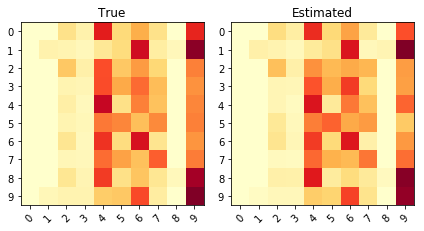

KL divergence: 0.0159	Pearson Correlation between diagonals: 0.9950


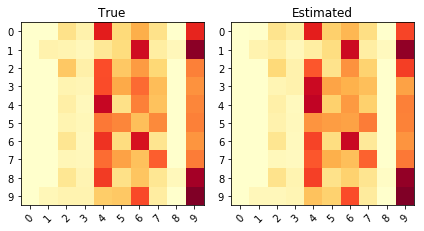

KL divergence: 0.0101	Pearson Correlation between diagonals: 0.9959
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.85014       0.85014  0.0173186  0.0039099             0.97567
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.7635        0.7635
====  ======  ==========  ============


In [33]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


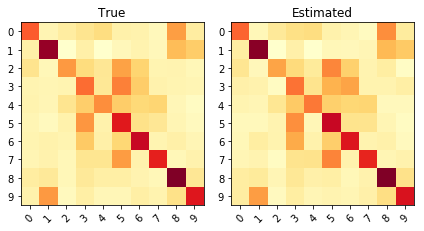

KL divergence: 0.0133	Pearson Correlation between diagonals: 0.9747


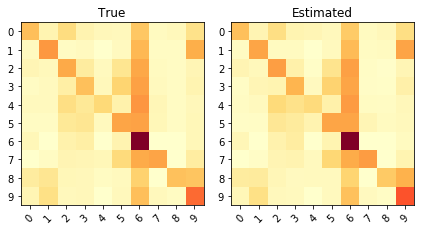

KL divergence: 0.0126	Pearson Correlation between diagonals: 0.9897


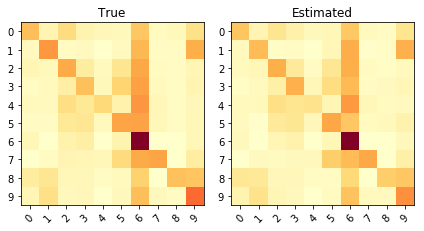

KL divergence: 0.0166	Pearson Correlation between diagonals: 0.9772


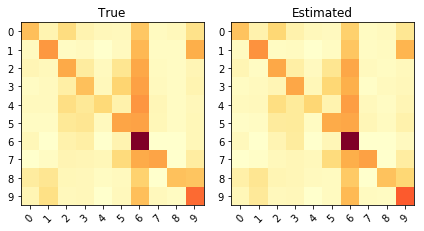

KL divergence: 0.0118	Pearson Correlation between diagonals: 0.9909


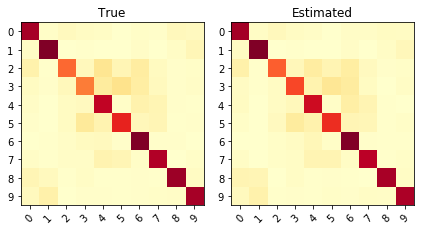

KL divergence: 0.0101	Pearson Correlation between diagonals: 0.9745


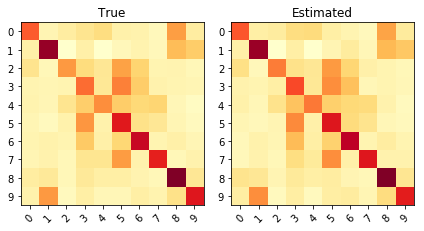

KL divergence: 0.0076	Pearson Correlation between diagonals: 0.9908


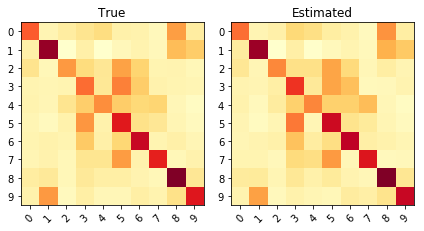

KL divergence: 0.0105	Pearson Correlation between diagonals: 0.9676


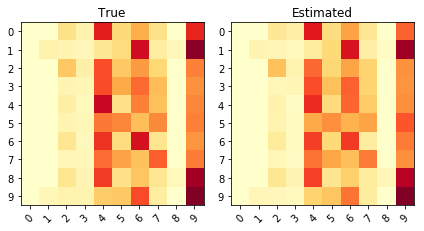

KL divergence: 0.0120	Pearson Correlation between diagonals: 0.9919


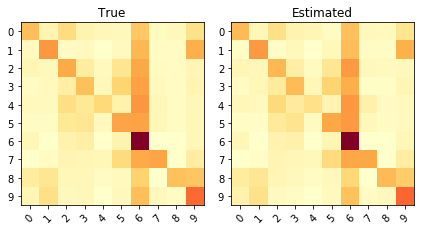

KL divergence: 0.0098	Pearson Correlation between diagonals: 0.9940


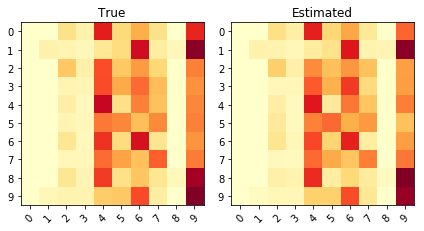

KL divergence: 0.0160	Pearson Correlation between diagonals: 0.9953


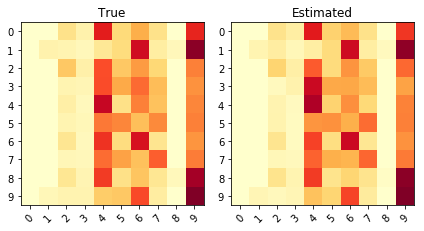

KL divergence: 0.0133	Pearson Correlation between diagonals: 0.9973


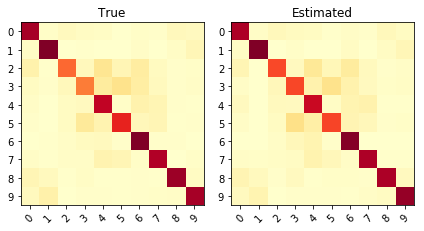

KL divergence: 0.0149	Pearson Correlation between diagonals: 0.9512


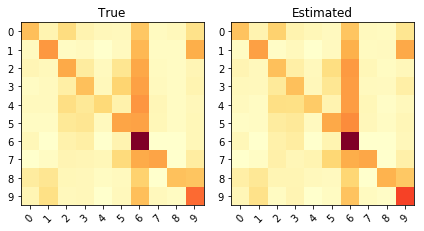

KL divergence: 0.0135	Pearson Correlation between diagonals: 0.9789


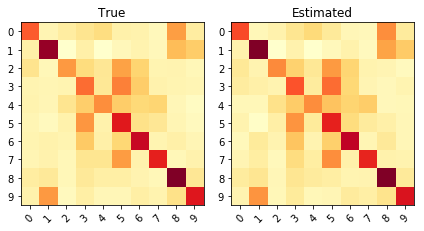

KL divergence: 0.0111	Pearson Correlation between diagonals: 0.9906


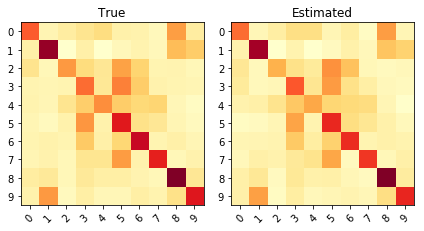

KL divergence: 0.0140	Pearson Correlation between diagonals: 0.9694
A result
 ====  ======  ==========  ============  =========  ==========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  ==========  ==================  ==============
   0  Global      0.8306        0.8306    0.01203  0.00313822            0.981699       0.0420443
====  ======  ==========  ============  =========  ==========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.362311                 1.77246
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.

In [34]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


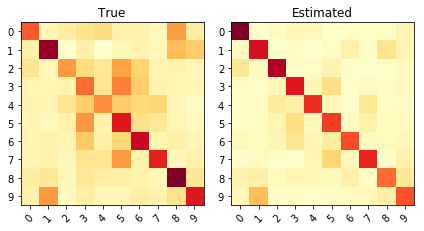

KL divergence: 0.3404	Pearson Correlation between diagonals: -0.5527


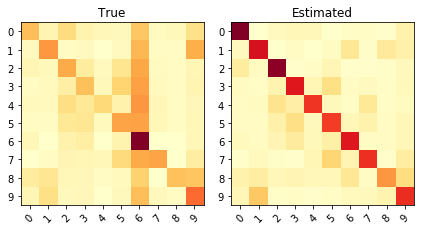

KL divergence: 0.5683	Pearson Correlation between diagonals: 0.0536


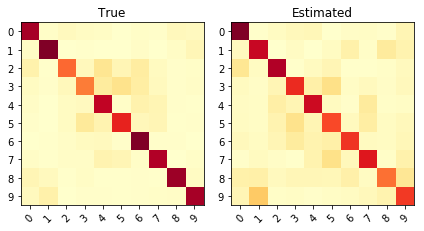

KL divergence: 0.2141	Pearson Correlation between diagonals: -0.0711


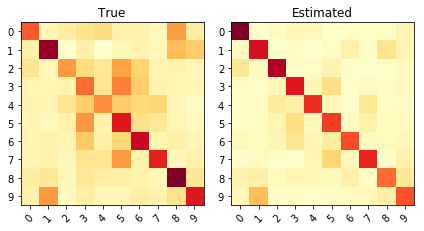

KL divergence: 0.3404	Pearson Correlation between diagonals: -0.5527


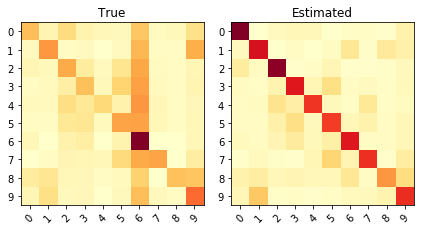

KL divergence: 0.5683	Pearson Correlation between diagonals: 0.0536


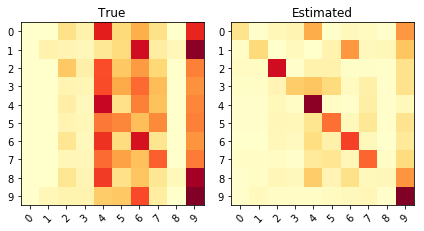

KL divergence: 0.4532	Pearson Correlation between diagonals: 0.8817


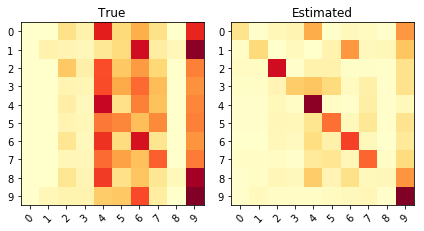

KL divergence: 0.4532	Pearson Correlation between diagonals: 0.8817


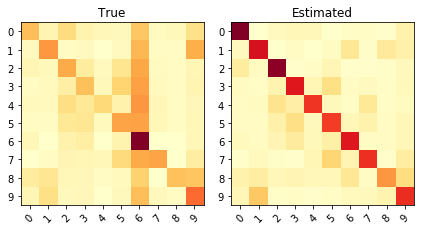

KL divergence: 0.5683	Pearson Correlation between diagonals: 0.0536


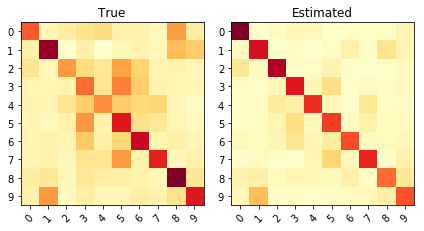

KL divergence: 0.3404	Pearson Correlation between diagonals: -0.5527


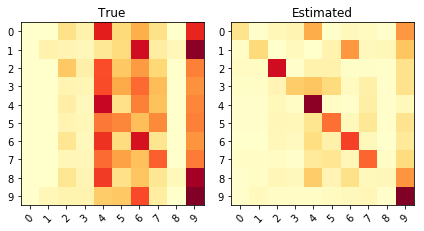

KL divergence: 0.4532	Pearson Correlation between diagonals: 0.8817


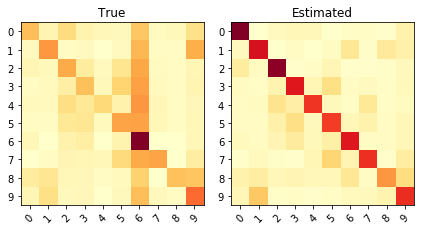

KL divergence: 0.5683	Pearson Correlation between diagonals: 0.0536


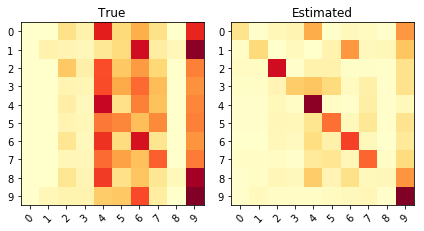

KL divergence: 0.4532	Pearson Correlation between diagonals: 0.8817


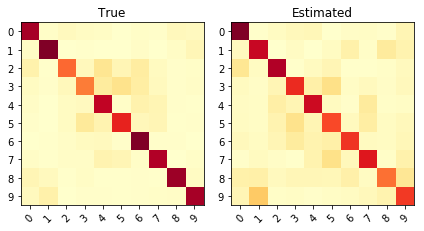

KL divergence: 0.2141	Pearson Correlation between diagonals: -0.0711


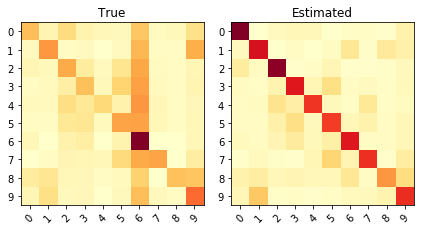

KL divergence: 0.5683	Pearson Correlation between diagonals: 0.0536


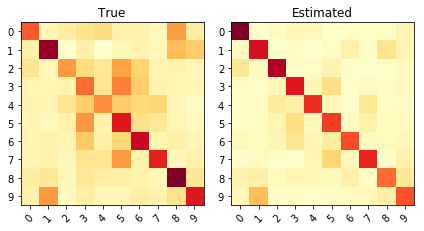

KL divergence: 0.3404	Pearson Correlation between diagonals: -0.5527
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global      0.7374        0.7374   0.421299  0.0785778           -0.113281       0.0320025
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.363928                 1.82554
====  =======================  ======================
Test


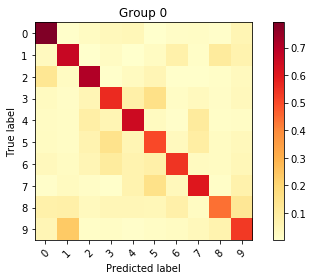

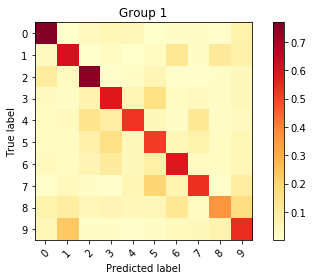

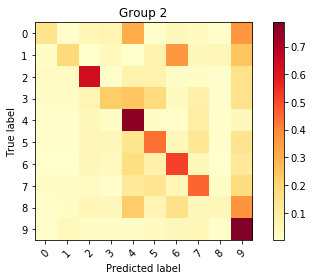

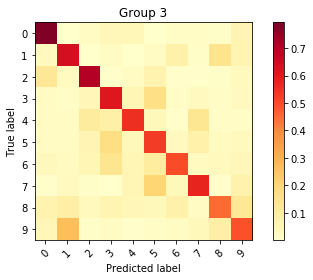

Inertia: 0.05040133614481116
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.238282      23    1.39624     0.600767   0.523214       0.760413   0.500767      0.7467        0.7467
   1         1  0.289336      28    1.43254     0.577405   0.568707       0.742365   0.477405      0.7172        0.7172
   2         2  0.134411      13    1.50003     0.420322   1.14833        0.577639   0.320322      0.4772        0.4772
   3         3  0.33797       33    1.41388     0.58382    0.55205        0.748275   0.48382       0.7539        0.7539
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A

In [35]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


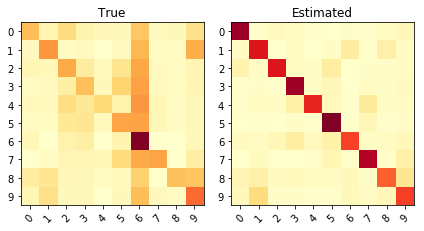

KL divergence: 1.0616	Pearson Correlation between diagonals: -0.3561


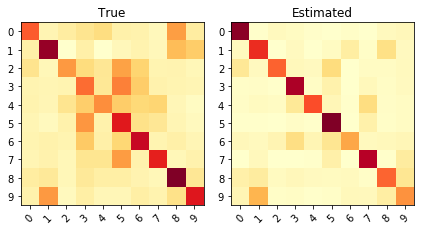

KL divergence: 0.5130	Pearson Correlation between diagonals: -0.2264


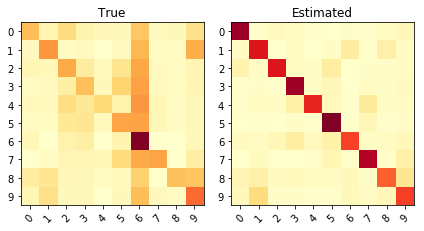

KL divergence: 1.0616	Pearson Correlation between diagonals: -0.3561


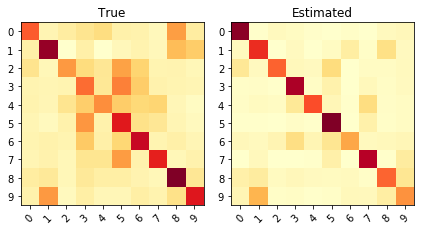

KL divergence: 0.5130	Pearson Correlation between diagonals: -0.2264


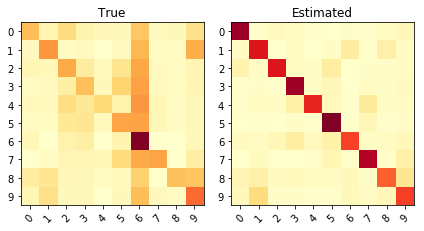

KL divergence: 1.0616	Pearson Correlation between diagonals: -0.3561


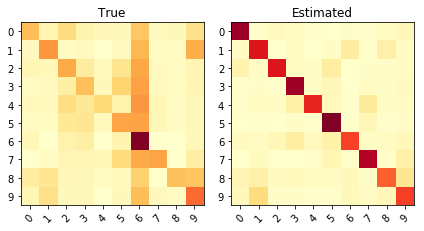

KL divergence: 1.0616	Pearson Correlation between diagonals: -0.3561


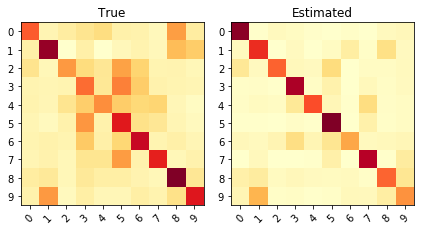

KL divergence: 0.5130	Pearson Correlation between diagonals: -0.2264


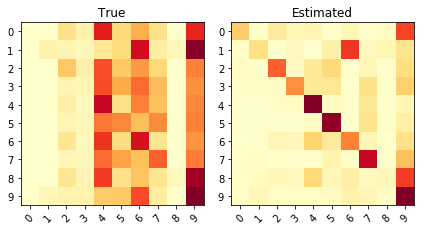

KL divergence: 0.6999	Pearson Correlation between diagonals: 0.8176


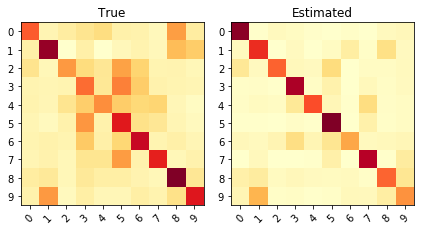

KL divergence: 0.5130	Pearson Correlation between diagonals: -0.2264


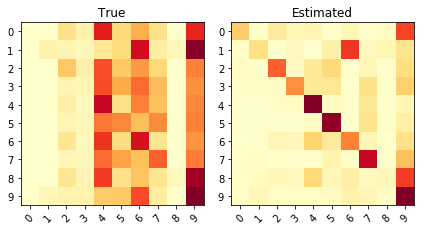

KL divergence: 0.6999	Pearson Correlation between diagonals: 0.8176


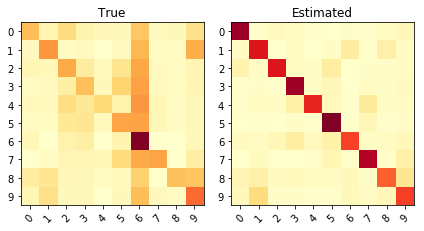

KL divergence: 1.0616	Pearson Correlation between diagonals: -0.3561


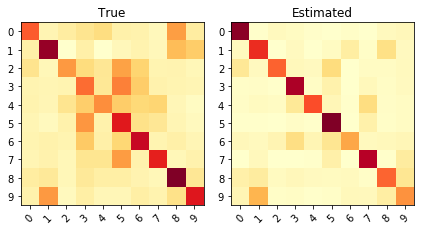

KL divergence: 0.5130	Pearson Correlation between diagonals: -0.2264


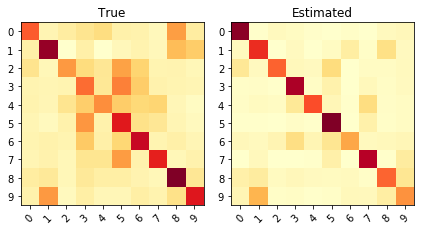

KL divergence: 0.5130	Pearson Correlation between diagonals: -0.2264


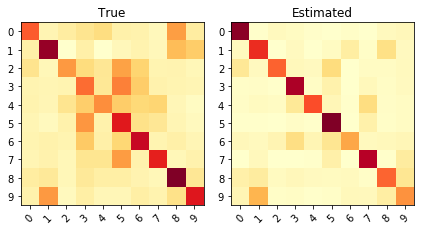

KL divergence: 0.5130	Pearson Correlation between diagonals: -0.2264


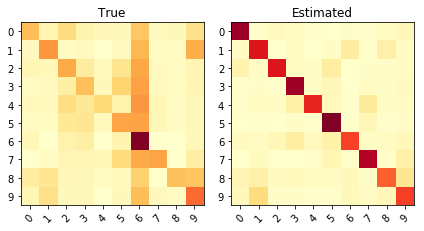

KL divergence: 1.0616	Pearson Correlation between diagonals: -0.3561
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global      0.6207        0.6207   0.700682   0.111706           -0.134835       0.0348903
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.370462                 1.81062
====  =======================  ======================
Test


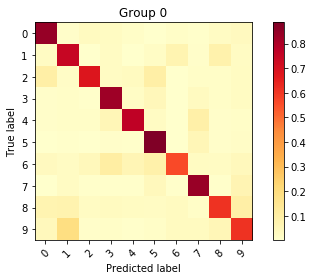

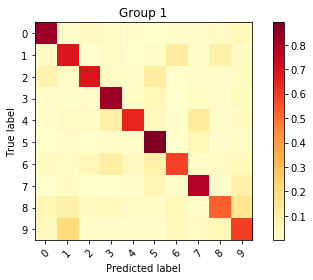

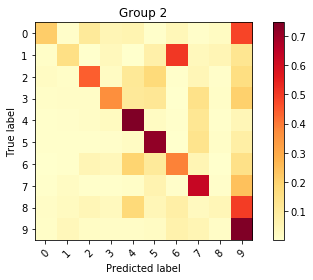

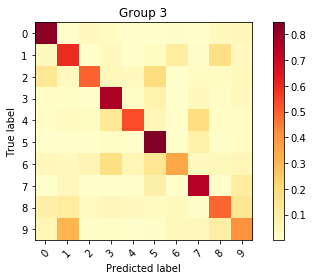

Inertia: 0.05967068419946978
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.221254      22    1.03016     0.737744   0.315529       0.851119   0.637744      0.7051        0.7051
   1         1  0.276479      27    1.09635     0.707429   0.360402       0.831317   0.607429      0.6784        0.6784
   2         2  0.141442      14    1.3968      0.44516    1.06145        0.602652   0.34516       0.4811        0.4811
   3         3  0.360825      36    1.29462     0.605902   0.5426         0.756727   0.505902      0.7532        0.7532
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A

In [36]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


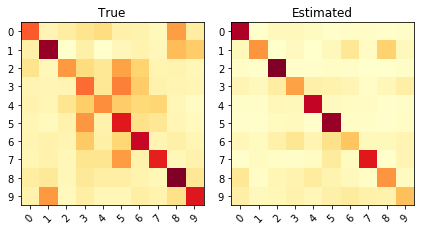

KL divergence: 0.4876	Pearson Correlation between diagonals: -0.5875


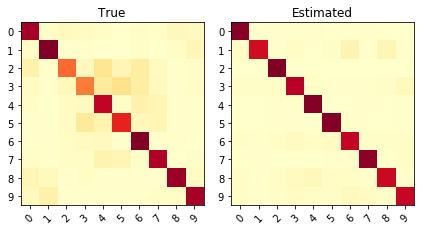

KL divergence: 0.4361	Pearson Correlation between diagonals: -0.4390


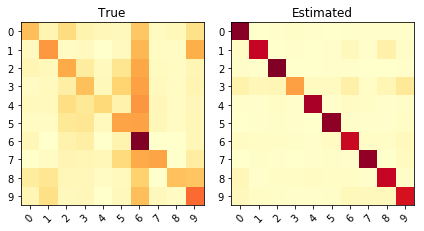

KL divergence: 1.1387	Pearson Correlation between diagonals: -0.0258


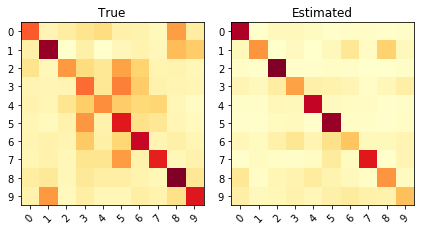

KL divergence: 0.4876	Pearson Correlation between diagonals: -0.5875


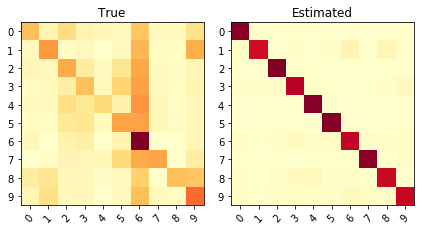

KL divergence: 1.6211	Pearson Correlation between diagonals: -0.4096


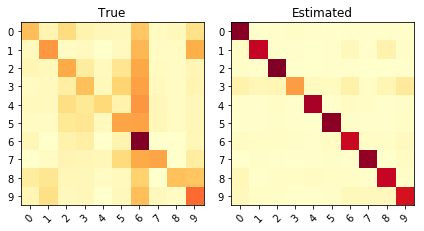

KL divergence: 1.1428	Pearson Correlation between diagonals: -0.0290


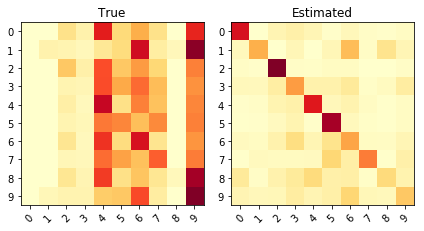

KL divergence: 0.9469	Pearson Correlation between diagonals: -0.0204


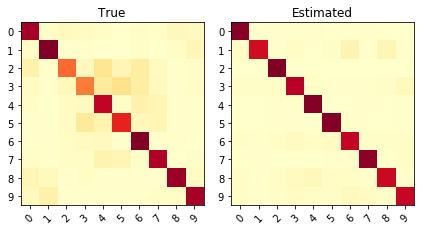

KL divergence: 0.4361	Pearson Correlation between diagonals: -0.4390


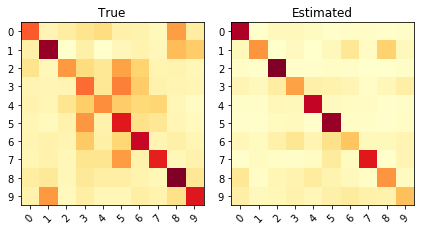

KL divergence: 0.4876	Pearson Correlation between diagonals: -0.5875


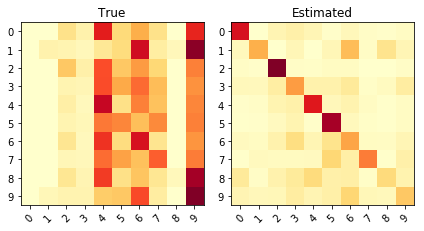

KL divergence: 0.9469	Pearson Correlation between diagonals: -0.0204


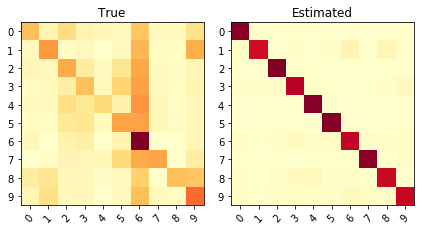

KL divergence: 1.6211	Pearson Correlation between diagonals: -0.4096


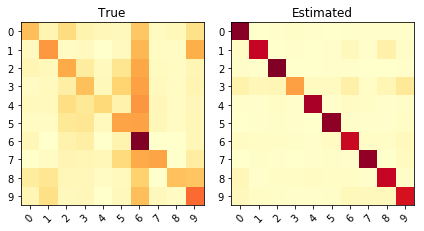

KL divergence: 1.1389	Pearson Correlation between diagonals: -0.0260


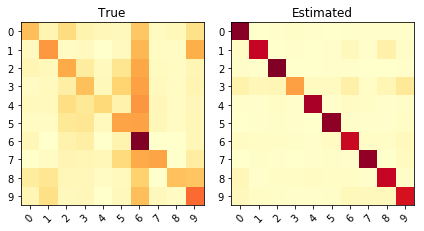

KL divergence: 1.1387	Pearson Correlation between diagonals: -0.0258


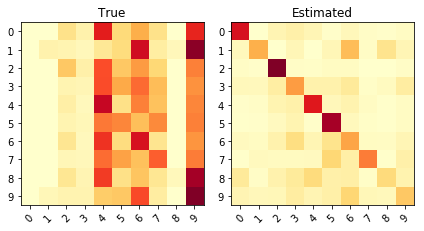

KL divergence: 0.9469	Pearson Correlation between diagonals: -0.0204


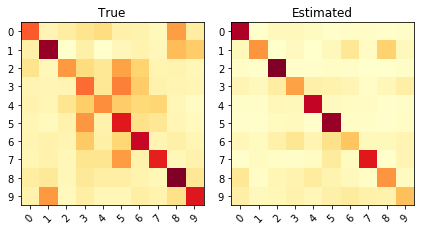

KL divergence: 0.4876	Pearson Correlation between diagonals: -0.5875
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.72746       0.72746   0.849525   0.151294           -0.380476        0.022722
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.354301                 1.89369
====  =======================  ======================
Test


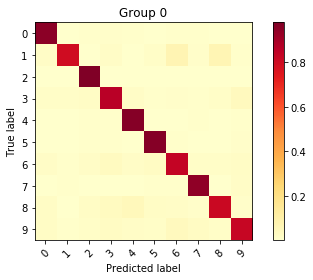

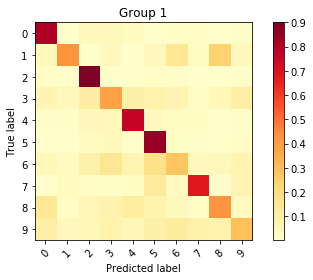

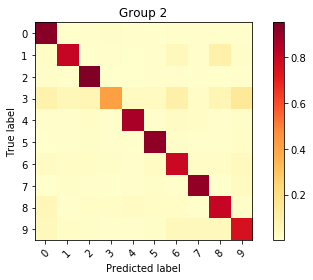

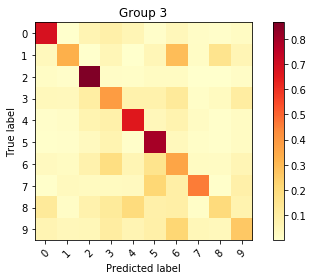

Inertia: 0.06296959131335218
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.441858      44   0.514393     0.894935   0.114063       0.94433    0.794935      0.6845        0.6845
   1         1  0.164275      16   1.39282      0.582016   0.628147       0.728898   0.482016      0.7044        0.7044
   2         2  0.210143      21   0.783456     0.815892   0.22623        0.894571   0.715891      0.6469        0.6469
   3         3  0.183724      18   1.53666      0.500251   0.797325       0.665133   0.400251      0.4125        0.4125
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A

In [37]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 3) configuration: normal soft ($T$ = 100, $T_{max}$ = 10, soft clustering )

In [24]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.74872


*** Soft-Majority (Train with softMV) ***
Train


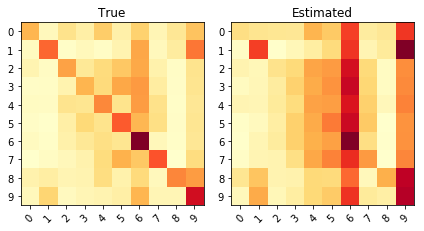

KL divergence: 0.1079	Pearson Correlation between diagonals: 0.9526


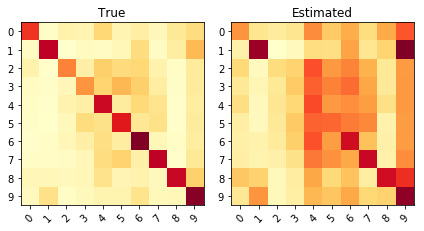

KL divergence: 0.2284	Pearson Correlation between diagonals: 0.9304


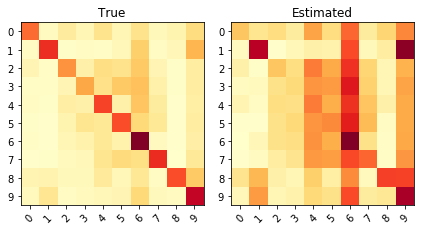

KL divergence: 0.2080	Pearson Correlation between diagonals: 0.9166


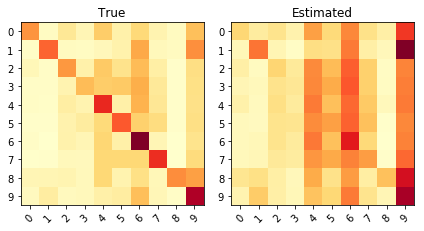

KL divergence: 0.1704	Pearson Correlation between diagonals: 0.9271


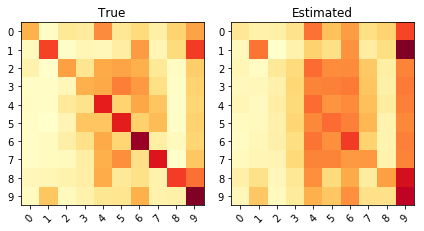

KL divergence: 0.0922	Pearson Correlation between diagonals: 0.9501


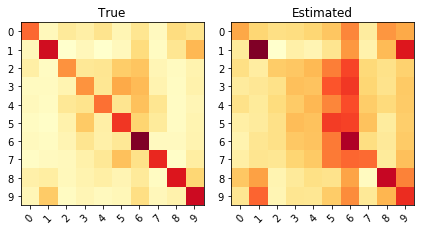

KL divergence: 0.1824	Pearson Correlation between diagonals: 0.9008


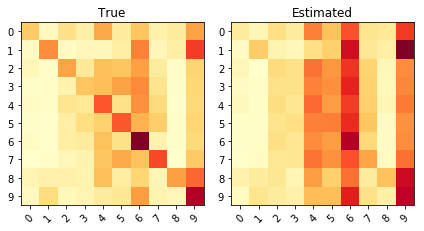

KL divergence: 0.0825	Pearson Correlation between diagonals: 0.9735


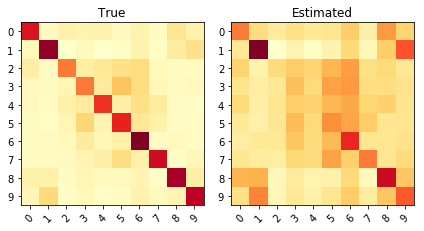

KL divergence: 0.3415	Pearson Correlation between diagonals: 0.8837


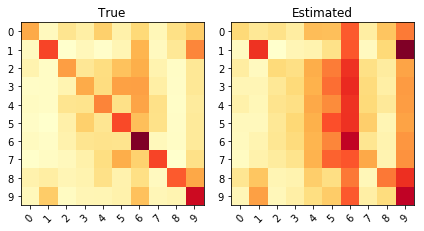

KL divergence: 0.1156	Pearson Correlation between diagonals: 0.9220


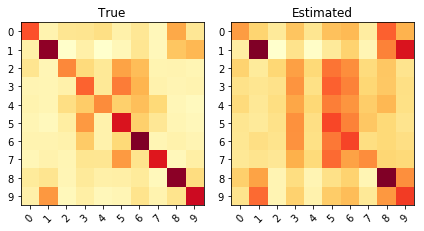

KL divergence: 0.1769	Pearson Correlation between diagonals: 0.8952


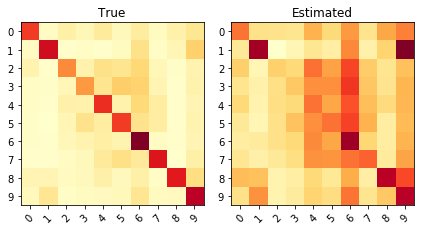

KL divergence: 0.2835	Pearson Correlation between diagonals: 0.9050


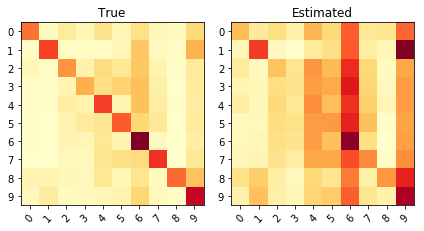

KL divergence: 0.2239	Pearson Correlation between diagonals: 0.9582


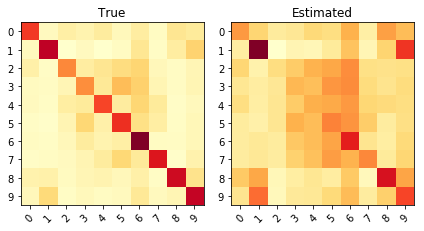

KL divergence: 0.2514	Pearson Correlation between diagonals: 0.8406


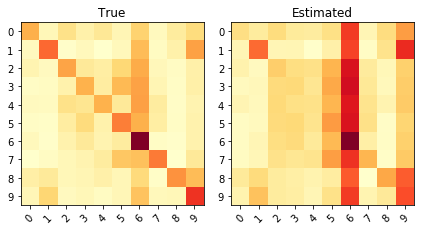

KL divergence: 0.1298	Pearson Correlation between diagonals: 0.9840


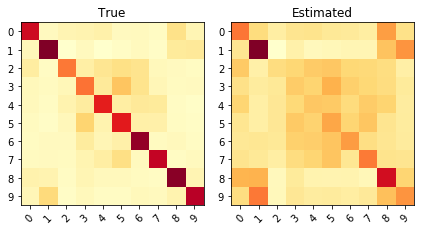

KL divergence: 0.4014	Pearson Correlation between diagonals: 0.8142
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.38434       0.38434   0.223482  0.0533009            0.907651
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.3774        0.3774
====  ======  ==========  ============


In [25]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


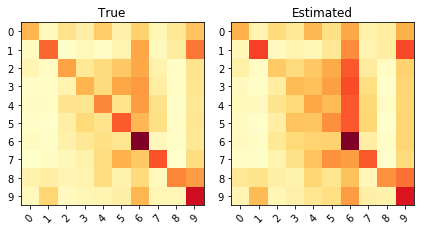

KL divergence: 0.0301	Pearson Correlation between diagonals: 0.9589


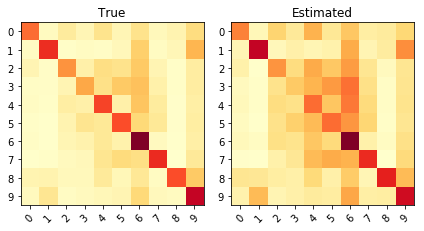

KL divergence: 0.0622	Pearson Correlation between diagonals: 0.9231


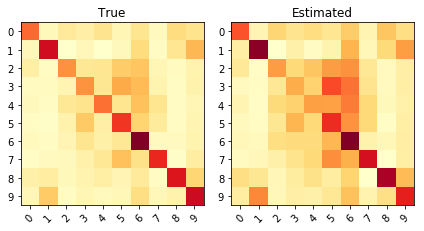

KL divergence: 0.0489	Pearson Correlation between diagonals: 0.9184


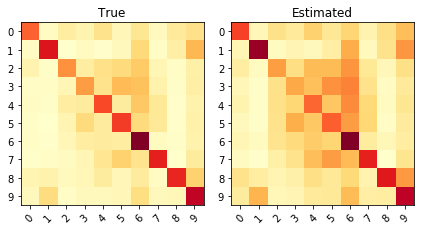

KL divergence: 0.0509	Pearson Correlation between diagonals: 0.9368


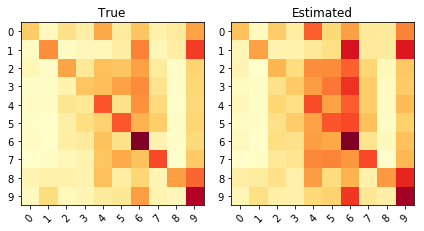

KL divergence: 0.0259	Pearson Correlation between diagonals: 0.9911


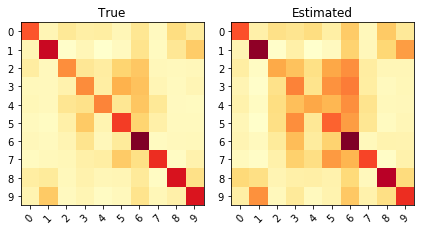

KL divergence: 0.0632	Pearson Correlation between diagonals: 0.9400


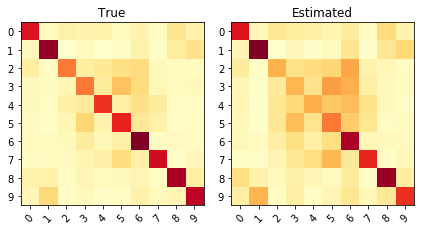

KL divergence: 0.0951	Pearson Correlation between diagonals: 0.9321


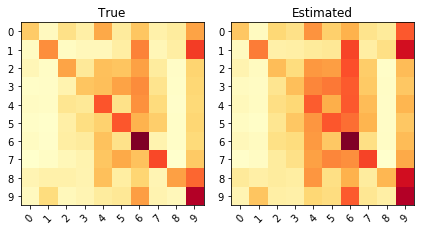

KL divergence: 0.0244	Pearson Correlation between diagonals: 0.9869


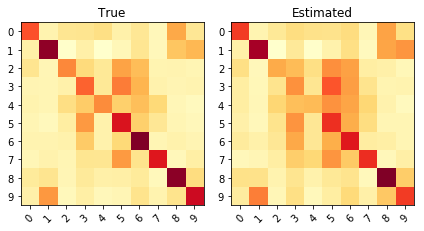

KL divergence: 0.0469	Pearson Correlation between diagonals: 0.9095


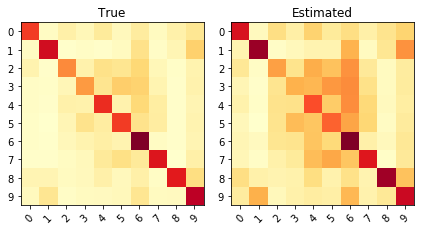

KL divergence: 0.0830	Pearson Correlation between diagonals: 0.8988


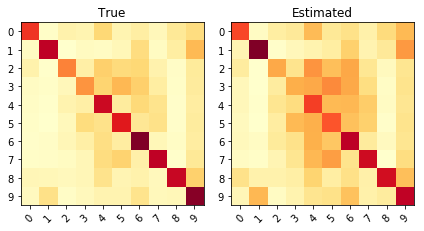

KL divergence: 0.0663	Pearson Correlation between diagonals: 0.9045


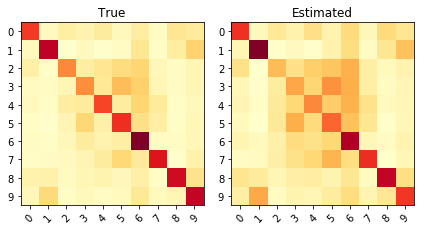

KL divergence: 0.0632	Pearson Correlation between diagonals: 0.8942


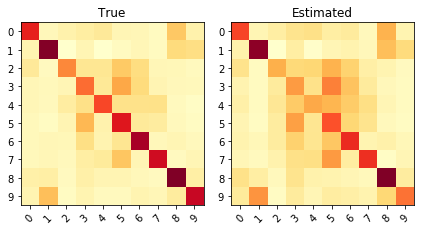

KL divergence: 0.0734	Pearson Correlation between diagonals: 0.9154


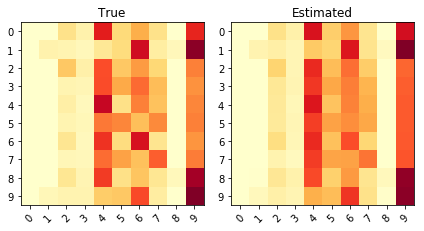

KL divergence: 0.0157	Pearson Correlation between diagonals: 0.9931


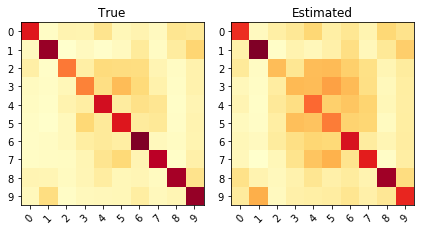

KL divergence: 0.0841	Pearson Correlation between diagonals: 0.8860
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.68952       0.68952  0.0650525  0.0162586            0.928238
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.6694        0.6694
====  ======  ==========  ============


In [26]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


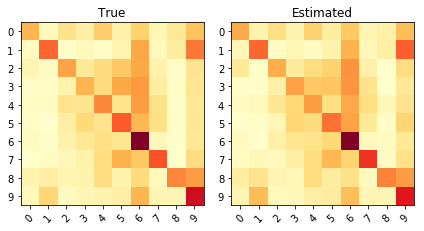

KL divergence: 0.0163	Pearson Correlation between diagonals: 0.9692


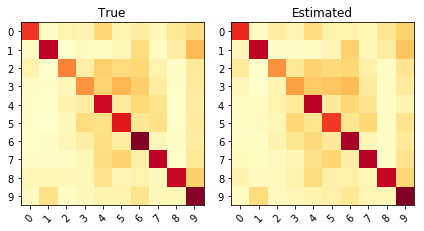

KL divergence: 0.0104	Pearson Correlation between diagonals: 0.9695


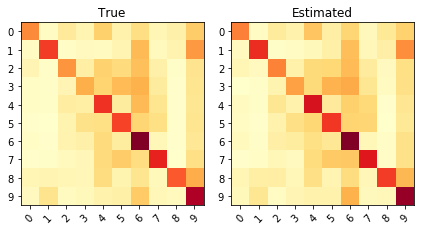

KL divergence: 0.0109	Pearson Correlation between diagonals: 0.9912


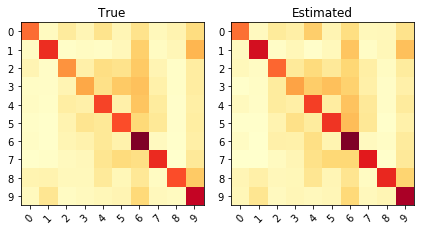

KL divergence: 0.0139	Pearson Correlation between diagonals: 0.9711


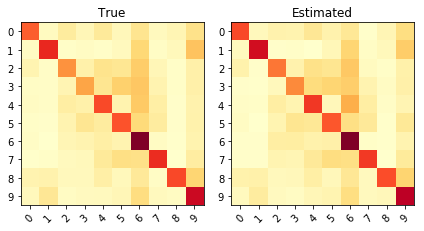

KL divergence: 0.0157	Pearson Correlation between diagonals: 0.9672


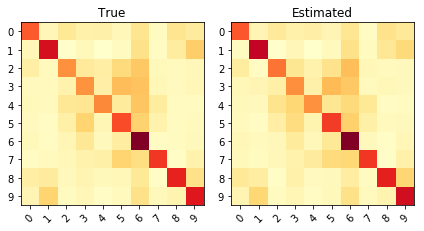

KL divergence: 0.0117	Pearson Correlation between diagonals: 0.9852


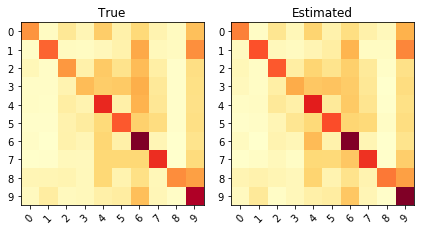

KL divergence: 0.0135	Pearson Correlation between diagonals: 0.9748


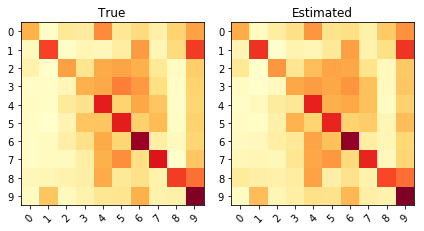

KL divergence: 0.0113	Pearson Correlation between diagonals: 0.9927


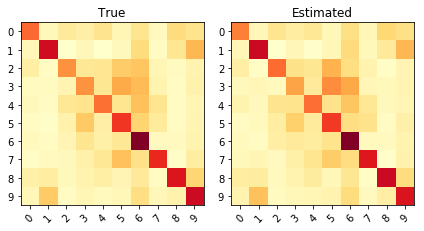

KL divergence: 0.0125	Pearson Correlation between diagonals: 0.9633


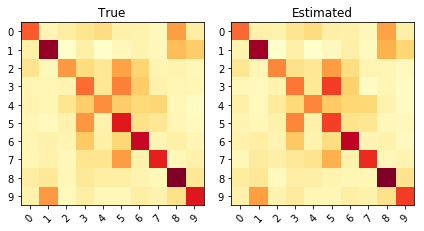

KL divergence: 0.0123	Pearson Correlation between diagonals: 0.9657


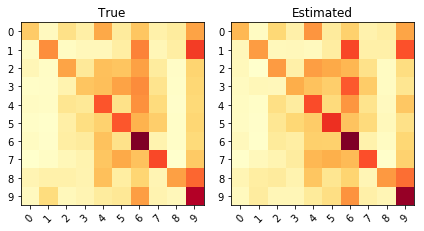

KL divergence: 0.0186	Pearson Correlation between diagonals: 0.9825


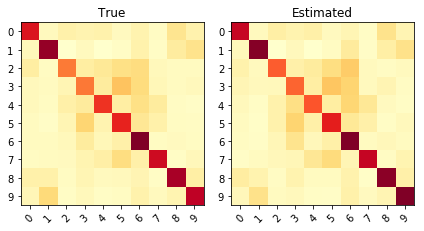

KL divergence: 0.0137	Pearson Correlation between diagonals: 0.9485


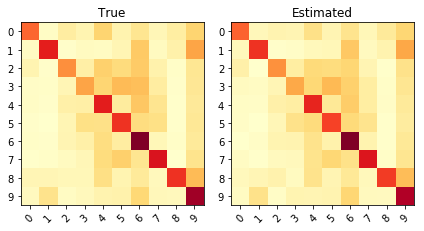

KL divergence: 0.0090	Pearson Correlation between diagonals: 0.9945


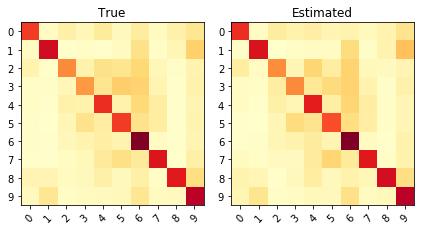

KL divergence: 0.0141	Pearson Correlation between diagonals: 0.9774


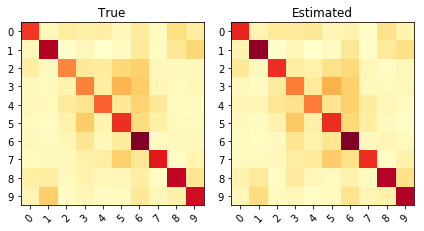

KL divergence: 0.0151	Pearson Correlation between diagonals: 0.9073
A result
 ====  ======  ==========  ============  =========  ==========  ==================
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  ==========  ==================
   0  Global     0.75908       0.75908  0.0143272  0.00338183            0.963204
====  ======  ==========  ============  =========  ==========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.7331        0.7331
====  ======  ==========  ============


In [27]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


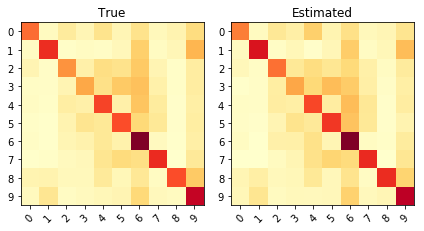

KL divergence: 0.0109	Pearson Correlation between diagonals: 0.9707


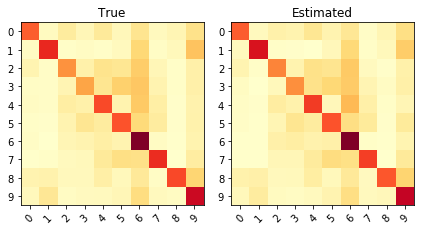

KL divergence: 0.0103	Pearson Correlation between diagonals: 0.9737


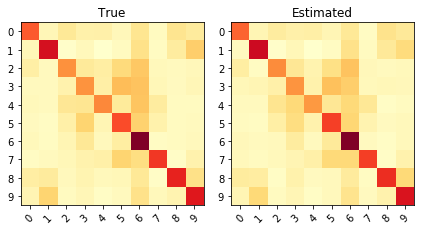

KL divergence: 0.0094	Pearson Correlation between diagonals: 0.9890


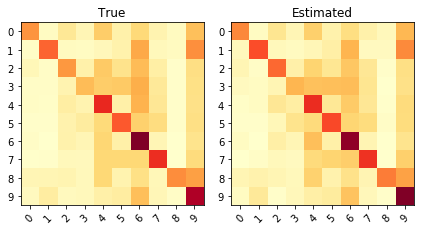

KL divergence: 0.0108	Pearson Correlation between diagonals: 0.9753


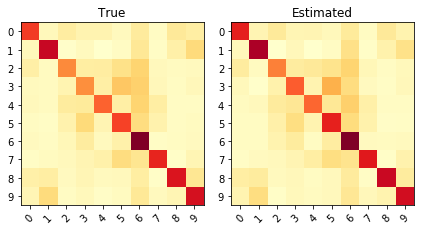

KL divergence: 0.0099	Pearson Correlation between diagonals: 0.9703


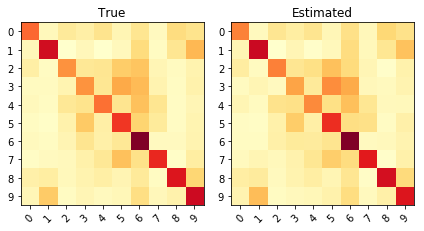

KL divergence: 0.0103	Pearson Correlation between diagonals: 0.9761


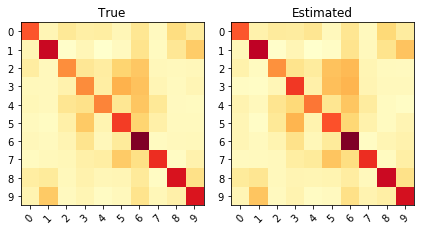

KL divergence: 0.0111	Pearson Correlation between diagonals: 0.9322


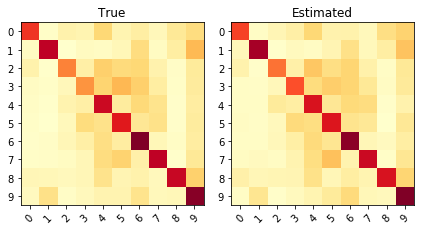

KL divergence: 0.0104	Pearson Correlation between diagonals: 0.9450


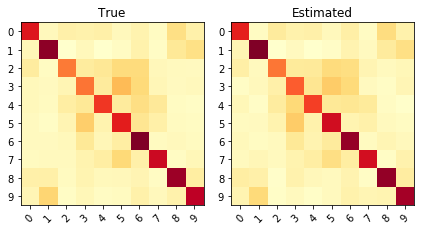

KL divergence: 0.0138	Pearson Correlation between diagonals: 0.9703


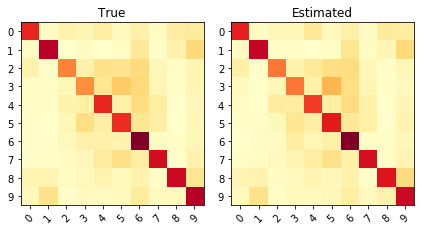

KL divergence: 0.0106	Pearson Correlation between diagonals: 0.9699


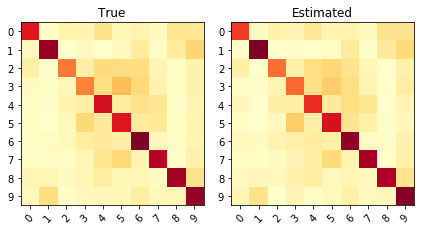

KL divergence: 0.0113	Pearson Correlation between diagonals: 0.9479


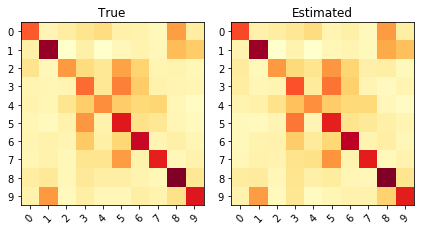

KL divergence: 0.0085	Pearson Correlation between diagonals: 0.9902


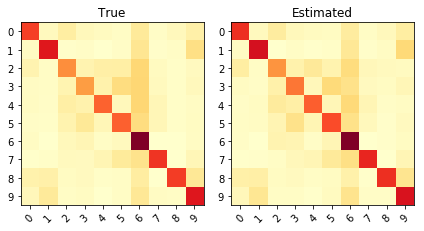

KL divergence: 0.0130	Pearson Correlation between diagonals: 0.9784


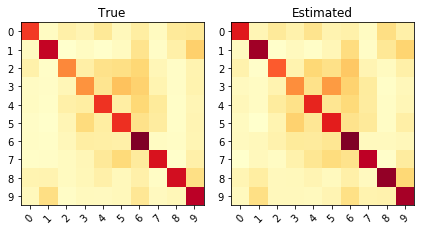

KL divergence: 0.0136	Pearson Correlation between diagonals: 0.9626


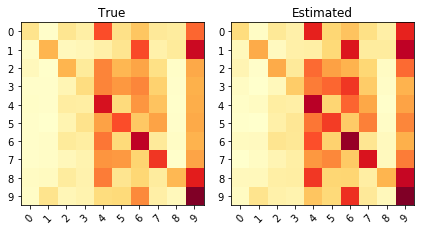

KL divergence: 0.0088	Pearson Correlation between diagonals: 0.9932
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.82314       0.82314  0.0111718  0.0027915            0.969676       0.0386291
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.374174                 1.82648
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.7808 

In [28]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


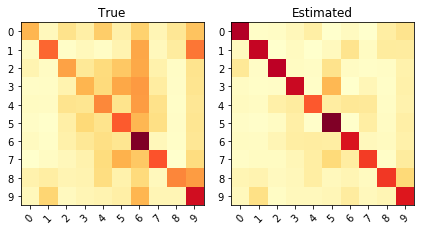

KL divergence: 0.4026	Pearson Correlation between diagonals: -0.1576


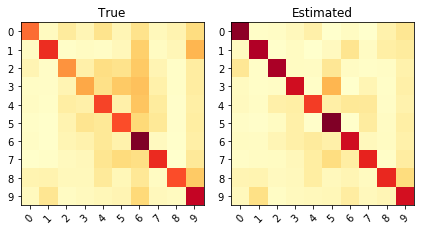

KL divergence: 0.2886	Pearson Correlation between diagonals: -0.2170


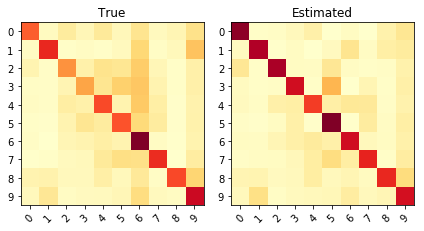

KL divergence: 0.2715	Pearson Correlation between diagonals: -0.1856


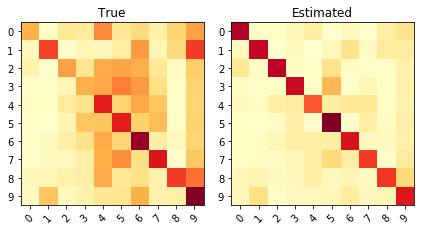

KL divergence: 0.4052	Pearson Correlation between diagonals: -0.3519


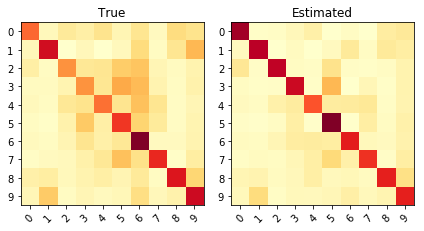

KL divergence: 0.2707	Pearson Correlation between diagonals: -0.1941


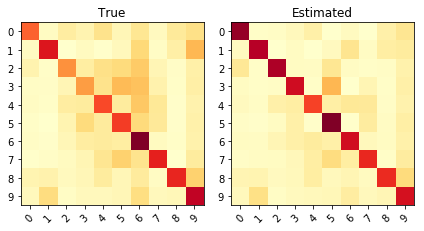

KL divergence: 0.2580	Pearson Correlation between diagonals: -0.2147


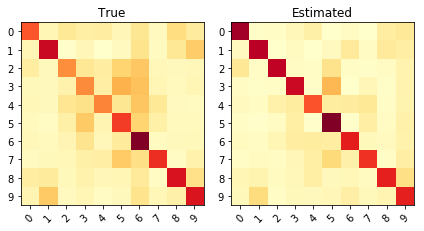

KL divergence: 0.2622	Pearson Correlation between diagonals: -0.1064


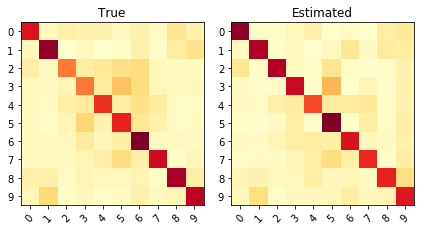

KL divergence: 0.1825	Pearson Correlation between diagonals: -0.1698


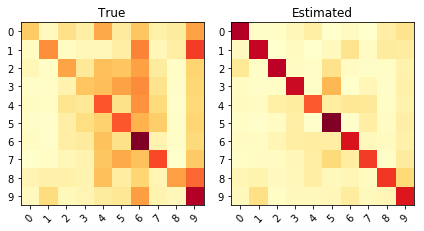

KL divergence: 0.4795	Pearson Correlation between diagonals: -0.2397


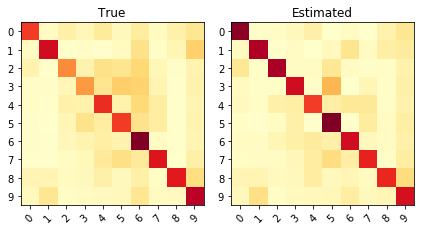

KL divergence: 0.2171	Pearson Correlation between diagonals: -0.2257


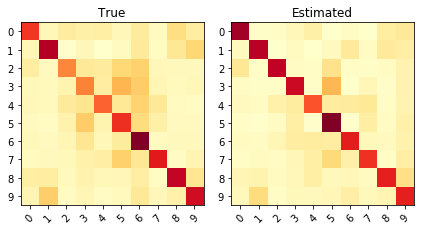

KL divergence: 0.2257	Pearson Correlation between diagonals: -0.1347


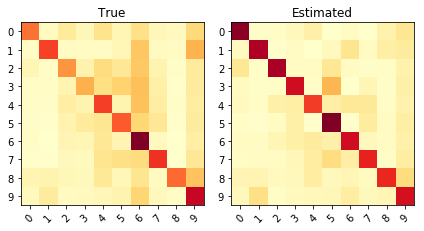

KL divergence: 0.3262	Pearson Correlation between diagonals: -0.2204


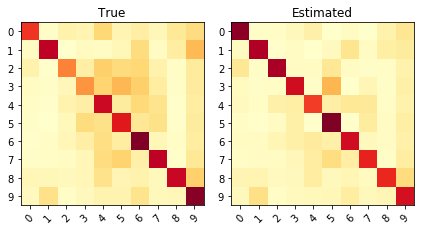

KL divergence: 0.2285	Pearson Correlation between diagonals: -0.3345


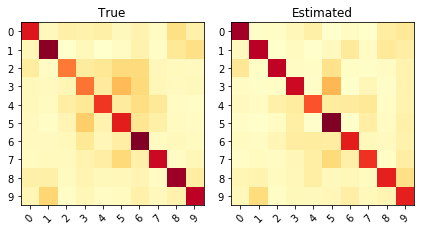

KL divergence: 0.1870	Pearson Correlation between diagonals: -0.1704


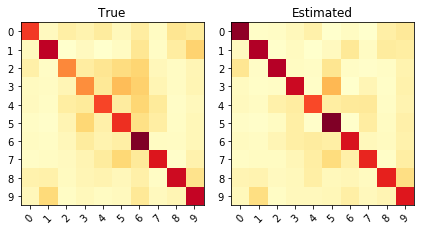

KL divergence: 0.2119	Pearson Correlation between diagonals: -0.2074
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.81248       0.81248   0.295512  0.0539347           -0.227553       0.0216622
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.382421                 1.85387
====  =======================  ======================
Test


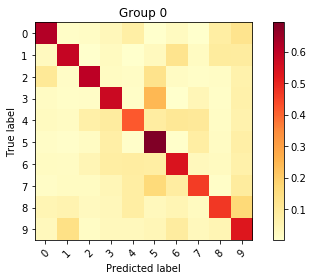

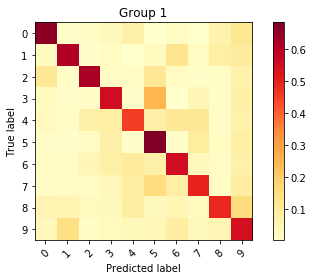

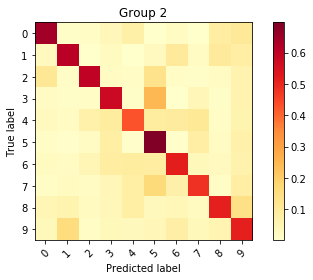

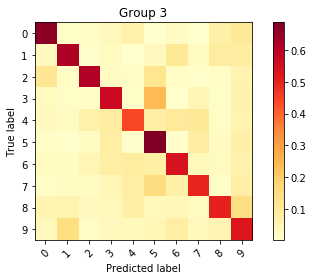

Inertia: 0.0005347140759113245
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.286319      28    1.51423     0.54974    0.608889       0.724331   0.44974       0.7527        0.7527
   1         1  0.231767      23    1.48149     0.568243   0.573222       0.738611   0.468243      0.7524        0.7524
   2         2  0.260179      26    1.50028     0.559112   0.590886       0.731538   0.459112      0.7545        0.7545
   3         3  0.221736      22    1.48903     0.566845   0.576534       0.737372   0.466845      0.7571        0.7571
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============

In [29]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


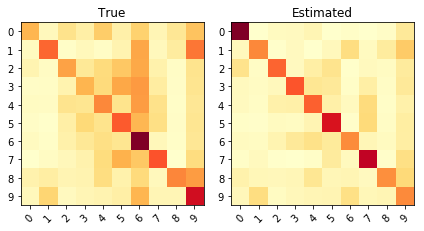

KL divergence: 0.3647	Pearson Correlation between diagonals: -0.4020


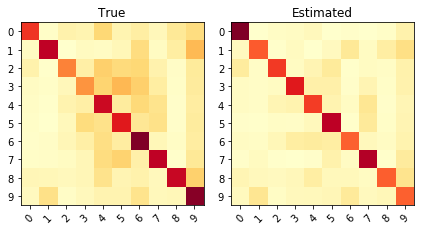

KL divergence: 0.2542	Pearson Correlation between diagonals: -0.3839


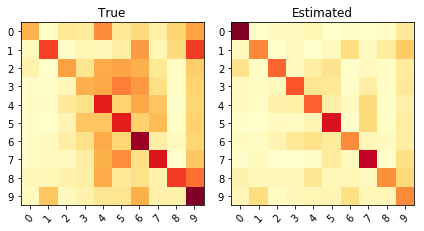

KL divergence: 0.3251	Pearson Correlation between diagonals: -0.3872


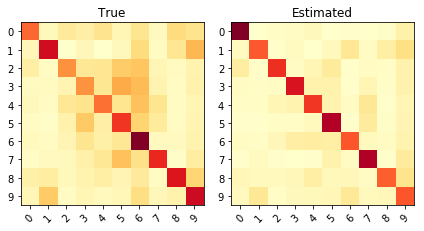

KL divergence: 0.3609	Pearson Correlation between diagonals: -0.4660


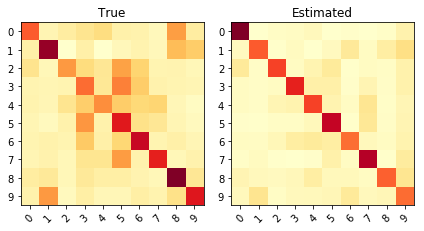

KL divergence: 0.3801	Pearson Correlation between diagonals: -0.3386


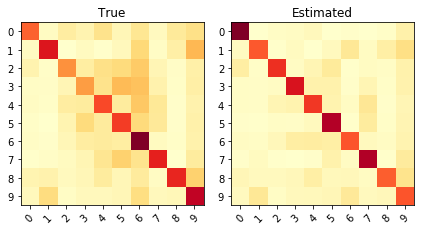

KL divergence: 0.3257	Pearson Correlation between diagonals: -0.4443


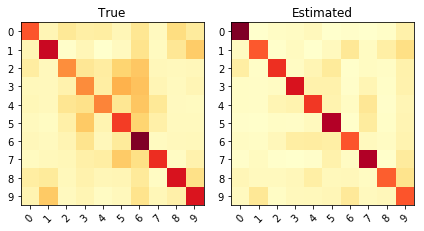

KL divergence: 0.3712	Pearson Correlation between diagonals: -0.4378


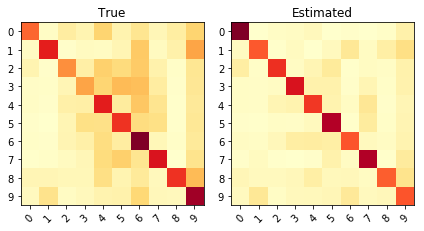

KL divergence: 0.3292	Pearson Correlation between diagonals: -0.4171


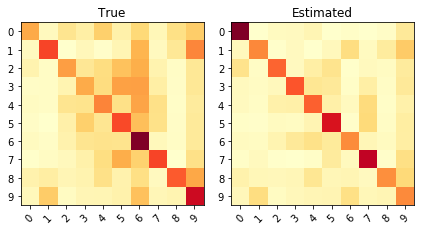

KL divergence: 0.3414	Pearson Correlation between diagonals: -0.4197


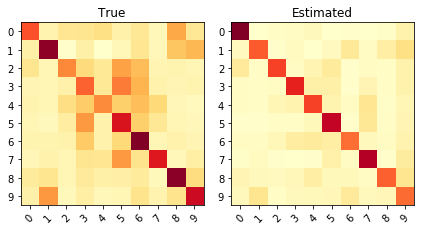

KL divergence: 0.3920	Pearson Correlation between diagonals: -0.4048


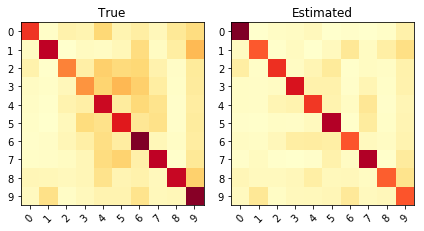

KL divergence: 0.2627	Pearson Correlation between diagonals: -0.4015


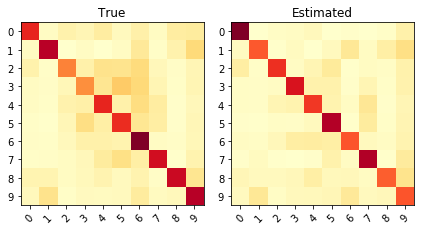

KL divergence: 0.2423	Pearson Correlation between diagonals: -0.3919


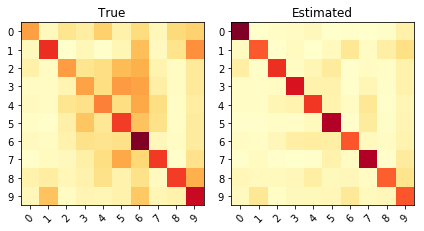

KL divergence: 0.4379	Pearson Correlation between diagonals: -0.4897


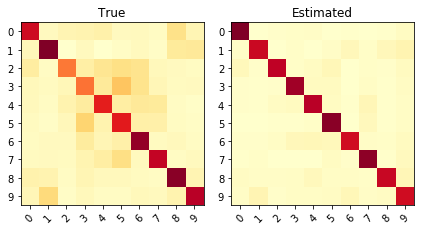

KL divergence: 0.3767	Pearson Correlation between diagonals: -0.3828


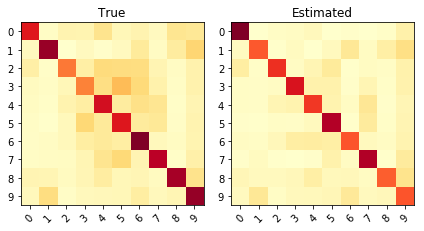

KL divergence: 0.2272	Pearson Correlation between diagonals: -0.3866
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.82004       0.82004   0.339203  0.0634644           -0.389461       0.0134439
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.391196                  1.8353
====  =======================  ======================
Test


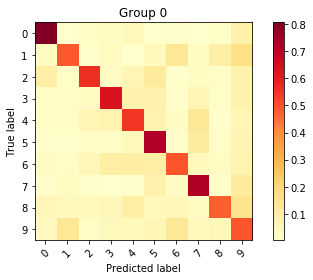

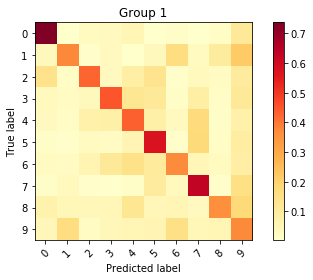

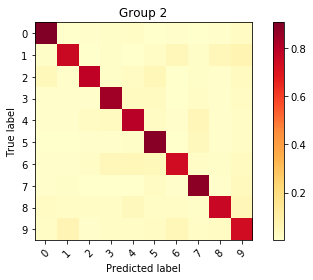

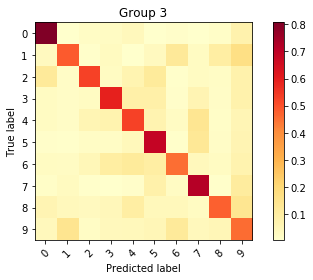

Inertia: 0.024489921813559096
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.291269      29   1.41898      0.595017   0.536267       0.755367   0.495017      0.7801        0.7801
   1         1  0.244392      24   1.65061      0.474456   0.775785       0.660955   0.374456      0.7697        0.7697
   2         2  0.239811      23   0.850557     0.809616   0.214002       0.896667   0.709616      0.7726        0.7726
   3         3  0.224528      22   1.47136      0.57344    0.57562        0.739278   0.47344       0.783         0.783
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A

In [30]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


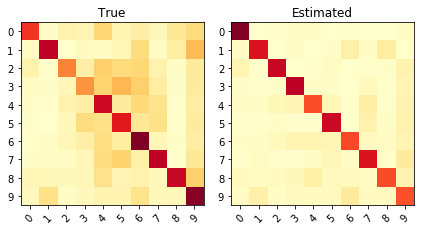

KL divergence: 0.6193	Pearson Correlation between diagonals: -0.6999


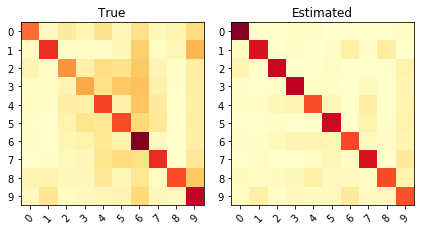

KL divergence: 0.7255	Pearson Correlation between diagonals: -0.6415


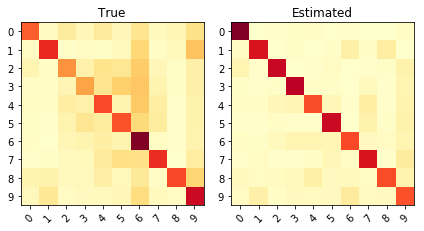

KL divergence: 0.6908	Pearson Correlation between diagonals: -0.6036


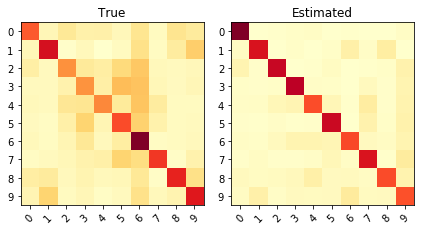

KL divergence: 0.7326	Pearson Correlation between diagonals: -0.4776


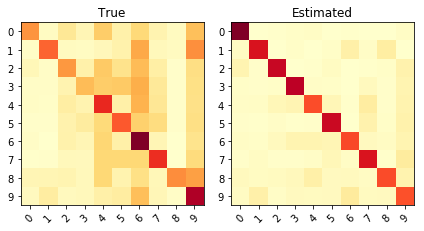

KL divergence: 0.8743	Pearson Correlation between diagonals: -0.6731


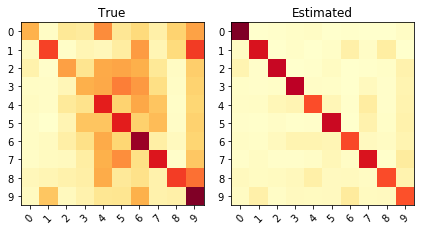

KL divergence: 0.9423	Pearson Correlation between diagonals: -0.7956


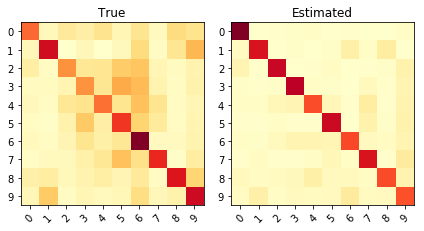

KL divergence: 0.7517	Pearson Correlation between diagonals: -0.5807


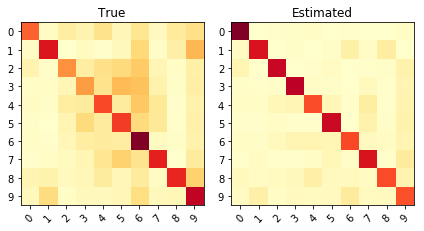

KL divergence: 0.7087	Pearson Correlation between diagonals: -0.6433


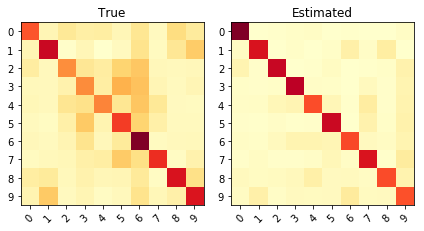

KL divergence: 0.7309	Pearson Correlation between diagonals: -0.4793


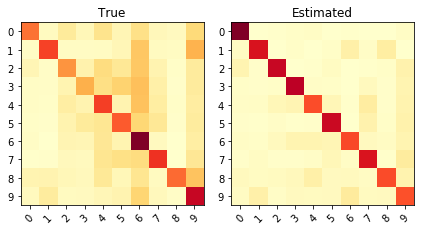

KL divergence: 0.7529	Pearson Correlation between diagonals: -0.6286


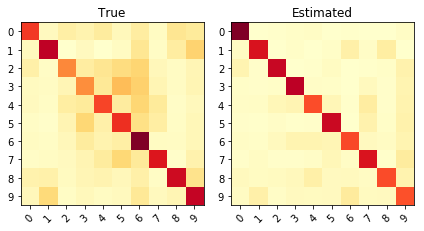

KL divergence: 0.6203	Pearson Correlation between diagonals: -0.5641


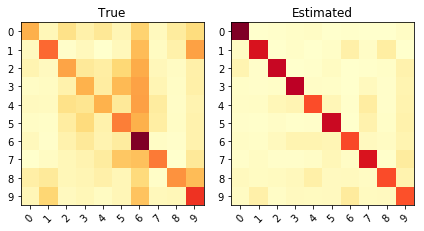

KL divergence: 0.9790	Pearson Correlation between diagonals: -0.5003


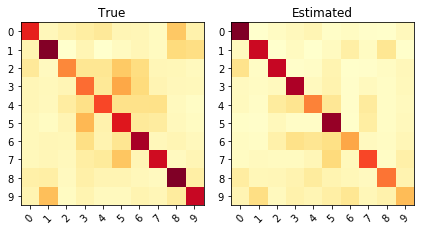

KL divergence: 0.3478	Pearson Correlation between diagonals: -0.4069


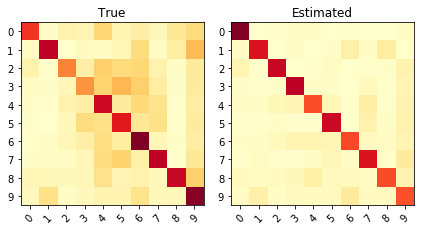

KL divergence: 0.6193	Pearson Correlation between diagonals: -0.6999


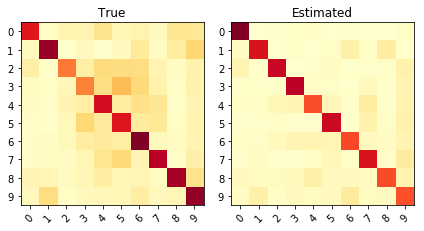

KL divergence: 0.5370	Pearson Correlation between diagonals: -0.6139
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.78652       0.78652   0.690587   0.108162           -0.547658       0.0147114
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                  0.39104                 1.84526
====  =======================  ======================
Test


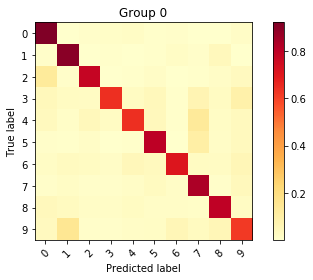

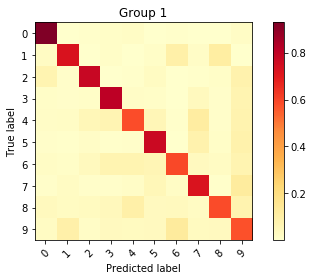

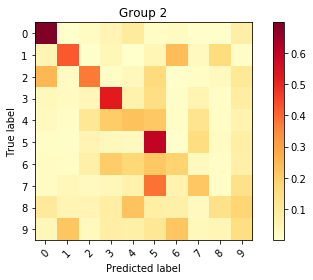

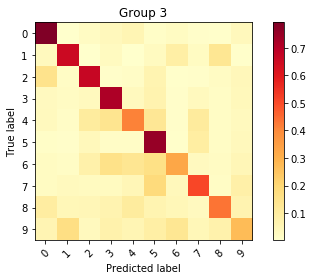

Inertia: 0.056852646016826235
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.286358      28    0.95476     0.765129   0.27667        0.868483   0.665129      0.7426        0.7426
   1         1  0.47937       47    1.10851     0.707985   0.35815        0.832072   0.607985      0.7726        0.7726
   2         2  0.122687      12    1.73729     0.352142   1.19923        0.532014   0.252142      0.3           0.3
   3         3  0.111585      11    1.48191     0.554779   0.647585       0.716657   0.454779      0.7872        0.7872
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A r

In [32]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 4) configuration: Manny annot v1 ($T$ = 2000, $T_{max}$ = 20 )

In [ ]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

*** Raykar model multiples runs***
Train


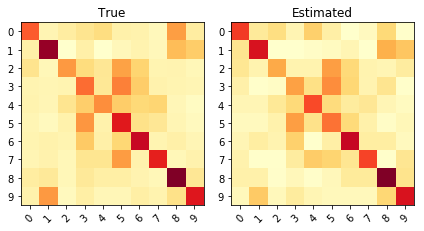

KL divergence: 0.0717	Pearson Correlation between diagonals: 0.8312


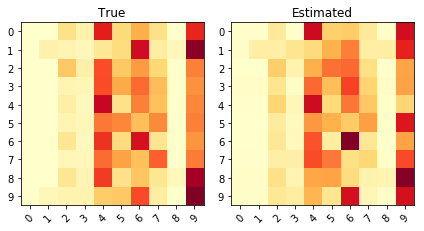

KL divergence: 0.1001	Pearson Correlation between diagonals: 0.9188


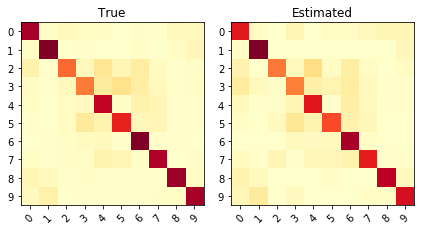

KL divergence: 0.0825	Pearson Correlation between diagonals: 0.9391


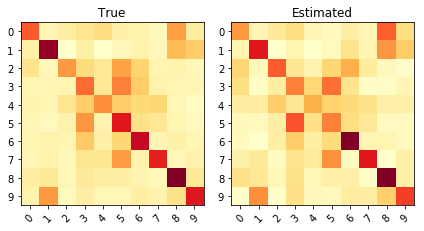

KL divergence: 0.0608	Pearson Correlation between diagonals: 0.7944


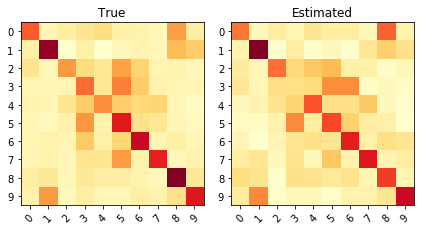

KL divergence: 0.0783	Pearson Correlation between diagonals: 0.6312


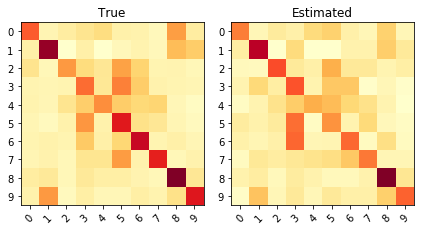

KL divergence: 0.0915	Pearson Correlation between diagonals: 0.7020


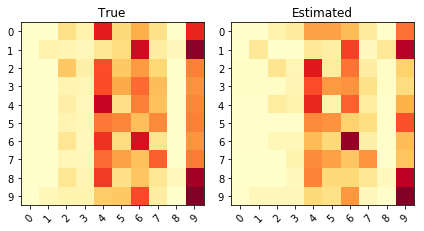

KL divergence: 0.0994	Pearson Correlation between diagonals: 0.9708


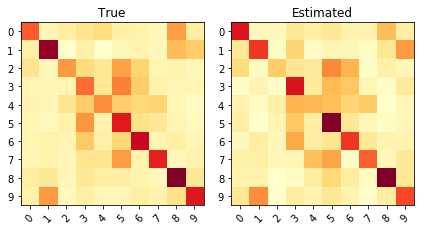

KL divergence: 0.0717	Pearson Correlation between diagonals: 0.6392


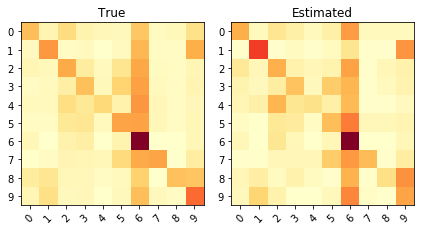

KL divergence: 0.0784	Pearson Correlation between diagonals: 0.9106


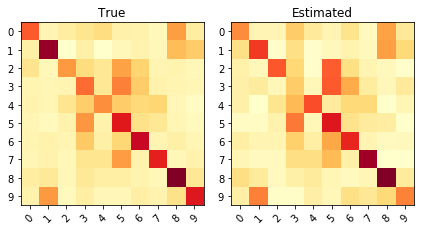

KL divergence: 0.0649	Pearson Correlation between diagonals: 0.5959


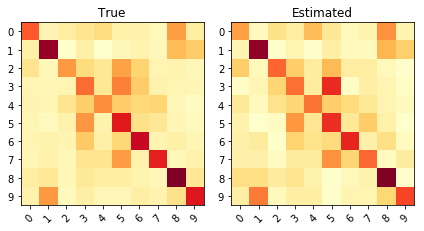

KL divergence: 0.0780	Pearson Correlation between diagonals: 0.8639


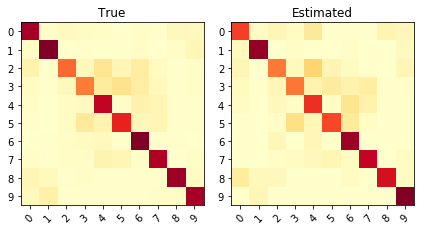

KL divergence: 0.0921	Pearson Correlation between diagonals: 0.8447


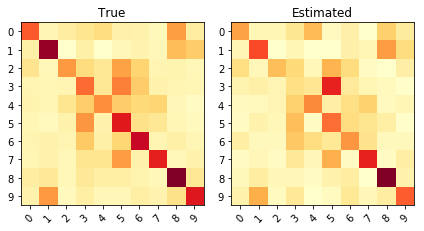

KL divergence: 0.0694	Pearson Correlation between diagonals: 0.7584


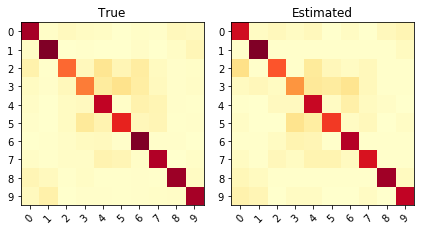

KL divergence: 0.0767	Pearson Correlation between diagonals: 0.9510


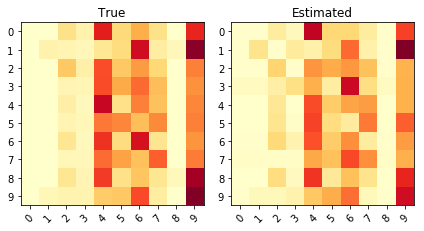

KL divergence: 0.1005	Pearson Correlation between diagonals: 0.9390
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.78094       0.78094  0.0821774  0.0220737            0.874822       0.0714281
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.395359                 1.70213
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.7529 

In [18]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


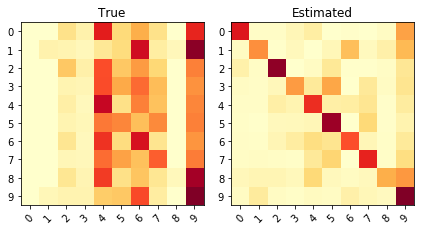

KL divergence: 0.8418	Pearson Correlation between diagonals: 0.5230


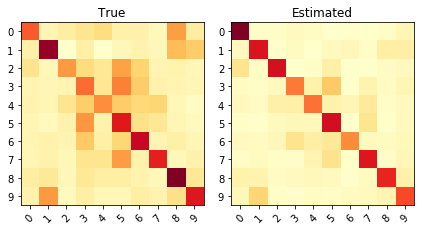

KL divergence: 0.4268	Pearson Correlation between diagonals: 0.0037


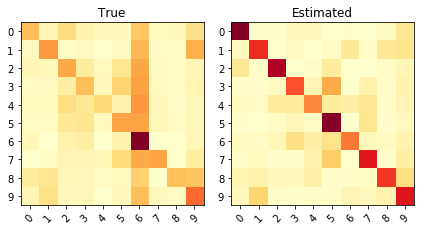

KL divergence: 1.0828	Pearson Correlation between diagonals: -0.2596


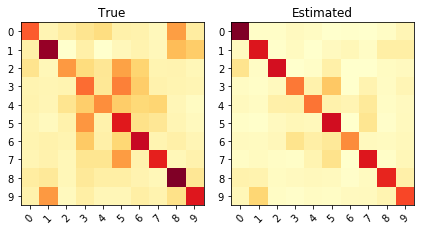

KL divergence: 0.4270	Pearson Correlation between diagonals: -0.0012


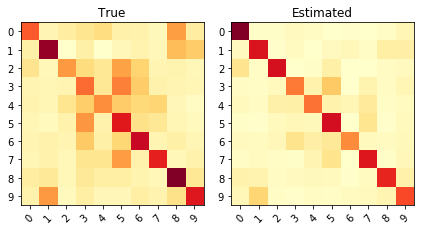

KL divergence: 0.4268	Pearson Correlation between diagonals: 0.0038


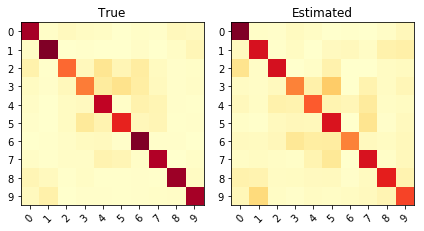

KL divergence: 0.2662	Pearson Correlation between diagonals: 0.1571


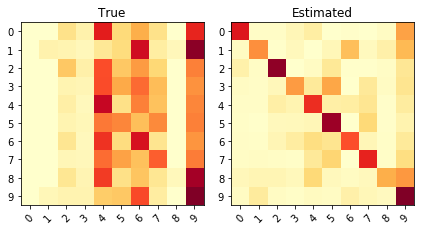

KL divergence: 0.8418	Pearson Correlation between diagonals: 0.5230


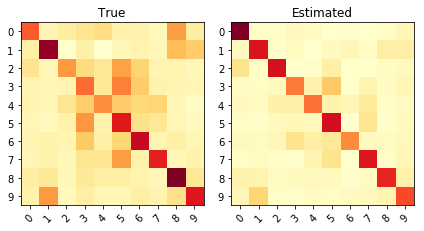

KL divergence: 0.4268	Pearson Correlation between diagonals: 0.0037


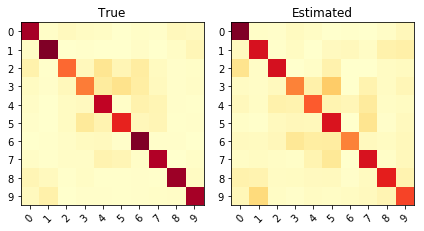

KL divergence: 0.2662	Pearson Correlation between diagonals: 0.1571


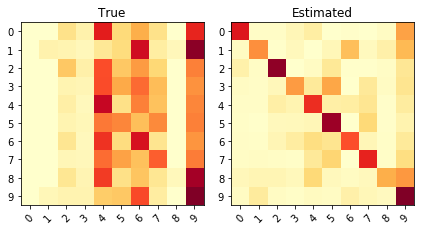

KL divergence: 0.8418	Pearson Correlation between diagonals: 0.5230


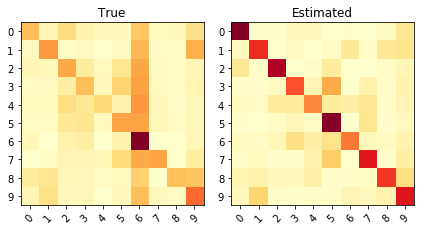

KL divergence: 1.0828	Pearson Correlation between diagonals: -0.2596


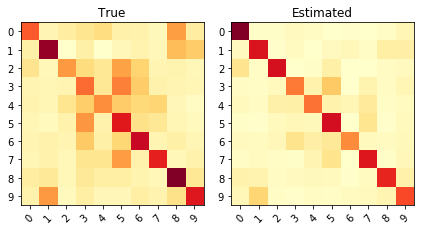

KL divergence: 0.4268	Pearson Correlation between diagonals: 0.0037


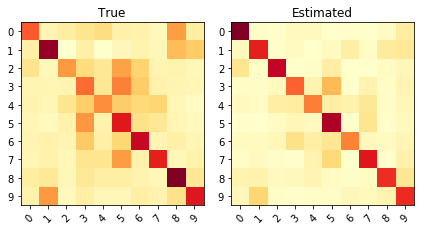

KL divergence: 0.4442	Pearson Correlation between diagonals: -0.0807


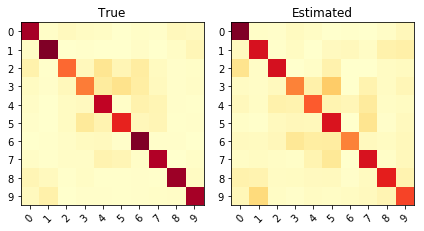

KL divergence: 0.2662	Pearson Correlation between diagonals: 0.1571


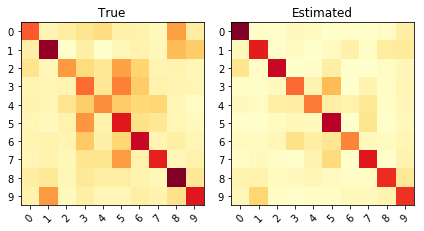

KL divergence: 0.4386	Pearson Correlation between diagonals: -0.0651
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.70006       0.70006   0.578327  0.0910167           0.0946688       0.0390093
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.390257                 1.80474
====  =======================  ======================
Test


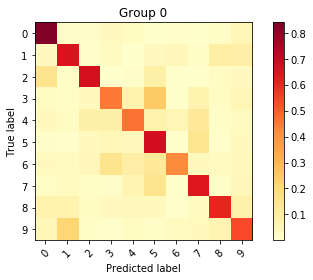

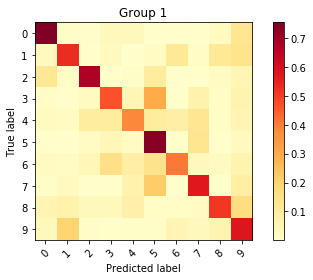

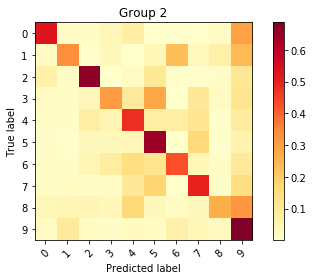

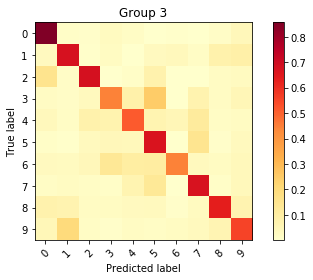

Inertia: 0.019846756472058285
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.183276     366    1.378       0.595919   0.538698       0.755053   0.49592       0.7604        0.7604
   1         1  0.434119     868    1.39975     0.562944   0.59875        0.730605   0.462944      0.7514        0.7514
   2         2  0.203404     406    1.51432     0.484186   0.773092       0.665336   0.384186      0.5978        0.5978
   3         3  0.179201     358    1.33732     0.615444   0.504554       0.769194   0.515444      0.7574        0.7574
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============


In [30]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


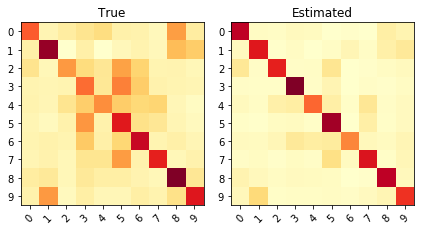

KL divergence: 0.4397	Pearson Correlation between diagonals: 0.0130


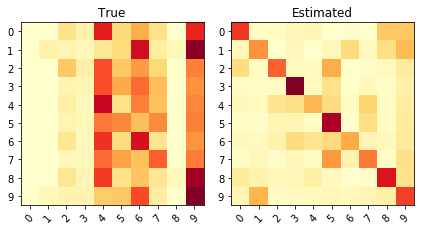

KL divergence: 1.1442	Pearson Correlation between diagonals: -0.4612


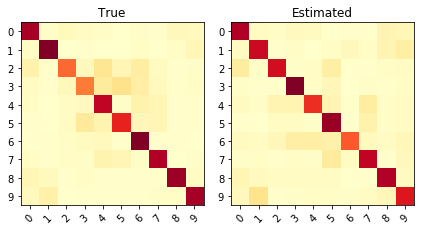

KL divergence: 0.2651	Pearson Correlation between diagonals: -0.5007


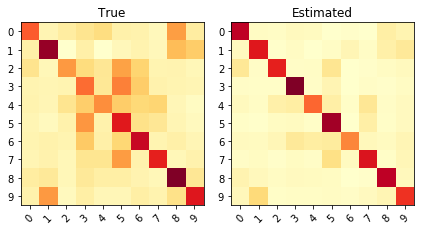

KL divergence: 0.4397	Pearson Correlation between diagonals: 0.0130


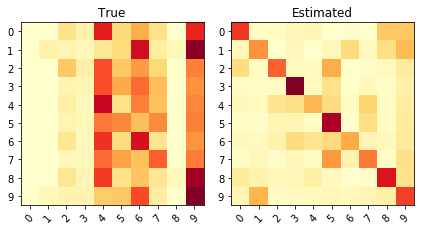

KL divergence: 1.1442	Pearson Correlation between diagonals: -0.4612


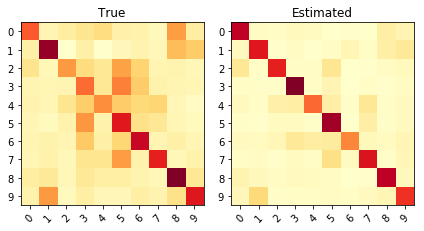

KL divergence: 0.4391	Pearson Correlation between diagonals: 0.0130


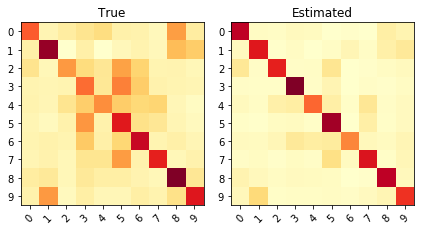

KL divergence: 0.4397	Pearson Correlation between diagonals: 0.0130


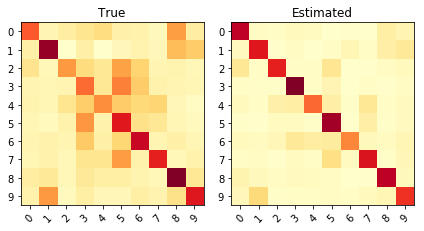

KL divergence: 0.4387	Pearson Correlation between diagonals: 0.0129


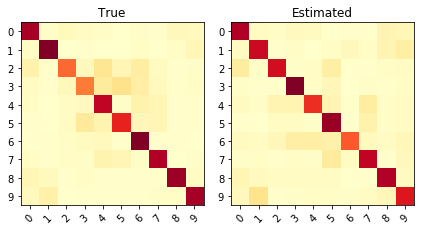

KL divergence: 0.2651	Pearson Correlation between diagonals: -0.5007


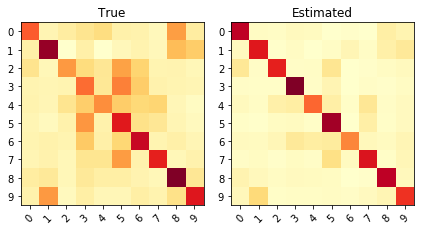

KL divergence: 0.4397	Pearson Correlation between diagonals: 0.0130


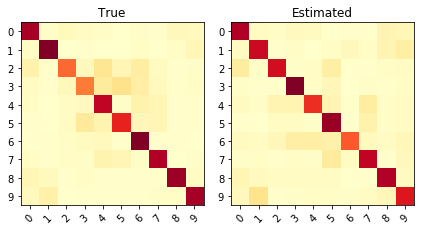

KL divergence: 0.2651	Pearson Correlation between diagonals: -0.5007


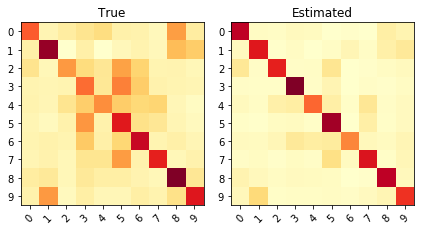

KL divergence: 0.4397	Pearson Correlation between diagonals: 0.0130


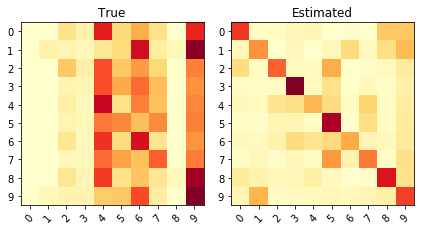

KL divergence: 1.1442	Pearson Correlation between diagonals: -0.4612


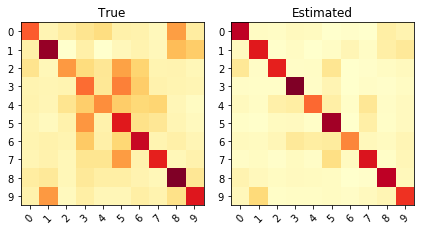

KL divergence: 0.4380	Pearson Correlation between diagonals: 0.0129


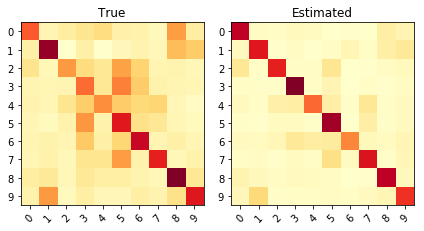

KL divergence: 0.4391	Pearson Correlation between diagonals: 0.0130
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.79336       0.79336    0.64309   0.109905           -0.285686
====  ======  ==========  ============  =========  =========  ==================
Test


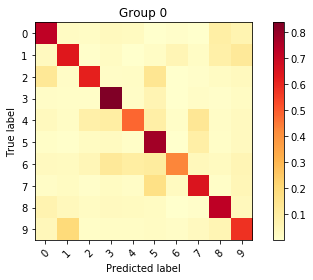

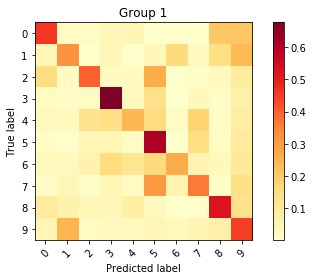

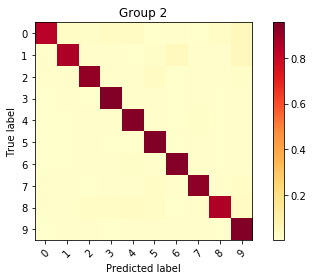

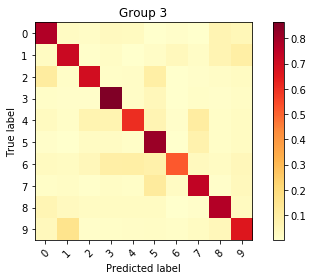

Inertia: 0.06194681334697331
A result
 ====  ========  ========  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.173399   1.26417      0.646478  0.454921        0.790512   0.546478      0.7963        0.7963
   1         1  0.485392   1.63423      0.431333  0.891875        0.621121   0.331333      0.7374        0.7374
   2         2  0.181743   0.439609     0.916978  0.0877133       0.956838   0.816978      0.7177        0.7177
   3         3  0.159466   1.10377      0.716151  0.343336        0.838288   0.616151      0.7847        0.7847
====  ========  ========  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            

In [32]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


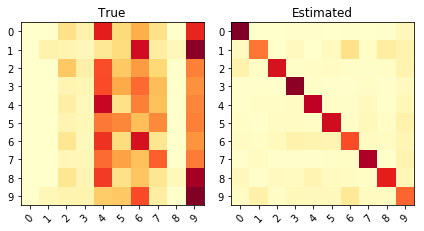

KL divergence: 1.3249	Pearson Correlation between diagonals: -0.3334


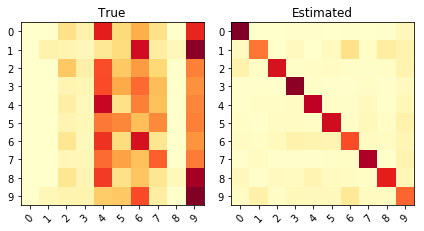

KL divergence: 1.3249	Pearson Correlation between diagonals: -0.3334


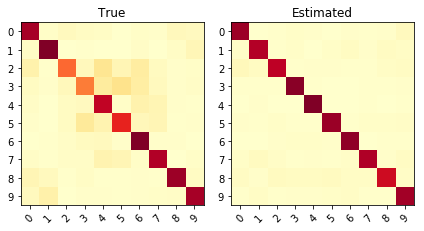

KL divergence: 0.2353	Pearson Correlation between diagonals: -0.1433


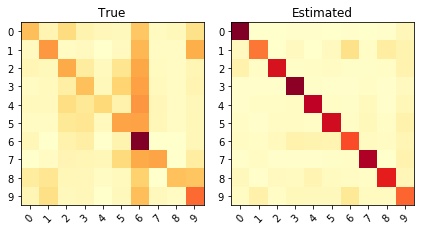

KL divergence: 0.9782	Pearson Correlation between diagonals: -0.5766


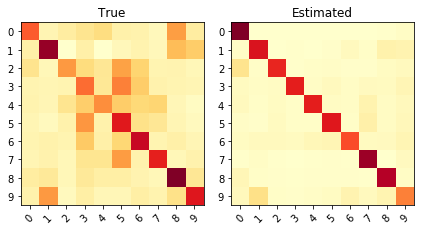

KL divergence: 0.7200	Pearson Correlation between diagonals: 0.0357


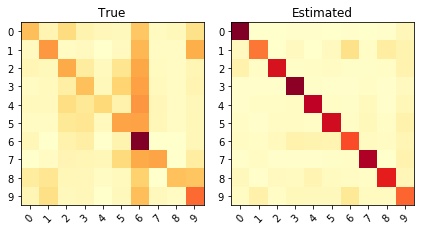

KL divergence: 0.9782	Pearson Correlation between diagonals: -0.5766


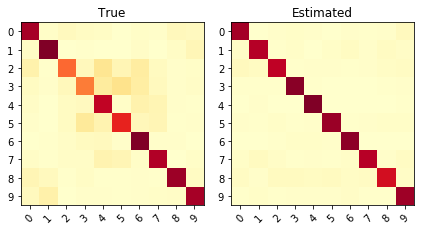

KL divergence: 0.2468	Pearson Correlation between diagonals: -0.1495


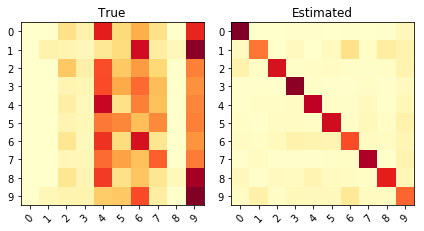

KL divergence: 1.3249	Pearson Correlation between diagonals: -0.3334


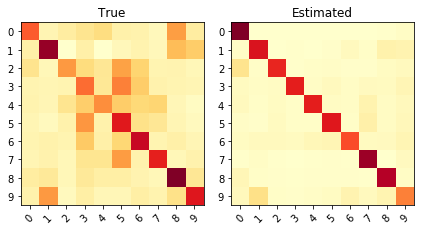

KL divergence: 0.7200	Pearson Correlation between diagonals: 0.0357


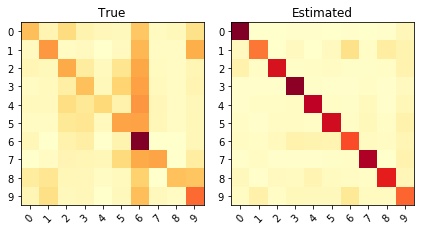

KL divergence: 0.9782	Pearson Correlation between diagonals: -0.5766


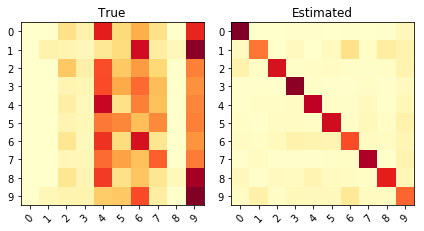

KL divergence: 1.3249	Pearson Correlation between diagonals: -0.3334


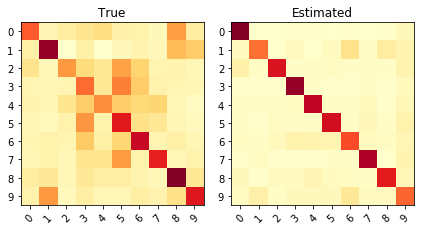

KL divergence: 0.7004	Pearson Correlation between diagonals: -0.6044


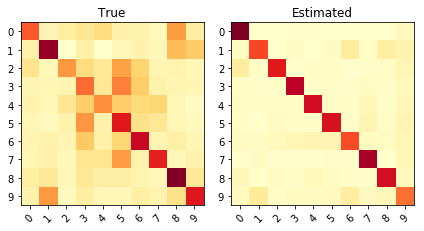

KL divergence: 0.6701	Pearson Correlation between diagonals: -0.4020


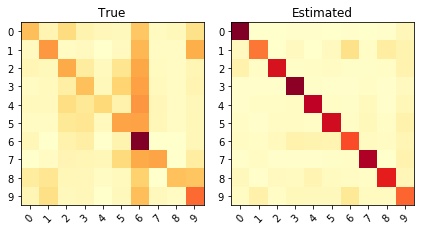

KL divergence: 0.9782	Pearson Correlation between diagonals: -0.5766


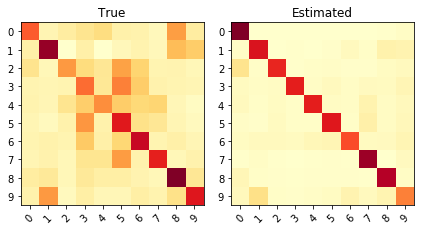

KL divergence: 0.7200	Pearson Correlation between diagonals: 0.0357
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.79336       0.79336   0.778871    0.14502           -0.221635
====  ======  ==========  ============  =========  =========  ==================
Test


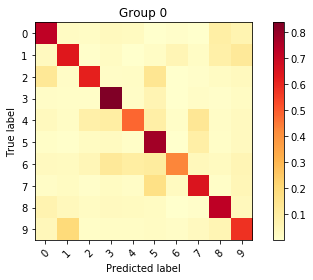

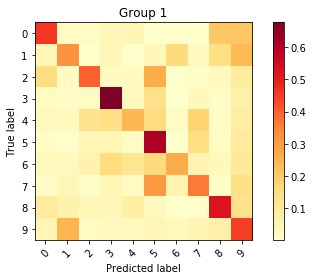

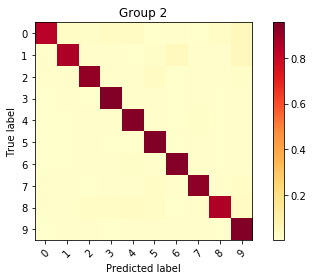

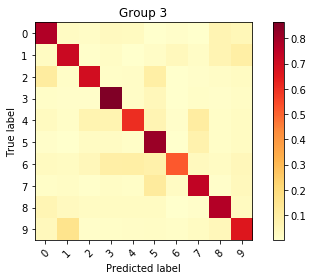

Inertia: 0.06194681334697331
A result
 ====  ========  =========  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups       Prob    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  =========  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.337596    1.26417      0.646478  0.454921        0.790512   0.546478      0.7963        0.7963
   1         1  0.557178    1.63423      0.431333  0.891875        0.621121   0.331333      0.7374        0.7374
   2         2  0.0703039   0.439609     0.916978  0.0877133       0.956838   0.816978      0.7177        0.7177
   3         3  0.0349221   1.10377      0.716151  0.343336        0.838288   0.616151      0.7847        0.7847
====  ========  =========  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..    

In [33]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random


print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 6) configuration: Manny annot v3 ($T$ = 10000, $T_{max}$ = 40 )

In [ ]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

*** Ours (3) multiples runs***
Train


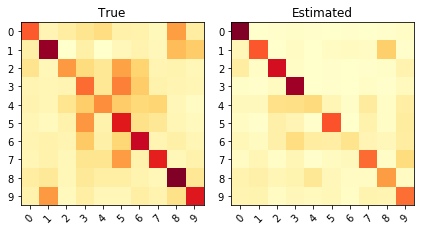

KL divergence: 0.7573	Pearson Correlation between diagonals: -0.3684


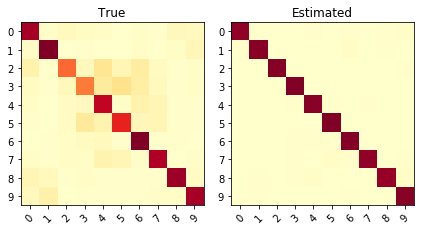

KL divergence: 0.6185	Pearson Correlation between diagonals: -0.5880


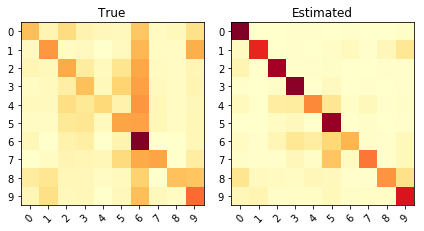

KL divergence: 1.1402	Pearson Correlation between diagonals: -0.4299


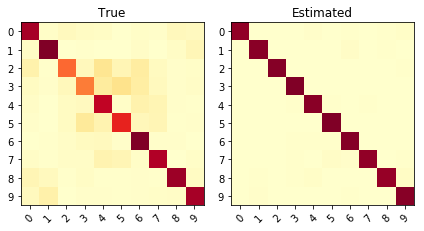

KL divergence: 0.6151	Pearson Correlation between diagonals: -0.5940


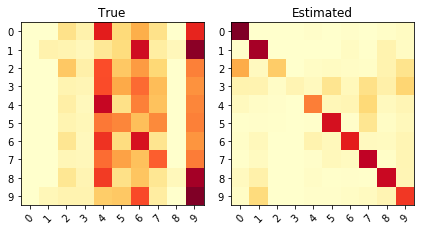

KL divergence: 1.5095	Pearson Correlation between diagonals: -0.0084


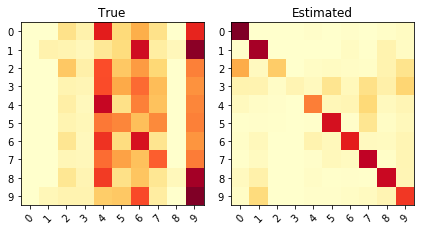

KL divergence: 1.5095	Pearson Correlation between diagonals: -0.0084


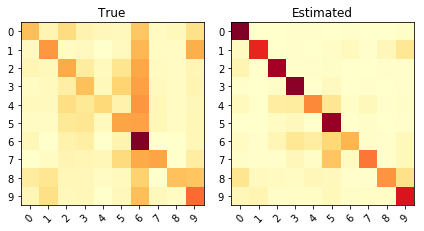

KL divergence: 1.1402	Pearson Correlation between diagonals: -0.4299


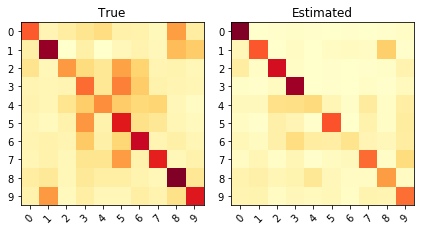

KL divergence: 0.7573	Pearson Correlation between diagonals: -0.3684


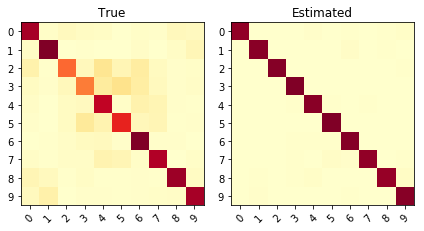

KL divergence: 0.6176	Pearson Correlation between diagonals: -0.5895


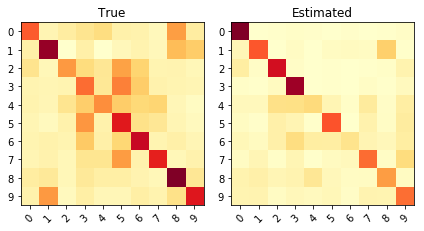

KL divergence: 0.7564	Pearson Correlation between diagonals: -0.3685


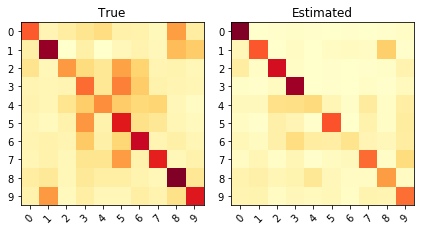

KL divergence: 0.7573	Pearson Correlation between diagonals: -0.3684


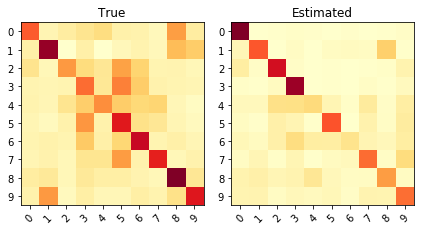

KL divergence: 0.7553	Pearson Correlation between diagonals: -0.3687


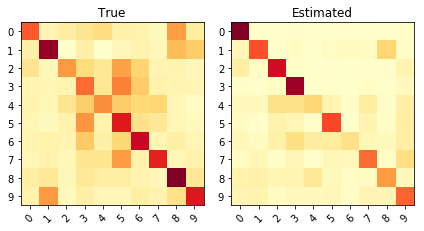

KL divergence: 0.7086	Pearson Correlation between diagonals: -0.3789


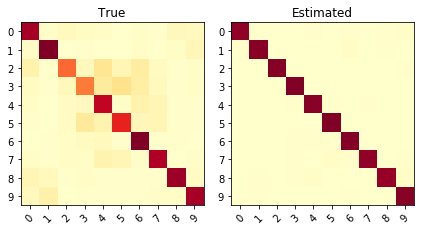

KL divergence: 0.6192	Pearson Correlation between diagonals: -0.5867


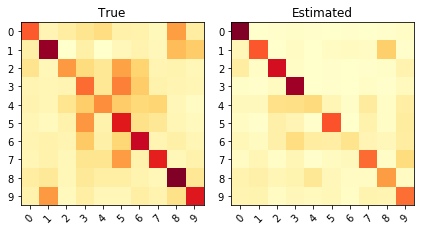

KL divergence: 0.7573	Pearson Correlation between diagonals: -0.3684
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.77822       0.77822   0.936538   0.154852           -0.401687
====  ======  ==========  ============  =========  =========  ==================
Test


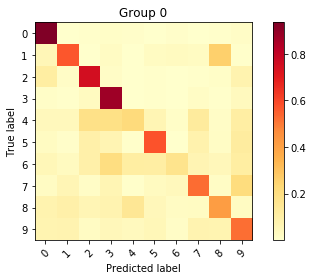

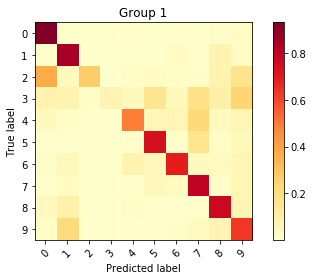

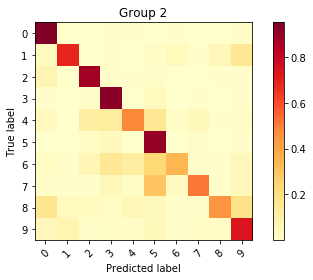

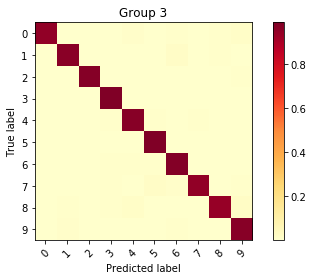

Inertia: 0.12160919544597466
A result
 ====  ========  ========  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.342663   1.3869       0.55524   0.70864         0.704172   0.505822      0.6474        0.6474
   1         1  0.230822   1.12584      0.626365  0.651721        0.747075   0.58485       0.6883        0.6883
   2         2  0.181701   1.02303      0.688215  0.428128        0.808065   0.653572      0.6585        0.6585
   3         3  0.244814   0.184724     0.970111  0.0304564       0.984856   0.96679       0.7108        0.7108
====  ========  ========  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            

In [14]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 7) configuration: Manny annot v1 + bad MV ($T$ = 2000, $T_{max}$ = 20 )

In [ ]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

*** Raykar model multiples runs***
Train


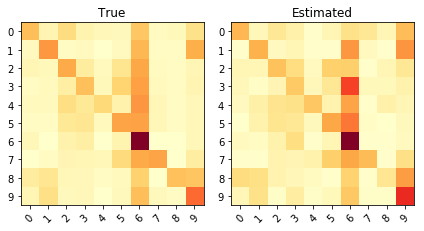

KL divergence: 0.0805	Pearson Correlation between diagonals: 0.9365


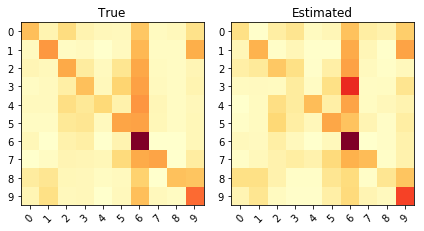

KL divergence: 0.1010	Pearson Correlation between diagonals: 0.9308


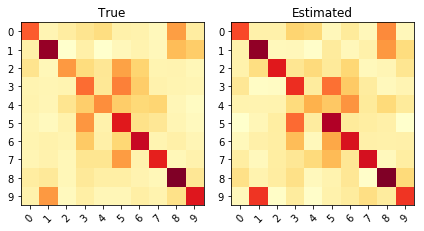

KL divergence: 0.0745	Pearson Correlation between diagonals: 0.7718


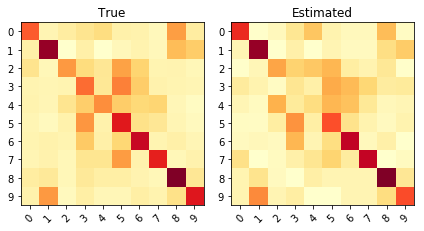

KL divergence: 0.0877	Pearson Correlation between diagonals: 0.8609


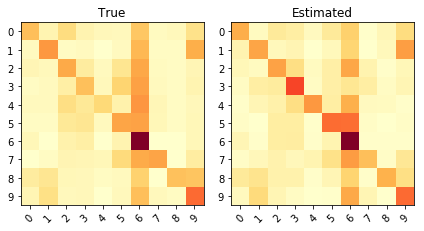

KL divergence: 0.0876	Pearson Correlation between diagonals: 0.8168


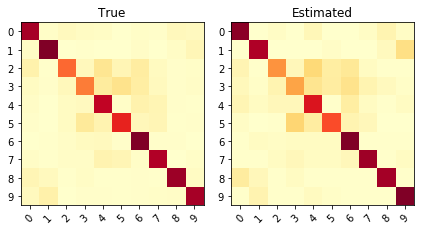

KL divergence: 0.0861	Pearson Correlation between diagonals: 0.9615


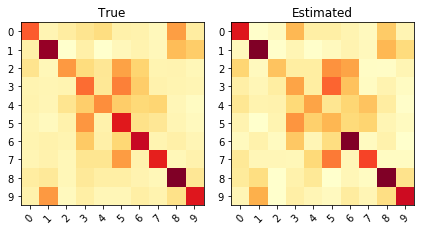

KL divergence: 0.0604	Pearson Correlation between diagonals: 0.8140


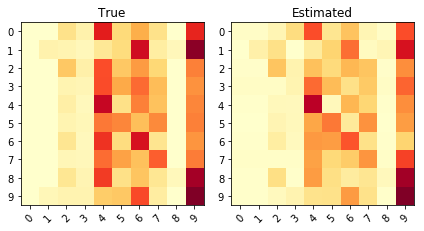

KL divergence: 0.0935	Pearson Correlation between diagonals: 0.9819


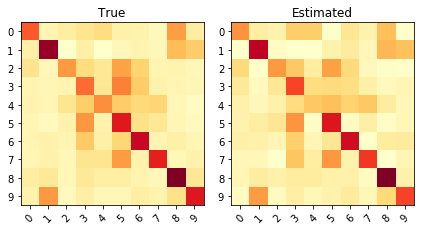

KL divergence: 0.0708	Pearson Correlation between diagonals: 0.9268


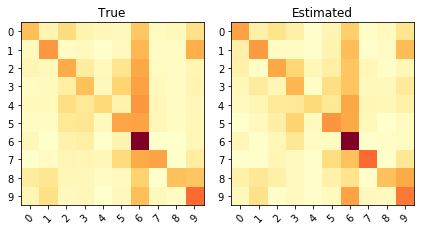

KL divergence: 0.0628	Pearson Correlation between diagonals: 0.9652


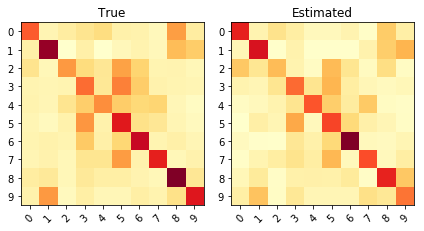

KL divergence: 0.0745	Pearson Correlation between diagonals: 0.6372


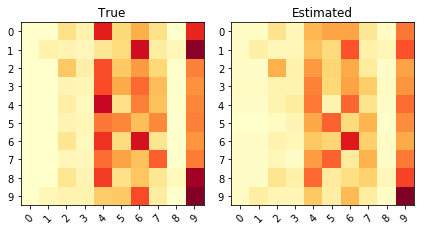

KL divergence: 0.0959	Pearson Correlation between diagonals: 0.9426


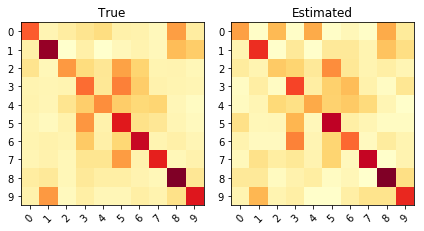

KL divergence: 0.0744	Pearson Correlation between diagonals: 0.7761


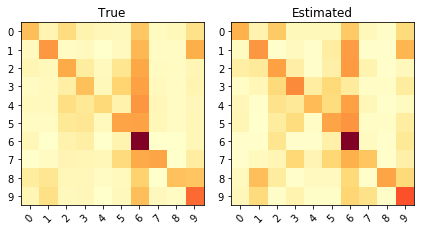

KL divergence: 0.1002	Pearson Correlation between diagonals: 0.9359


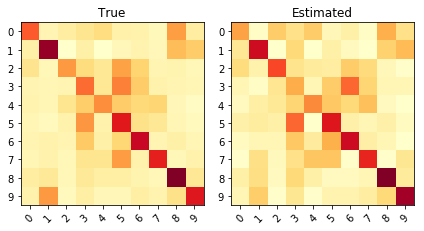

KL divergence: 0.0809	Pearson Correlation between diagonals: 0.8072
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.77382       0.77382  0.0853959   0.022828            0.870939       0.0626477
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.370616                 1.74988
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.7428 

In [19]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [20]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

MemoryError: 

In [ ]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random


print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)